# 1. Introduction

This project performs time series analysis on the provided sleep training dataset. We aim to explore, preprocess, and model the data to extract meaningful insights.

# 2. Import Libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler , LabelEncoder
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, ClusterCentroids
from imblearn.pipeline import Pipeline
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from scipy import signal, stats
import pywt
import math
from scipy import signal, stats
import pywt
from imblearn.under_sampling import TomekLinks
import keras

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


# 3. Load and Explore the Data

In [ ]:
# Load the dataset
initial_dataset = pd.read_csv("Sleep Train 5000.csv", header=None)
initial_dataset.rename(columns={0: 'target'}, inplace=True)
initial_dataset.head()

target          1          2          3         4          5          6  \
0       0  -1.608303 -13.170696  -8.997802  1.347497   5.259585  -1.521367   
1       0  -2.825397   2.390720   3.955555 -4.216361   2.477656   2.129914   
2       0 -15.952625  -3.347008 -15.517949 -9.432479 -16.474237  -6.650549   
3       0 -26.558731 -18.560684 -12.040537 -4.216361  -9.432479   1.260562   
4       0  -5.607326   6.042003  -4.129426 -5.172649  -7.172161 -11.953602   

           7          8          9  ...       169       170       171  \
0   2.651526   4.651038   3.781685  ... -8.041514 -6.563614 -4.998779   
1   3.955555  -5.172649   5.694261  ...  4.129426  7.085226 -2.390720   
2 -14.909402 -12.214408 -10.823443  ... -4.390232 -0.738950  4.477167   
3  -2.216850  -3.520879  -5.781197  ... -3.086203 -0.652015  3.607814   
4  -7.780708  -0.130403  -2.912332  ... -1.260562  1.608303  4.564103   

         172        173        174        175        176       177       178  
0  -5.346520  -6.389744 -11.171185  -2.390720   1.086691  6.911355  6.128938  
1  -2.303785  -3.694750   4.564103  -6.215873  -2.738462 -4.477167 -4.390232  
2  12.996825  21.951160  21.081806  21.603418  14.909402  9.345543  6.998291  
3  15.170208  16.039560   6.128938   3.955555  -1.956044 -2.390720 -4.651038  
4  -4.911844  10.301831  10.127961   8.389256  -2.216850 -4.390232  0.478144  

[5 rows x 179 columns]

In [ ]:
print(f"Dataset shape: {initial_dataset.shape}")
# Summary statistics
print("\nSummary Statistics:")
print(initial_dataset.describe())

Dataset shape: (4999, 179)

Summary Statistics:
            target            1            2            3            4  \
count  4999.000000  4999.000000  4999.000000  4999.000000  4999.000000   
mean      2.164633    -0.554607    -0.564193    -0.540193    -0.649433   
std       1.153444    17.789305    17.597088    17.681466    17.723401   
min       0.000000  -146.094760   -82.371185   -81.849570   -90.543100   
25%       2.000000    -9.345543    -9.258608    -9.519414    -9.693284   
50%       2.000000    -0.391209    -0.652015    -0.652015    -0.738950   
75%       3.000000     8.062149     8.041514     8.215385     8.215385   
max       4.000000   105.409035    95.585350    91.934070   109.668860   

                 5            6            7            8            9  ...  \
count  4999.000000  4999.000000  4999.000000  4999.000000  4999.000000  ...   
mean     -0.753712    -1.075914    -1.181350    -1.451674    -1.382415  ...   
std      17.403211    17.384649    17.279831    

## 3.1 EDA for Target

This section defines utility functions to explore EEG sleep stage classification datasets. It includes plots for class distributions, feature correlations, EEG waveform examples, and important feature distributions per class. These visualizations help understand the data structure and patterns across different sleep stages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot EEG waveforms for each sleep stage
def plot_eeg_waveforms_for_classes(eeg_data, class_labels, classes=None, title="EEG Waveforms for Sleep Stages", figsize=(12, 6)):
    """
    Plots EEG waveforms for each sleep stage.

    Parameters:
    - eeg_data (list of np.ndarray): List containing EEG signals for each sample (e.g., list of arrays).
    - class_labels (list): List of class labels for each sample (e.g., sleep stages).
    """
    # If classes are not provided, use unique class labels
    if classes is None:
        classes = np.unique(class_labels)

    # Set up subplots for each class
    fig, axes = plt.subplots(len(classes), 1, figsize=figsize, sharex=True)
    if len(classes) == 1:
        axes = [axes]  # If only one class, make sure axes is iterable

    # Loop through each class and plot example waveforms
    for i, cls in enumerate(classes):
        # Find indices of samples for the current class
        idxs = np.where(class_labels == cls)[0]

        # If there are any samples for this class, plot the first one
        if len(idxs) > 0:
            axes[i].plot(eeg_data[idxs[0], :])  # Plot the first waveform of this class
            axes[i].set_ylabel(f"Stage {cls}")
        else:
            axes[i].text(0.5, 0.5, f'No samples for class {cls}', ha='center', va='center', fontsize=12)

    axes[-1].set_xlabel('Time or Sample Index')
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# Function to plot class distribution (sleep stages)
def plot_class_distribution(labels, title="Sleep Stage Distribution", figsize=(8, 5), color_palette="Set2"):
    plt.figure(figsize=figsize)
    sns.countplot(x=labels, palette=color_palette)
    plt.title(title)
    plt.xlabel("Sleep Stage")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# Function to plot correlation of features with sleep stage labels
def plot_target_correlation_with_features(df, target_col, title="Correlation with Sleep Stage", figsize=(8, 6)):
    df = df.copy()
    correlations = df.corr(numeric_only=True)[target_col].drop(target_col)
    plt.figure(figsize=figsize)
    correlations.sort_values().plot(kind='barh', color='teal')
    plt.title(title)
    plt.xlabel("Correlation Coefficient")
    plt.grid(True)
    plt.show()

# Function to plot distribution of the most important features for each sleep stage
def plot_classwise_important_feature_distributions(df, target_col, top_n=5, figsize=(8, 5)):
    """
    Plot the distribution of the most important features for each sleep stage.

    Parameters:
    - df (pd.DataFrame): DataFrame containing both features and target.
    - target_col (str): Name of the column containing class labels (sleep stages).
    - top_n (int): Number of top features to consider based on correlation with the target column.
    - figsize (tuple): Size of the plot.
    """
    # Calculate correlations with the target column
    correlations = df.corr(numeric_only=True)[target_col].drop(target_col)

    # Select top_n most correlated features (absolute value of correlation)
    top_features = correlations.abs().sort_values(ascending=False).head(top_n).index

    # Plot distributions for each selected feature
    for feature in top_features:
        plt.figure(figsize=figsize)
        sns.kdeplot(data=df, x=feature, hue=target_col, fill=True)
        plt.title(f"{feature} Distribution per Sleep Stage")
        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.grid(True)
        plt.show()

# Function to plot class examples (waveforms or feature plots)
def plot_class_examples(df, target_col, class_label, feature_cols=None, n=5, title=None):
    subset = df[df[target_col] == class_label].head(n)
    feature_data = subset[feature_cols].values if feature_cols else subset.drop(columns=[target_col]).values

    plt.figure(figsize=(15, 2))
    for i, row in enumerate(feature_data):
        plt.subplot(1, n, i + 1)
        plt.plot(row)
        plt.title(f"Sample {i+1}")
        plt.axis('off')
    plt.suptitle(title or f"EEG Examples for Stage {class_label}")
    plt.show()

# Main function to run all exploratory plots for EEG data, now for all columns/features
def explore_target(df, target_col, eeg_data=None, class_for_examples=None, feature_cols=None):
    """
    Run selected exploratory plots for EEG sleep stage classification data.

    Parameters:
    - df (pd.DataFrame): DataFrame containing both features and target.
    - target_col (str): Name of the column containing class labels (sleep stages).
    - eeg_data (list of np.ndarray): EEG waveforms for each sample (time series data).
    - class_for_examples (str/int): Sleep stage label to show example plots for.
    - feature_cols (list): Columns for features (e.g., other extracted features from EEG data).
    """
    labels = df[target_col]

    # Plot Class Distribution and Percentages
    plot_class_distribution(labels)

    # Plot Correlations with Features if multiple numeric columns exist
    if df.select_dtypes(include=[np.number]).shape[1] > 1:
        plot_target_correlation_with_features(df, target_col)

    # Plot distributions for the most important features only
    plot_classwise_important_feature_distributions(df, target_col, top_n=5)

    # Plot EEG class examples if specified
    if class_for_examples is not None:
        plot_class_examples(df, target_col, class_for_examples, feature_cols=feature_cols)

    # Plot EEG waveforms for all classes if provided
    if eeg_data is not None:
        plot_eeg_waveforms_for_classes(eeg_data, labels)


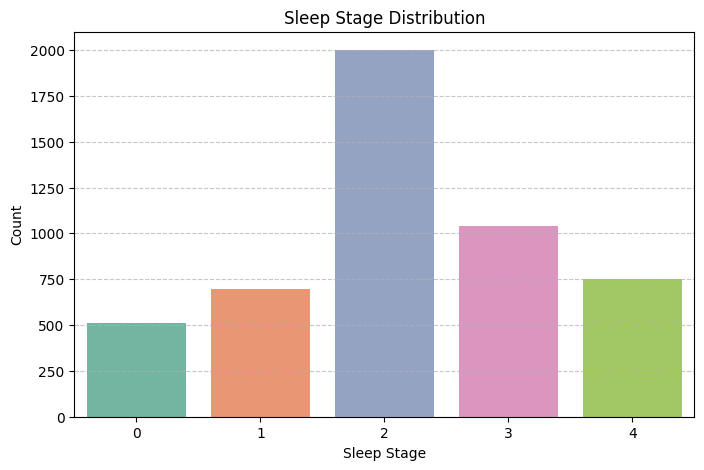

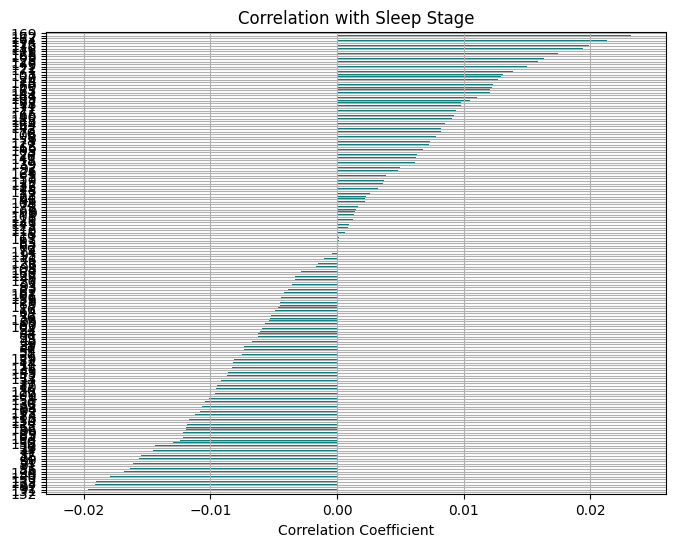

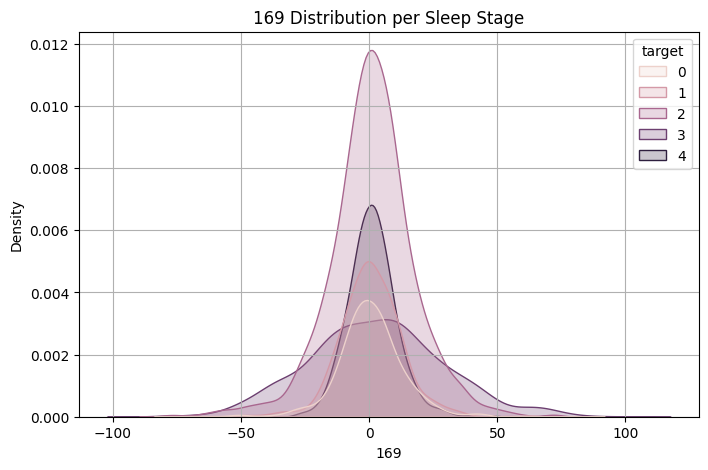

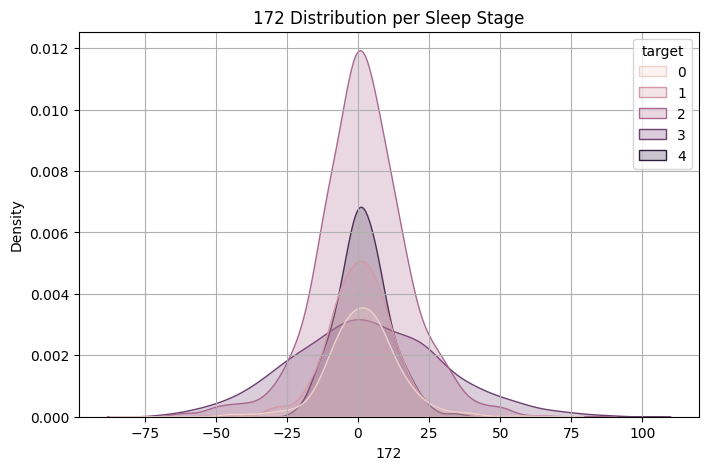

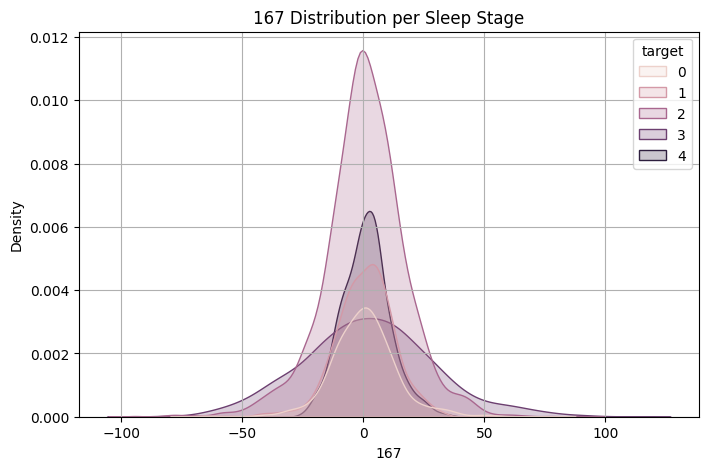

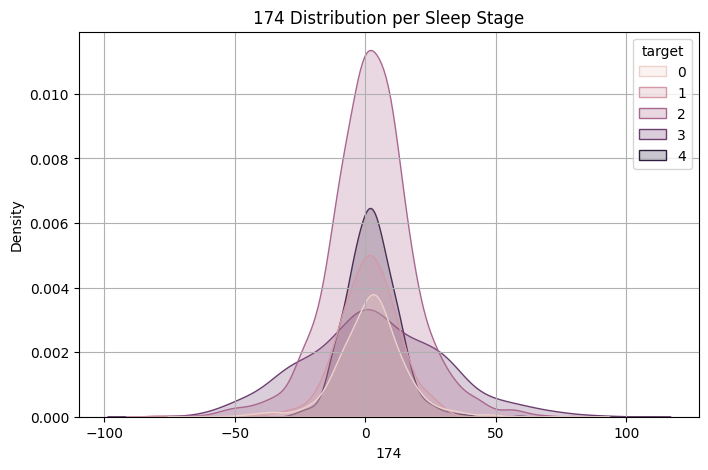

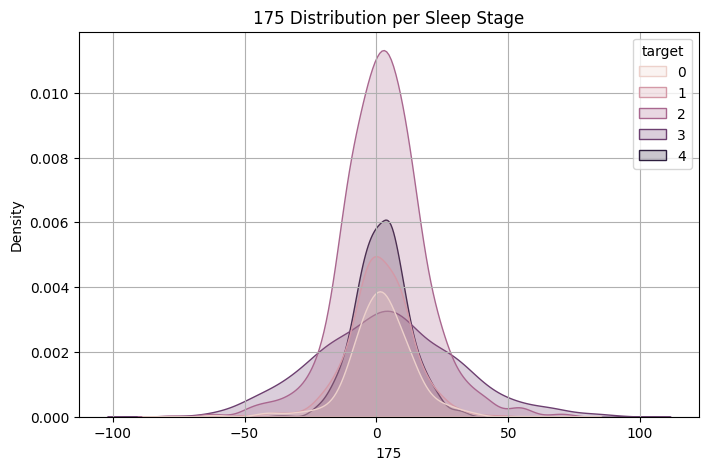

<Figure size 1500x200 with 0 Axes>

In [ ]:
# Assuming df is your dataframe and 'label' is your target column
explore_target(
    df=initial_dataset,
    target_col='target',
    class_for_examples='A',
    feature_cols=[i for i in range(1,179)]  # optional: select specific features to plot
)

We notice from the **Bar Chart** above that the classes are imbalance, and the majority class is third one **E2** ( non-rapid eye movement), this will be taken into consideration to be handled later on.

## 3.2. EDA for Features

**Helper functions to perform an EDA visualization for descriptive features**

In [ ]:
def plot_feature_distributions(df, num_features=None):
    print("\n[Exploration] Plotting feature distributions...")

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    features = numeric_cols if num_features is None else numeric_cols[:num_features]

    for feature in features:
        plt.figure(figsize=(14, 4))

        # Histogram + KDE
        plt.subplot(1, 2, 1)
        sns.histplot(df[feature], kde=True, bins=30, color='skyblue')
        plt.title(f'Histogram & KDE - {feature}')

        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[feature], color='lightgreen')
        plt.title(f'Box Plot - {feature}')

        plt.tight_layout()
        plt.show()


def analyze_features(df, threshold_skew=0.5):
    print("\n[Exploration] Analyzing feature skewness and outliers...")
    report = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        feature_data = df[col].dropna()
        sk = skew(feature_data)
        q1 = feature_data.quantile(0.25)
        q3 = feature_data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = ((feature_data < lower_bound) | (feature_data > upper_bound)).sum()
        if abs(sk) < threshold_skew:
            skew_type = "Normal"
        elif sk > 0:
            skew_type = "Right-skewed"
        else:
            skew_type = "Left-skewed"
        report.append({
            'Feature': col,
            'Skewness': round(sk, 2),
            'Distribution': skew_type,
            'Outliers': outliers,
            'Outlier %': round(outliers / len(feature_data) * 100, 2)
        })
    summary_df = pd.DataFrame(report)
    print(summary_df)
    return summary_df

def plot_correlation_heatmap(df, method='pearson', figsize=(15, 12), threshold=0.9):
    print("\n[Exploration] Correlation heatmap and high correlation pairs...")
    corr = df.corr(method=method)
    plt.figure(figsize=figsize)
    sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt=".2f")
    plt.title(f'{method.capitalize()} Correlation Heatmap')
    plt.show()
    high_corr = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                high_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))
    if high_corr:
        print("\nHighly Correlated Pairs (|corr| > {:.2f}):".format(threshold))
        for col1, col2, val in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
            print(f"{col1} <--> {col2} : {val:.2f}")
    else:
        print("\nNo highly correlated pairs found above threshold.")

def run_eda_visualization (df):
    print("\n========== EXPLORATORY DATA ANALYSIS ==========")
    plot_feature_distributions(df, num_features=5)
    analyze_features(df)
    plot_correlation_heatmap(df)

**Visualizing descriptive features distribution and box-plot**


========== EXPLORATORY DATA ANALYSIS ==========

[Exploration] Plotting feature distributions...


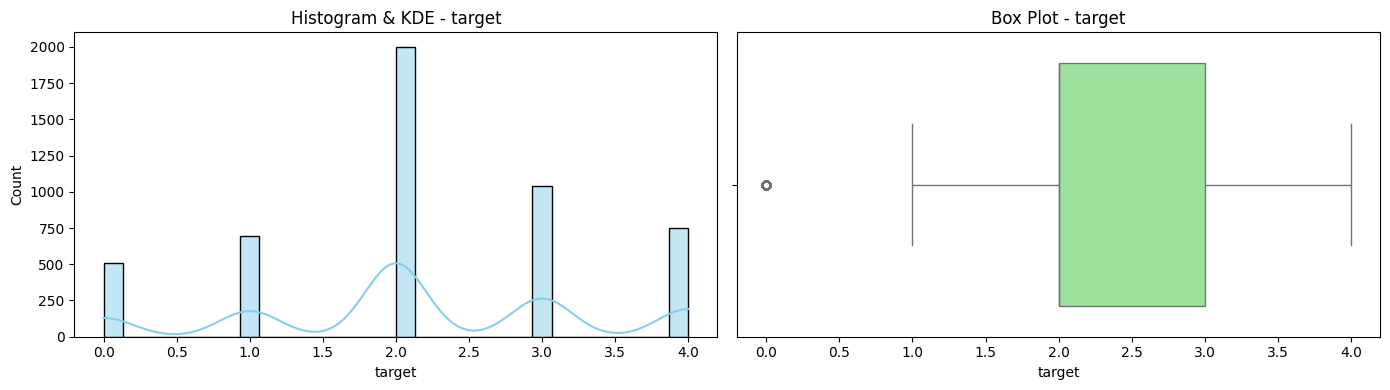

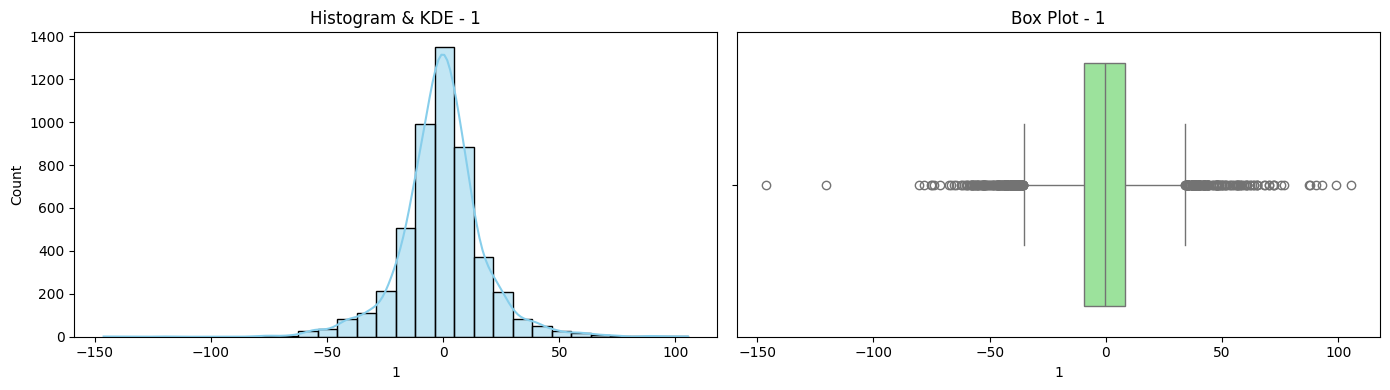

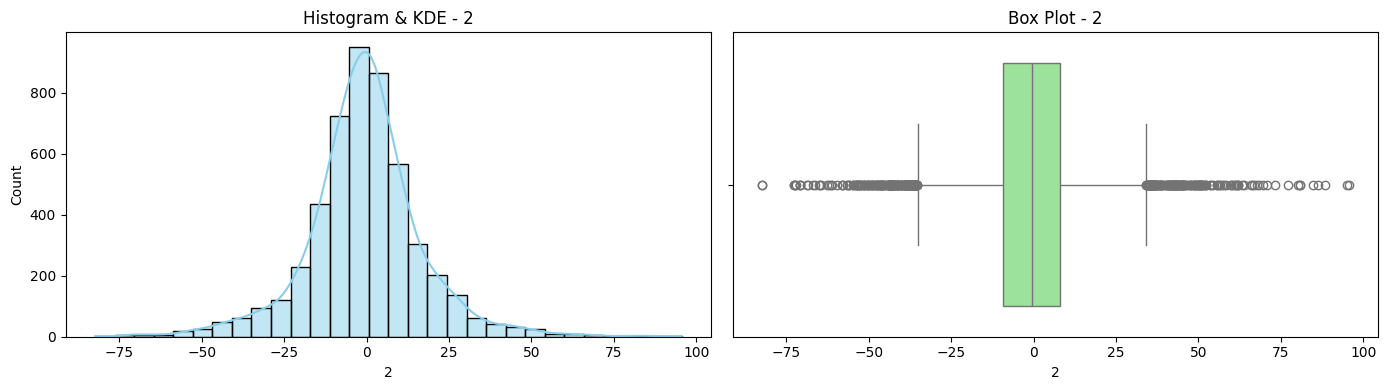

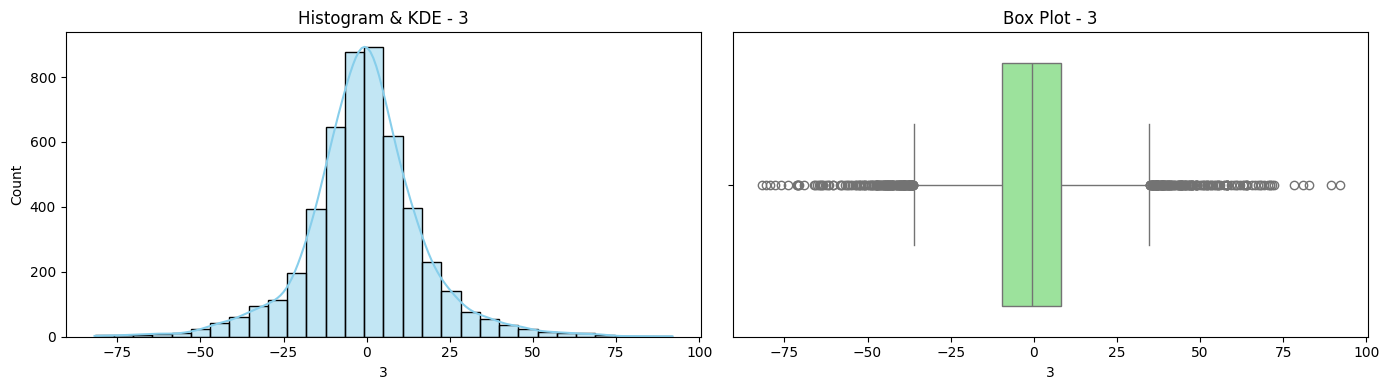

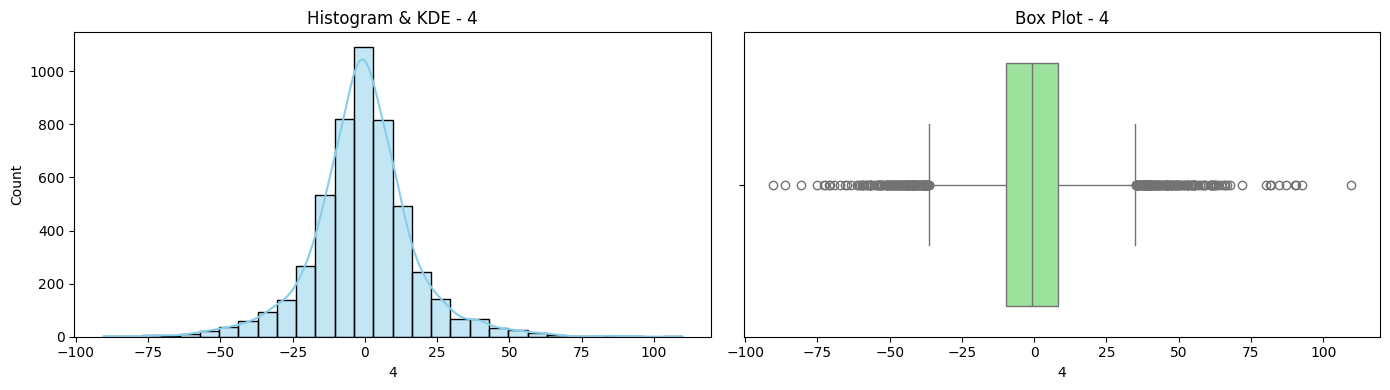

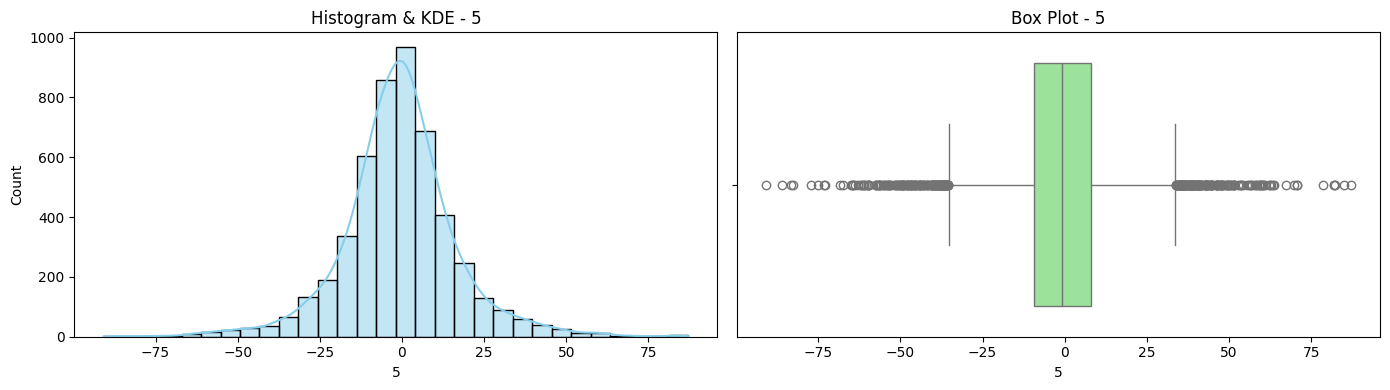

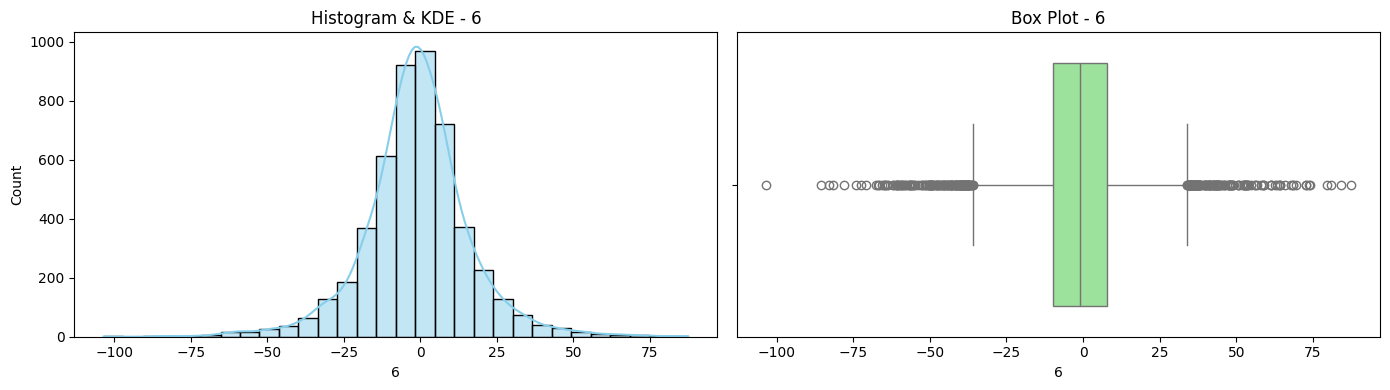

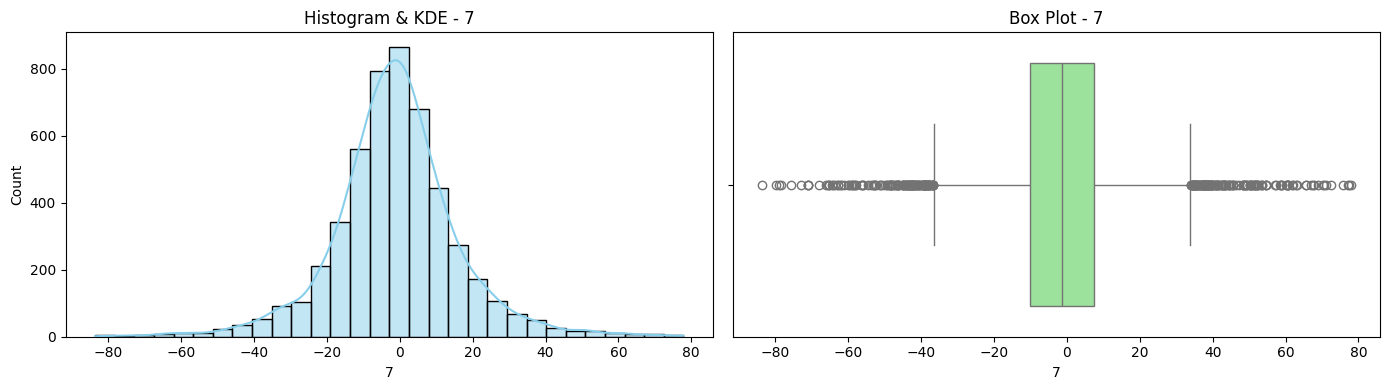

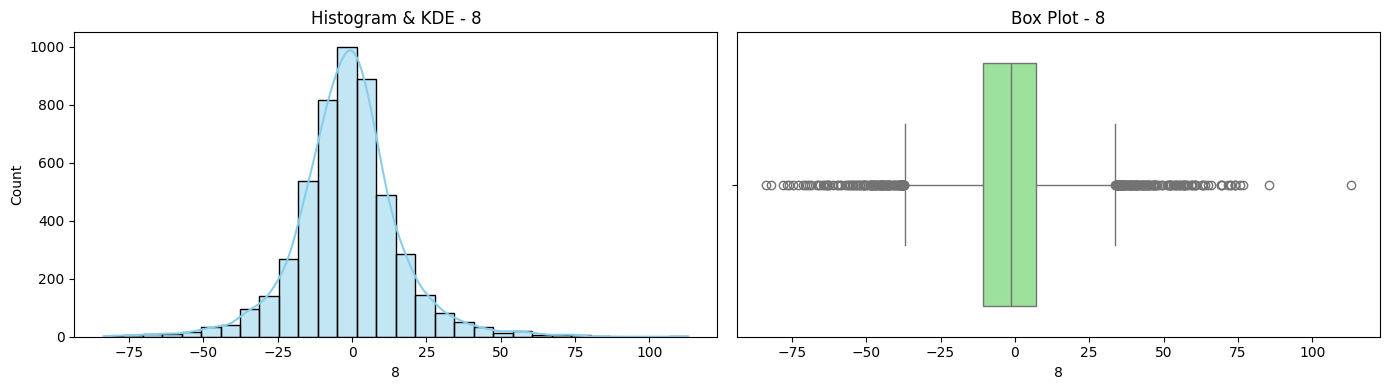

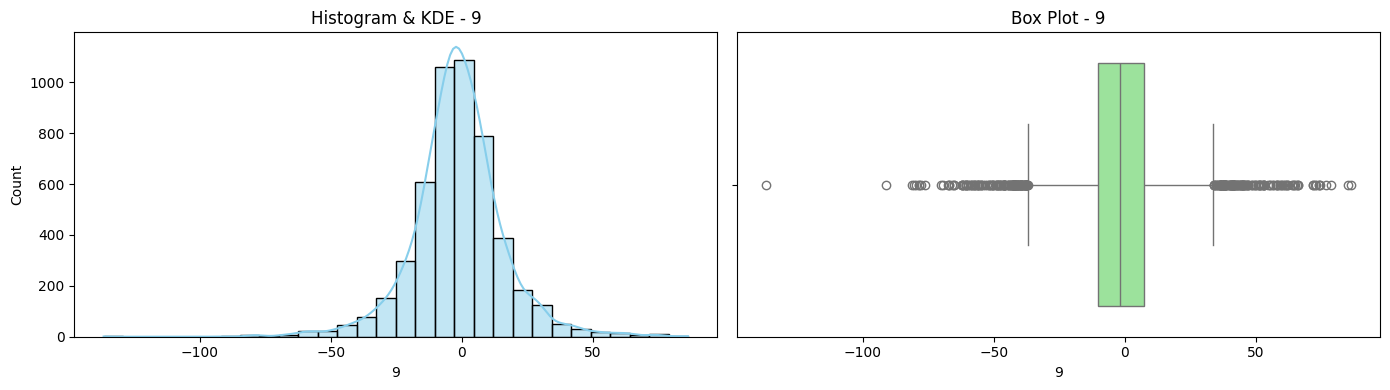

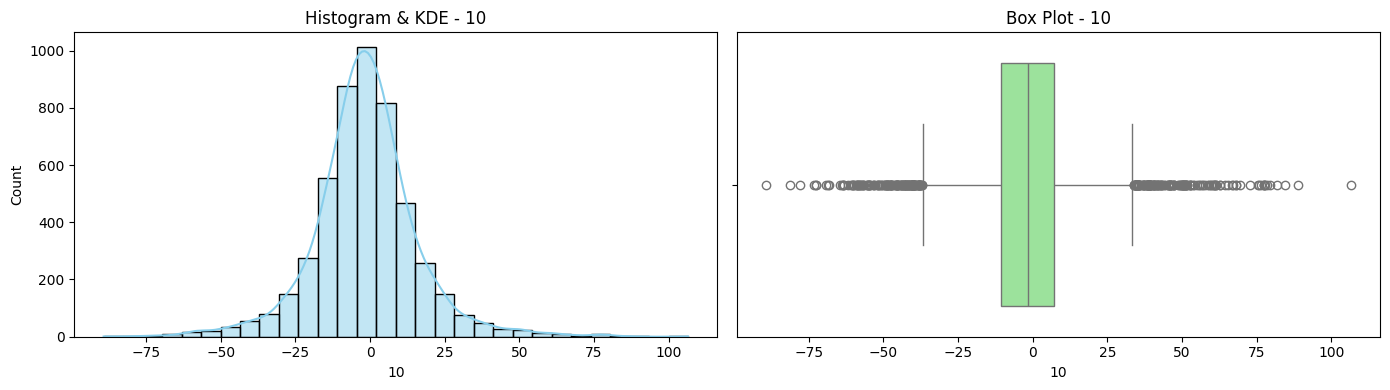

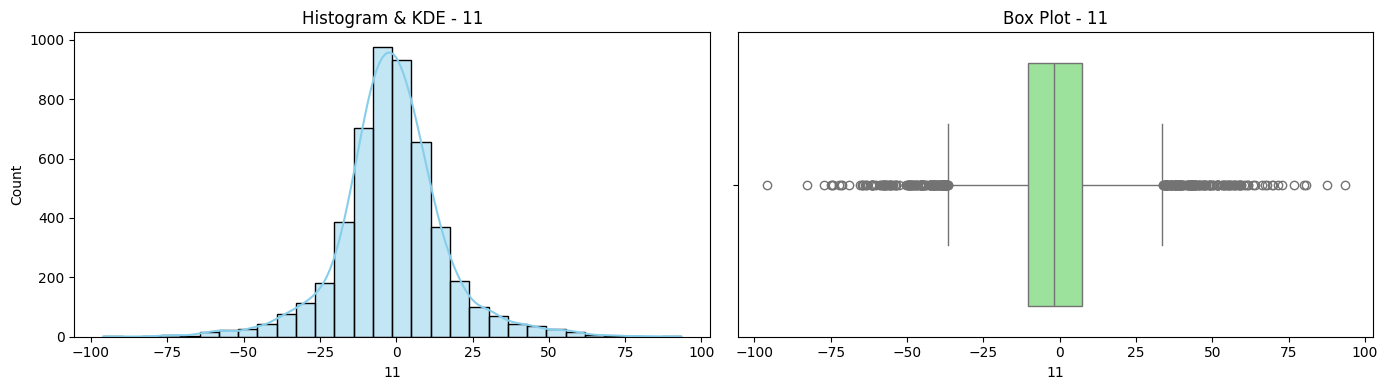

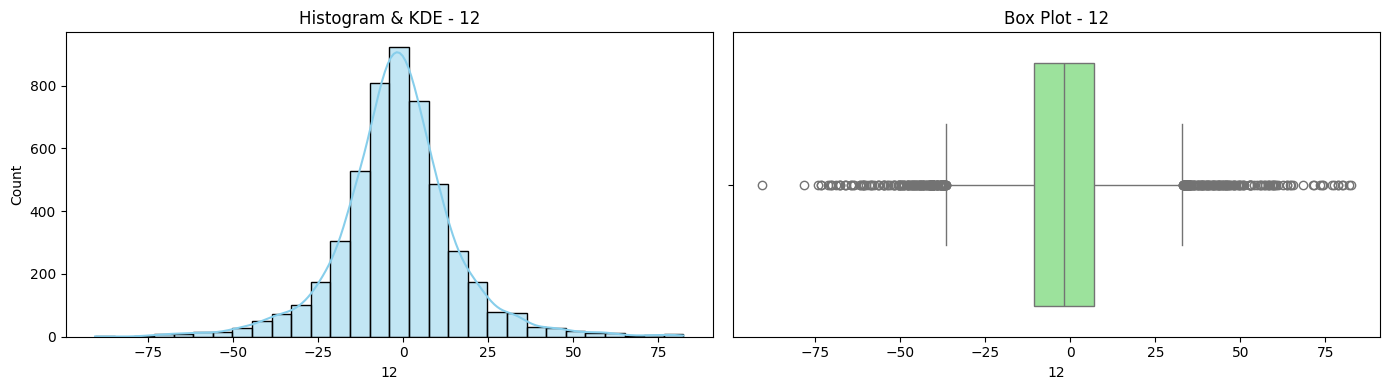

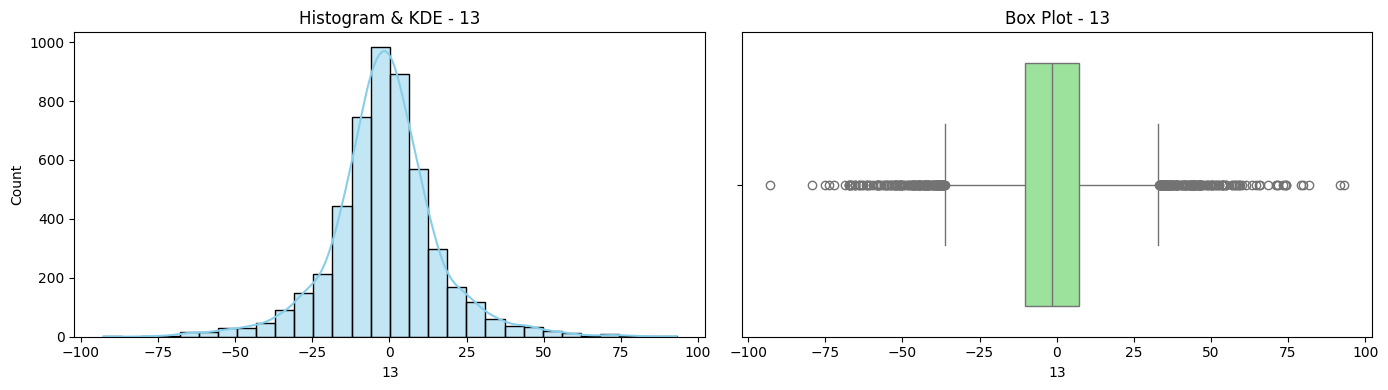

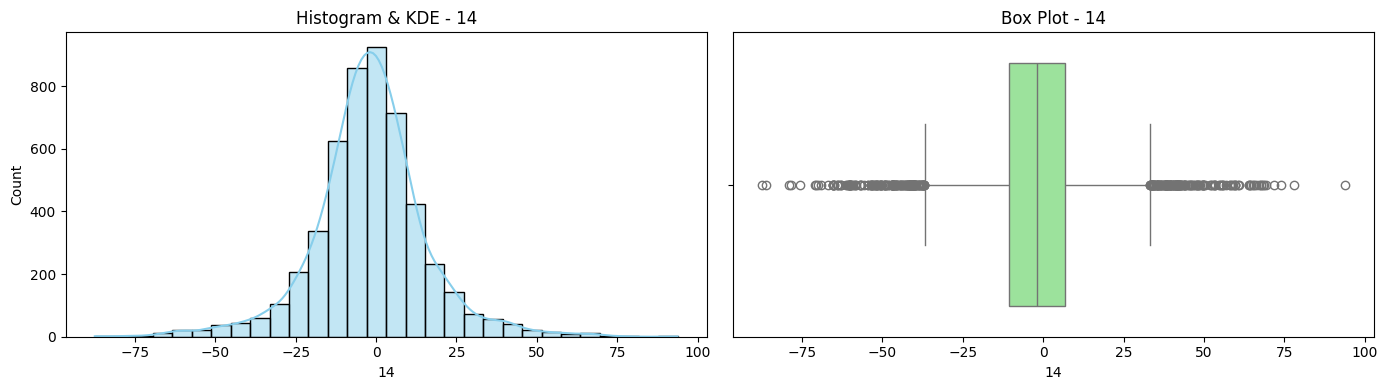

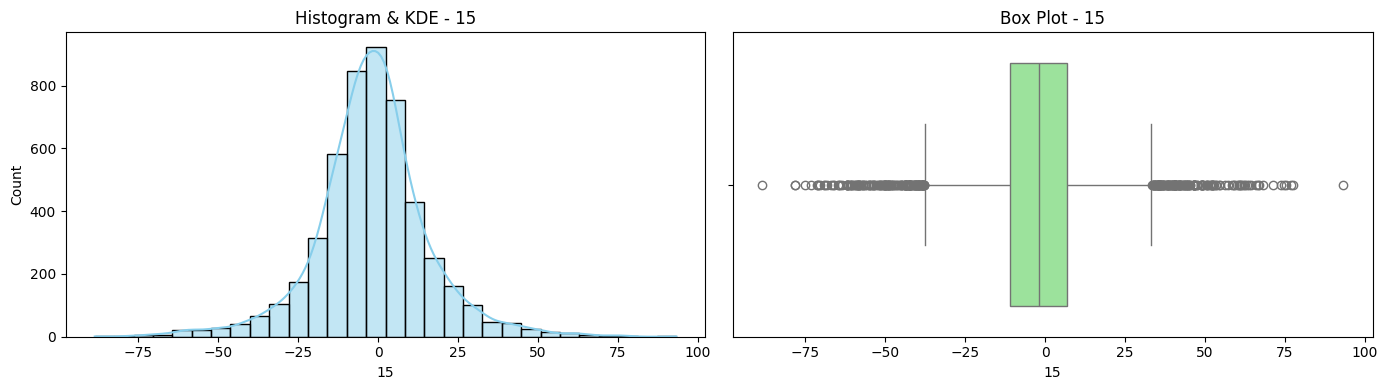

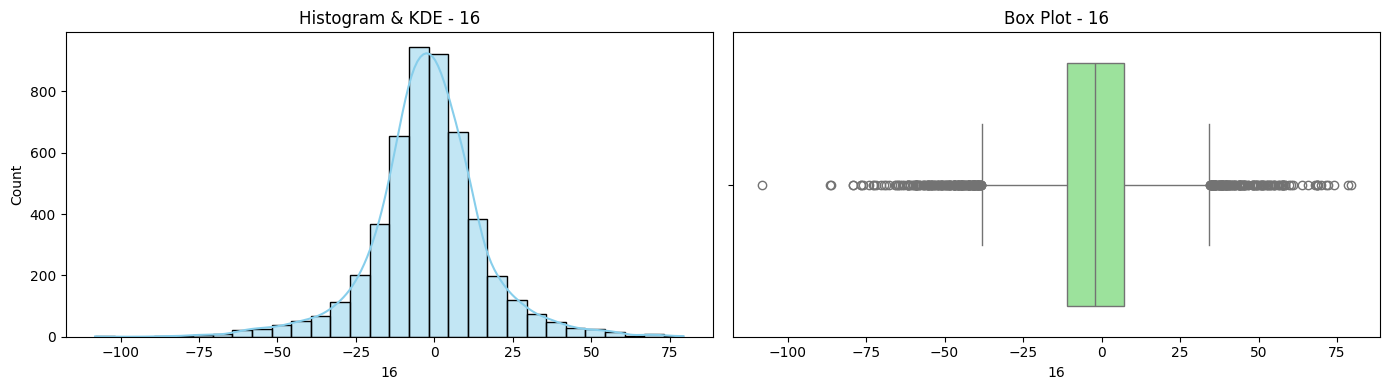

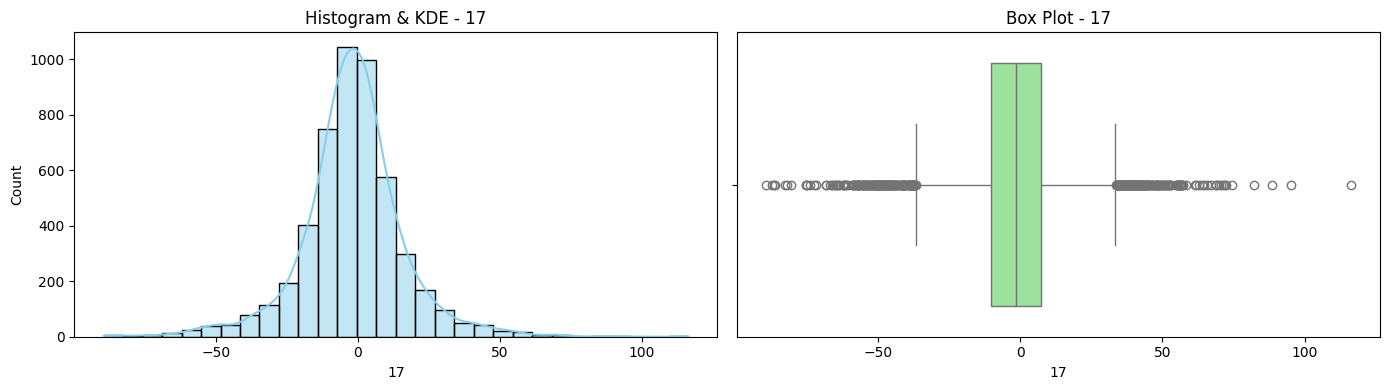

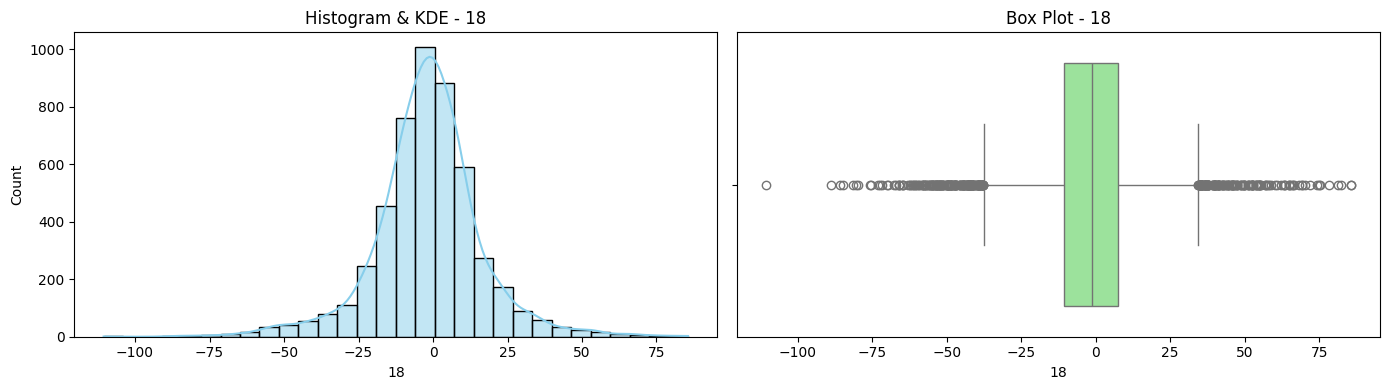

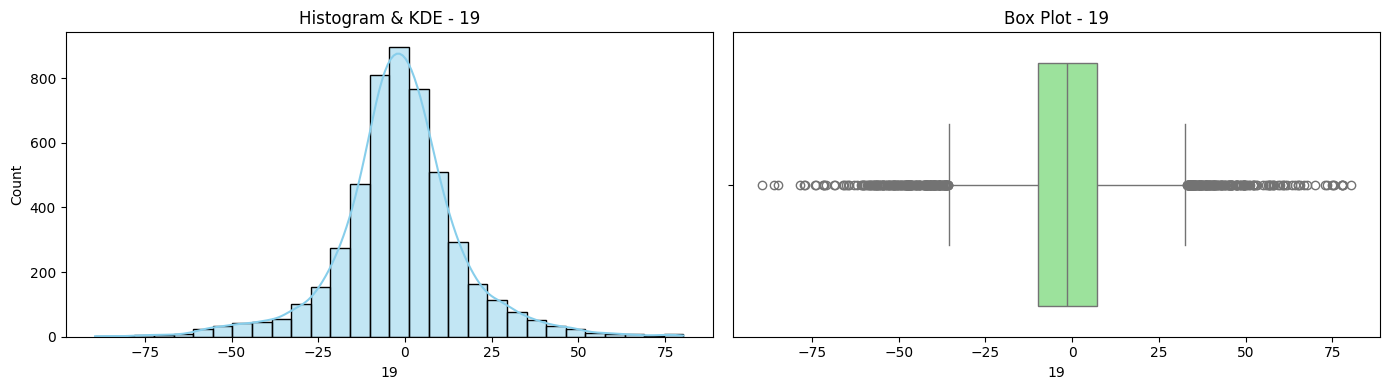

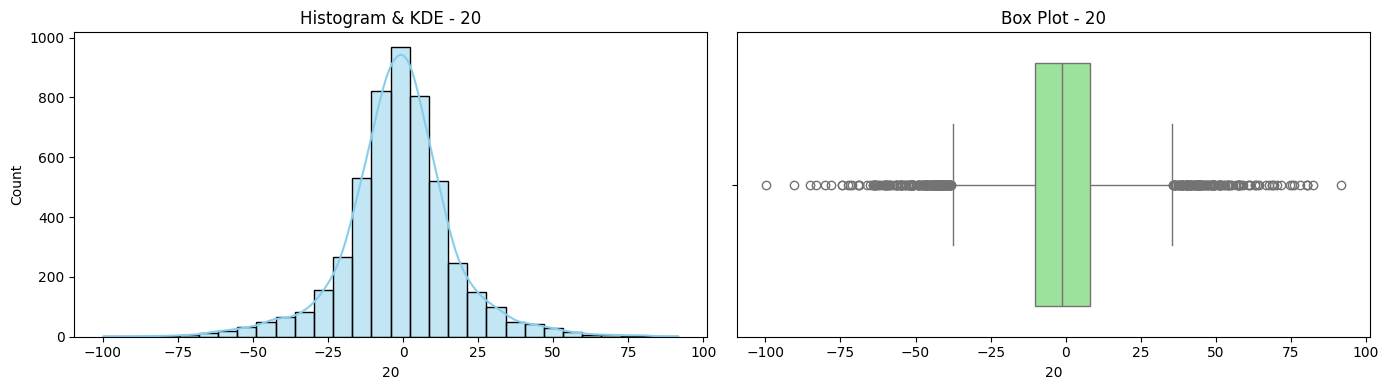

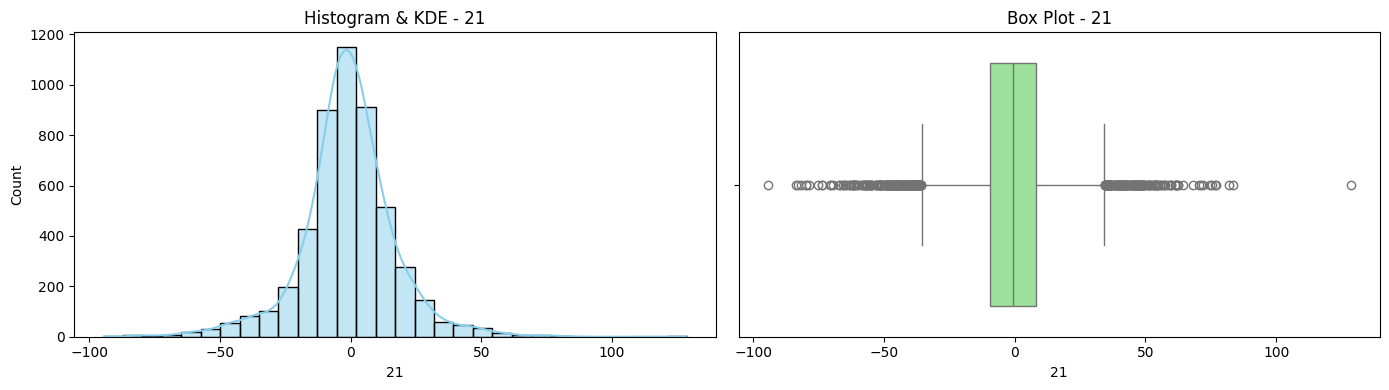

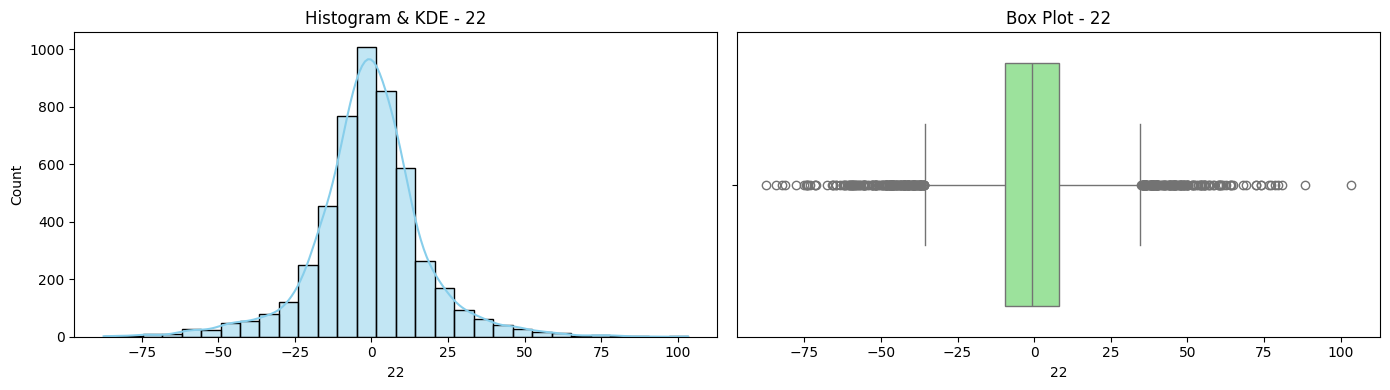

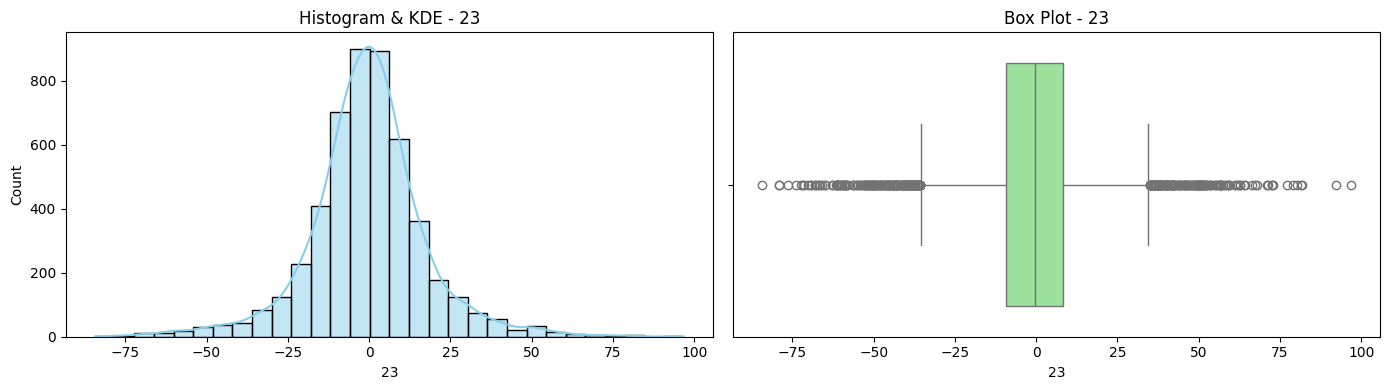

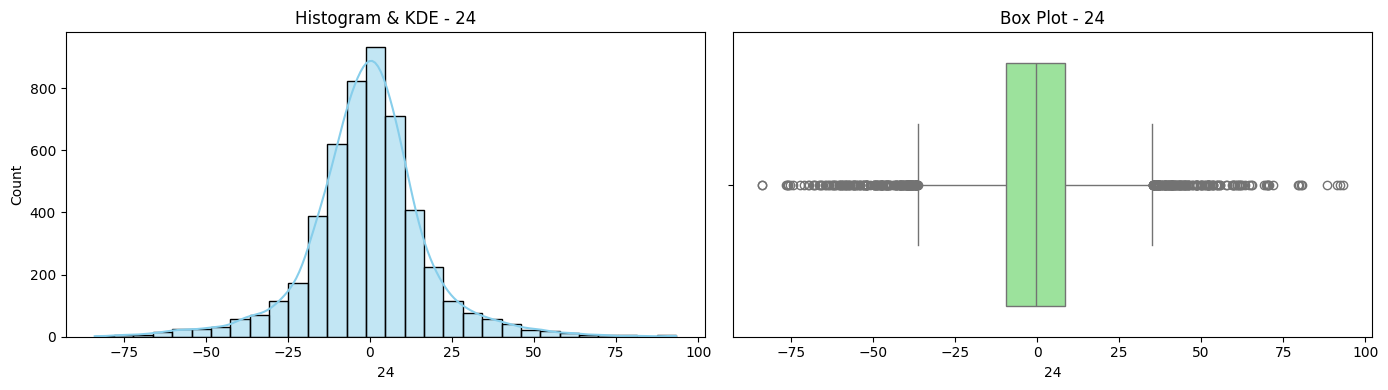

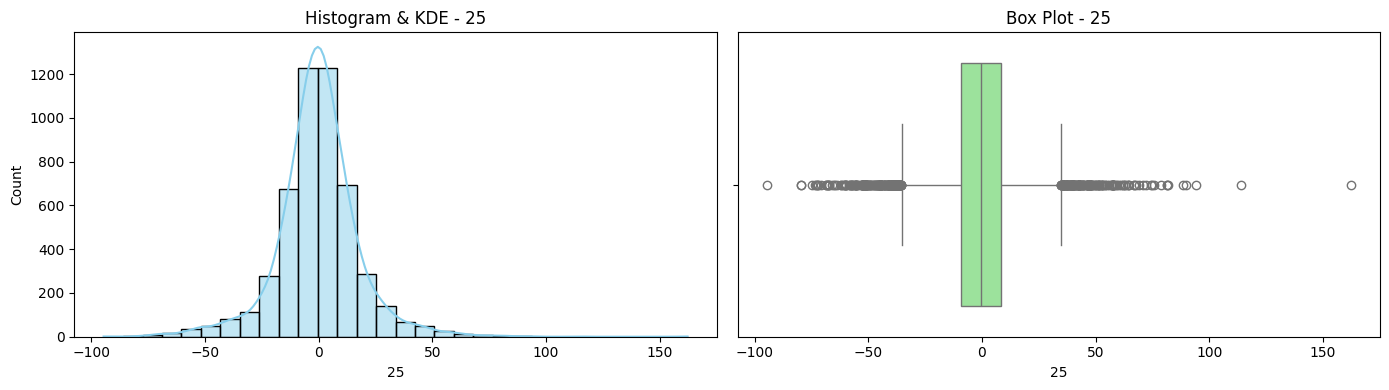

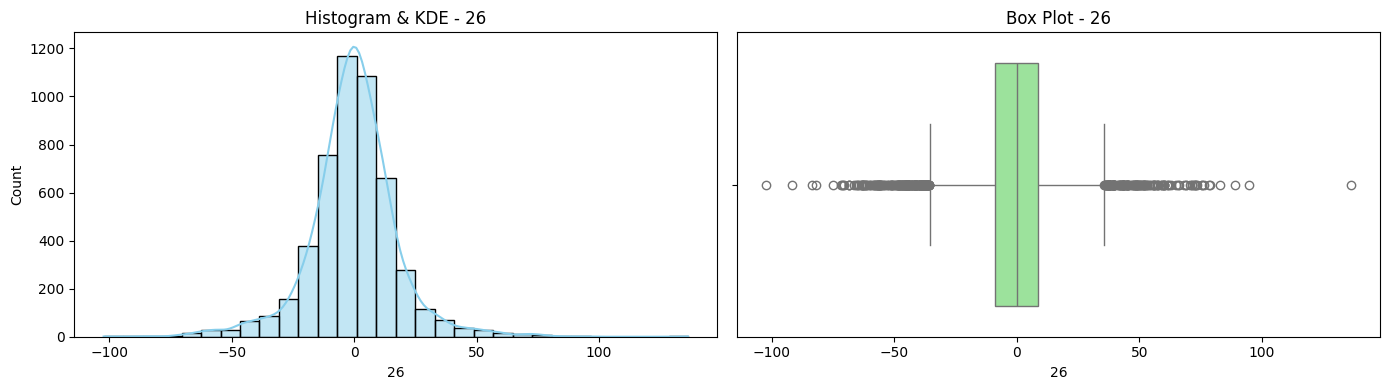

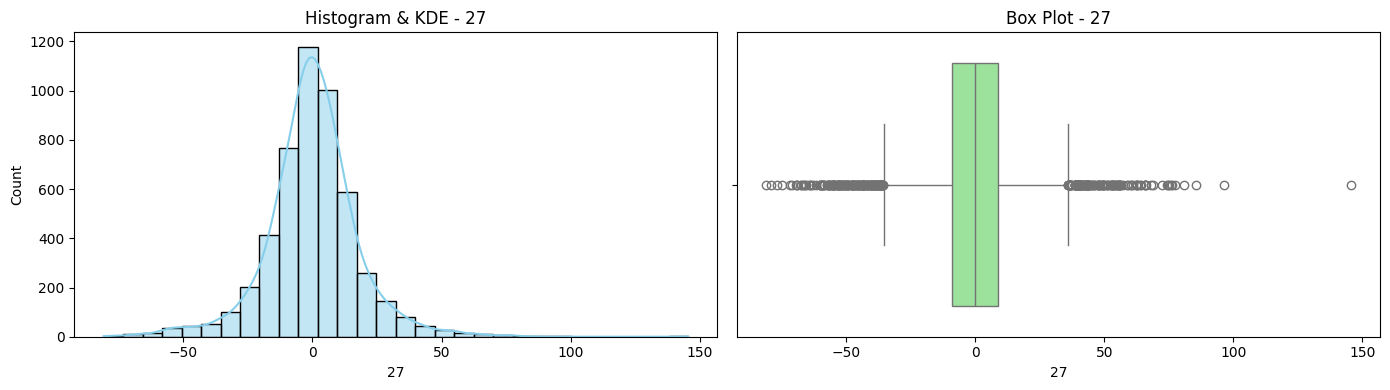

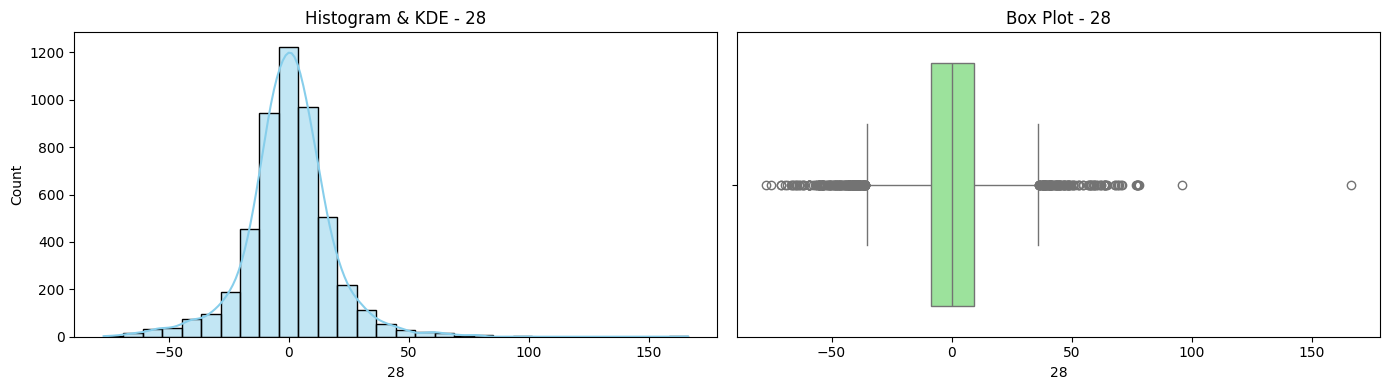

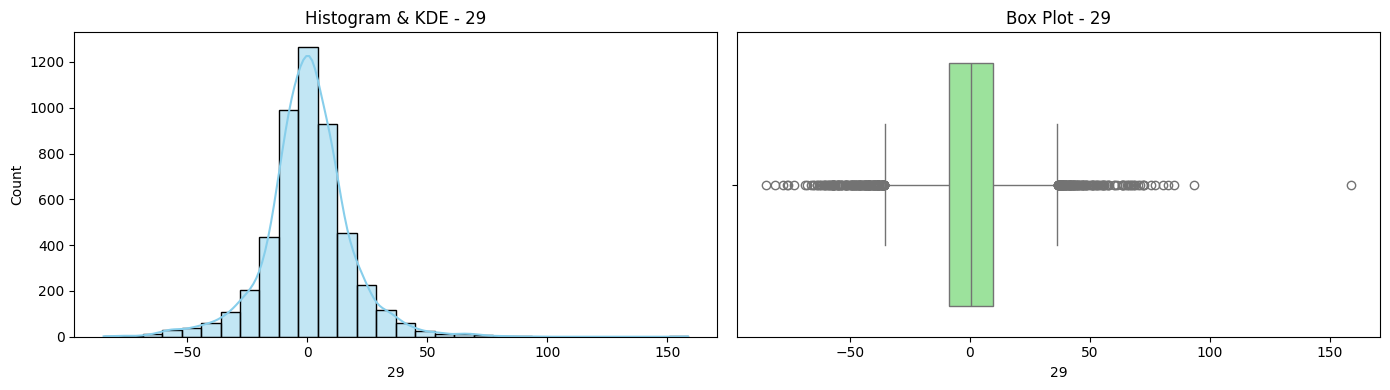

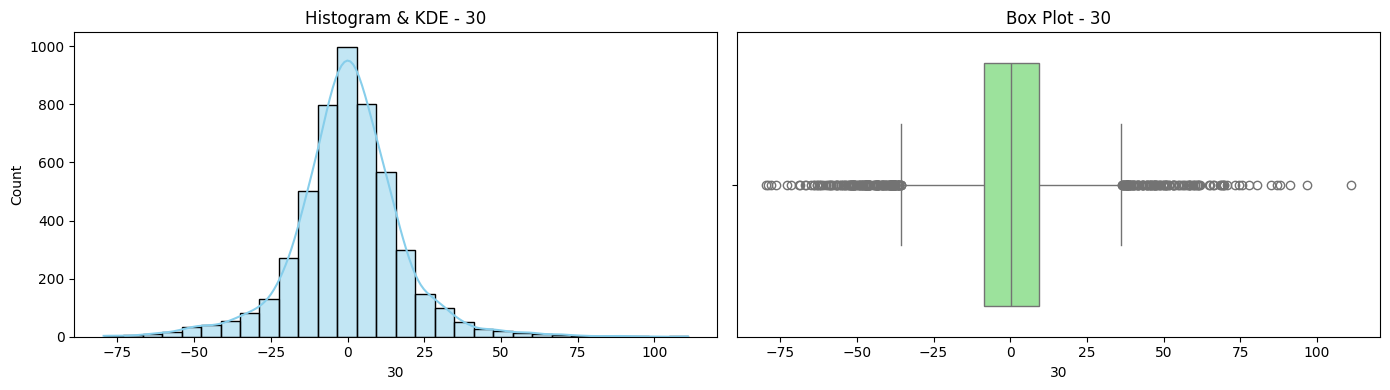

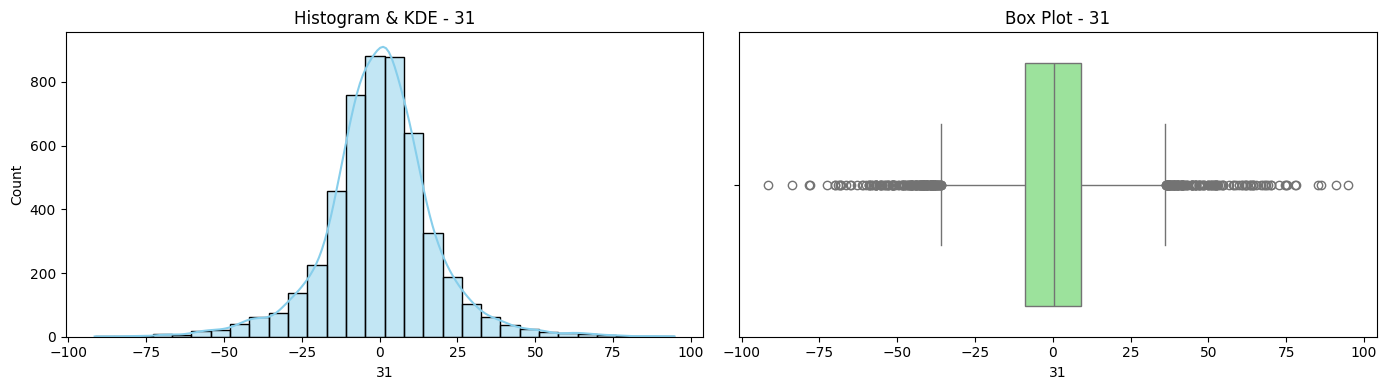

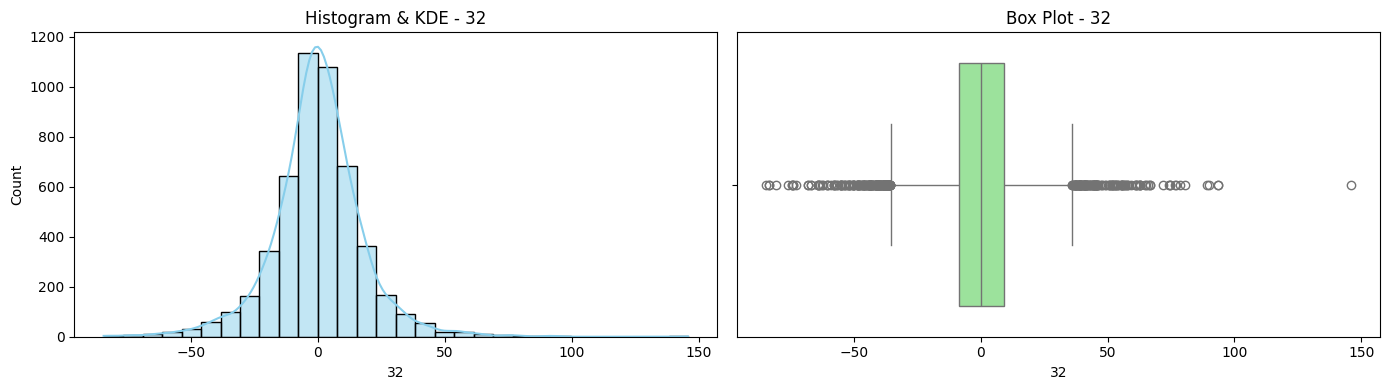

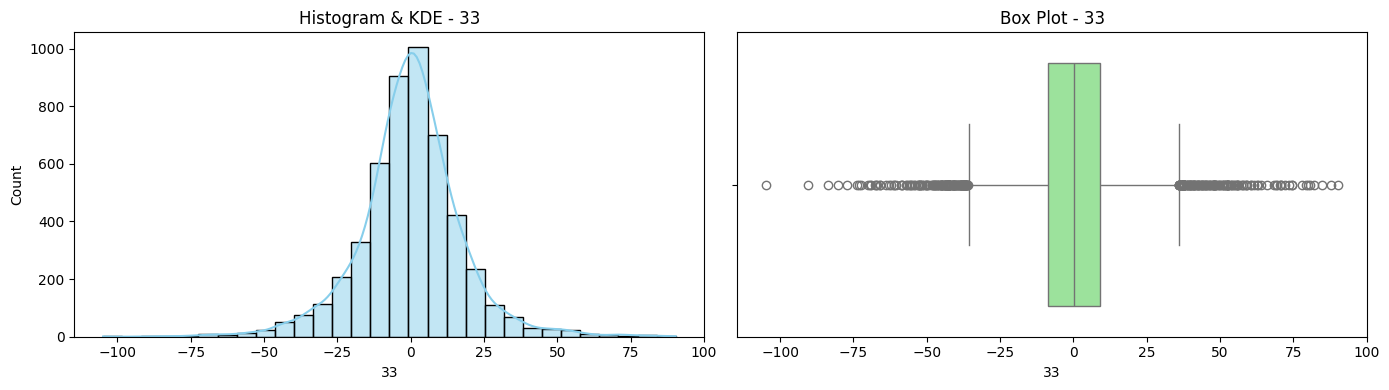

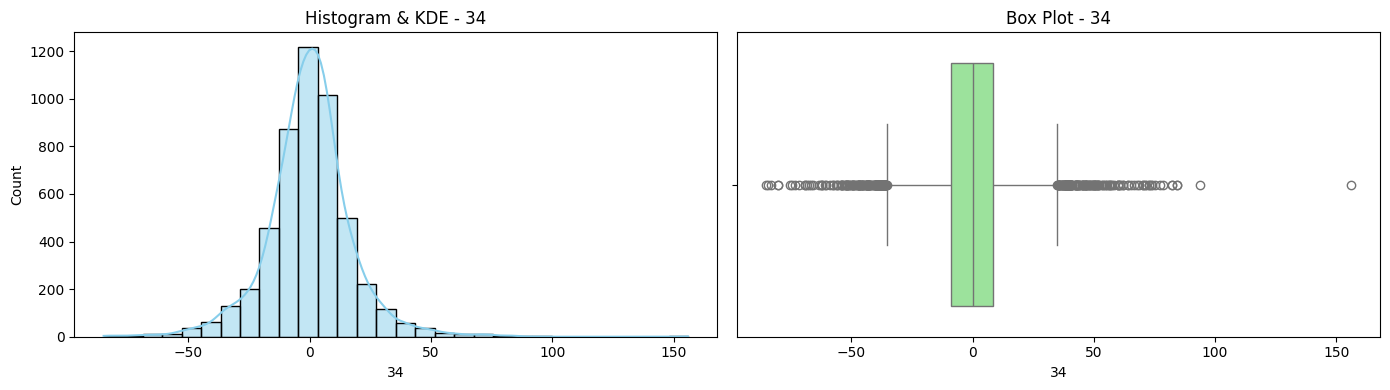

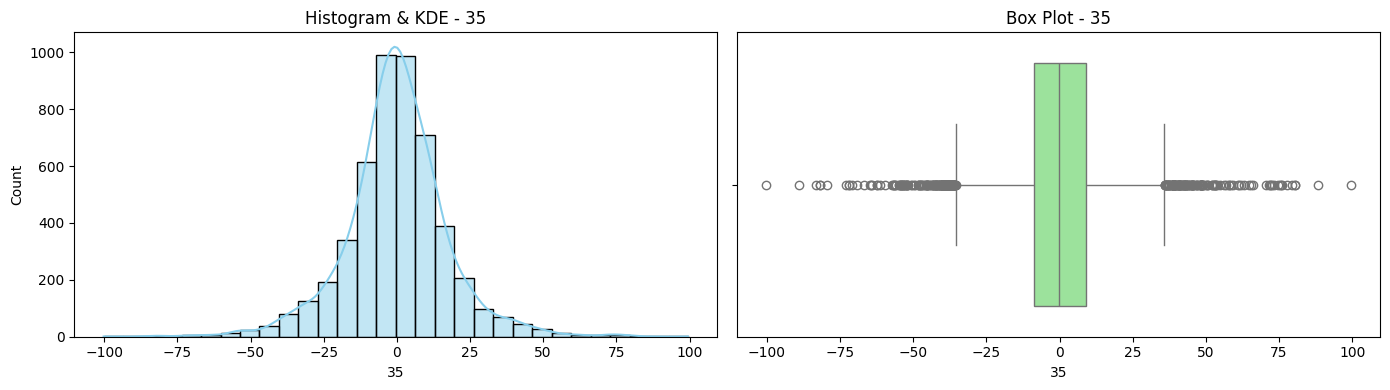

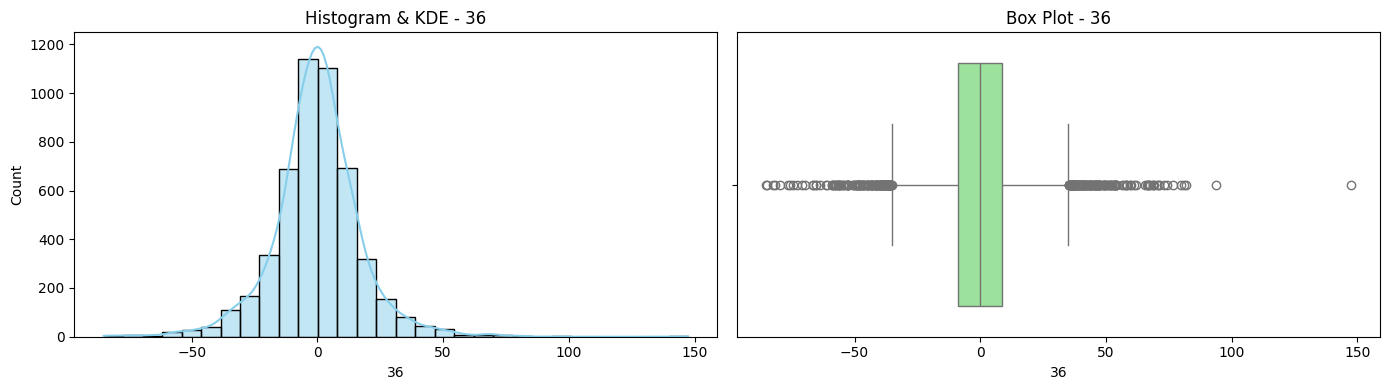

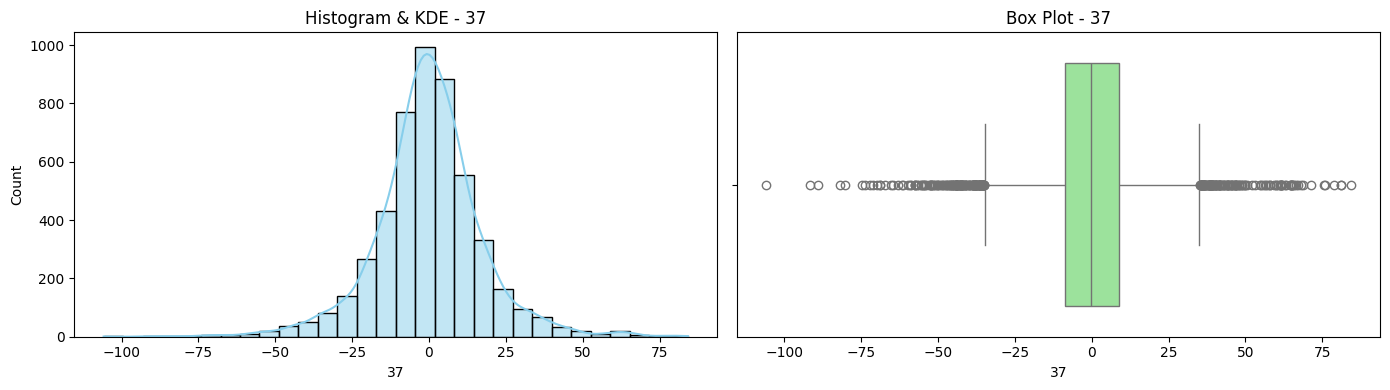

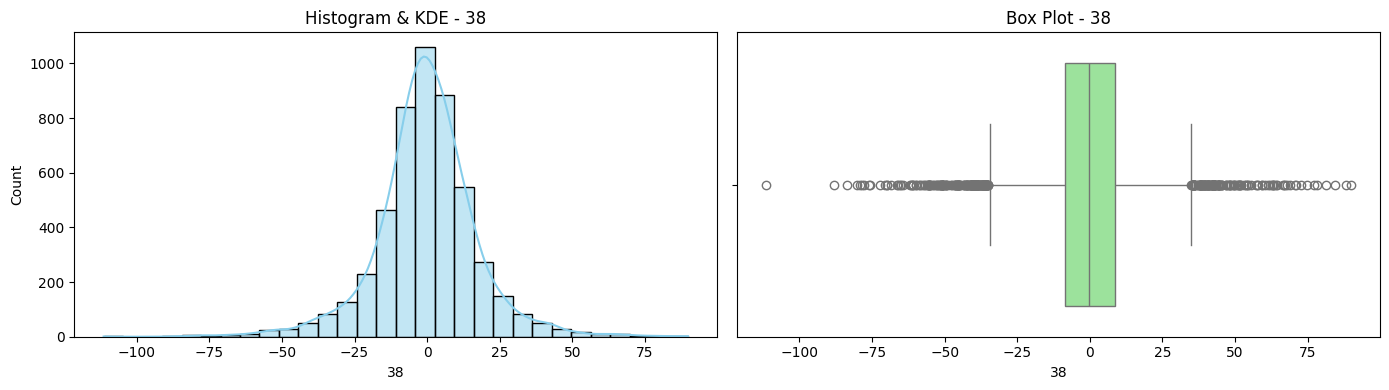

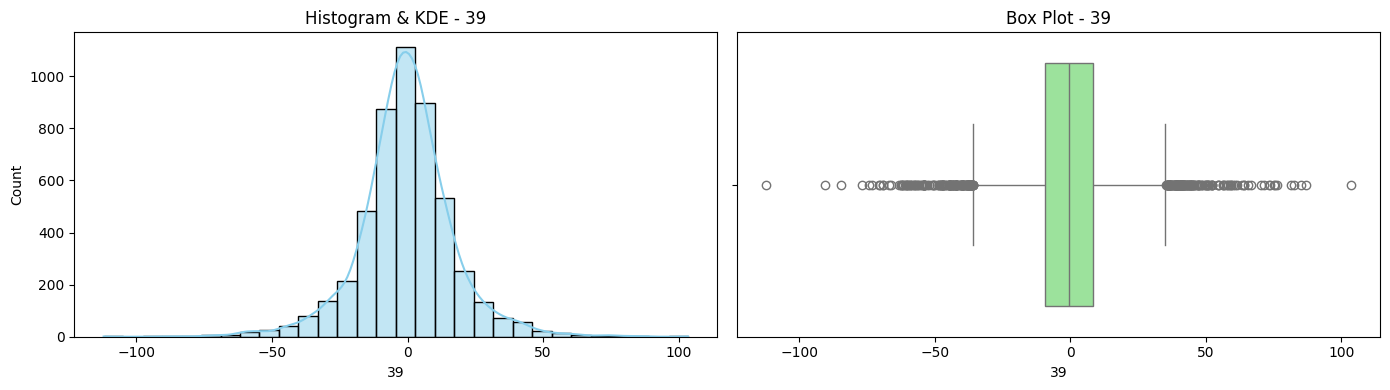

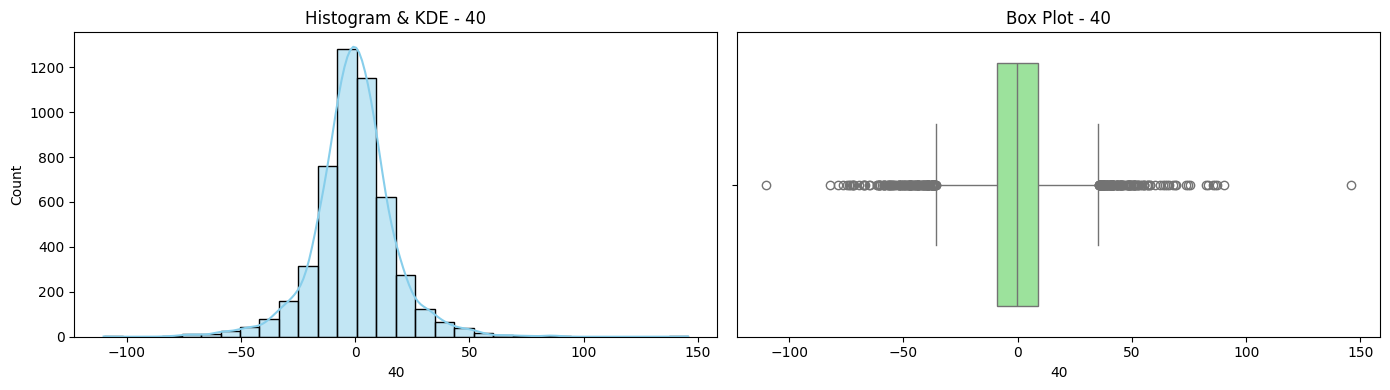

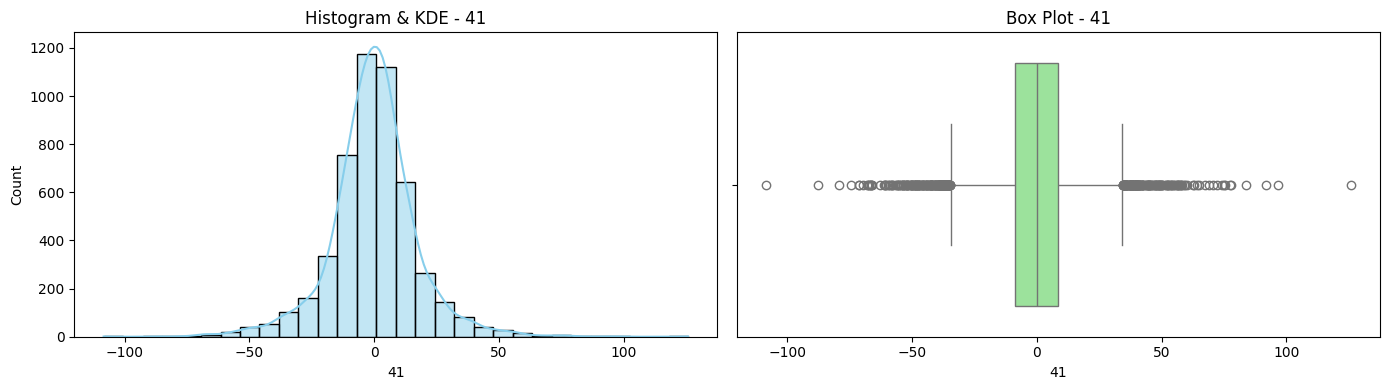

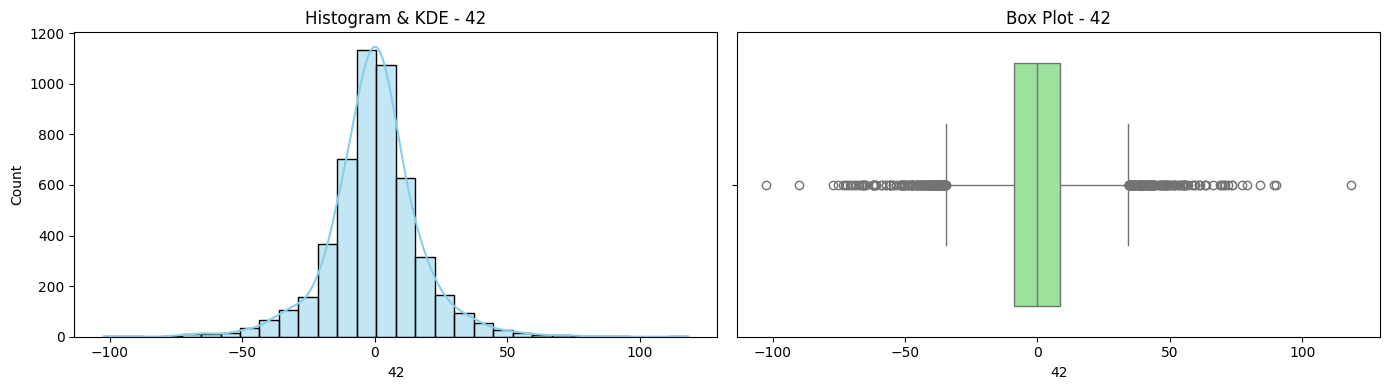

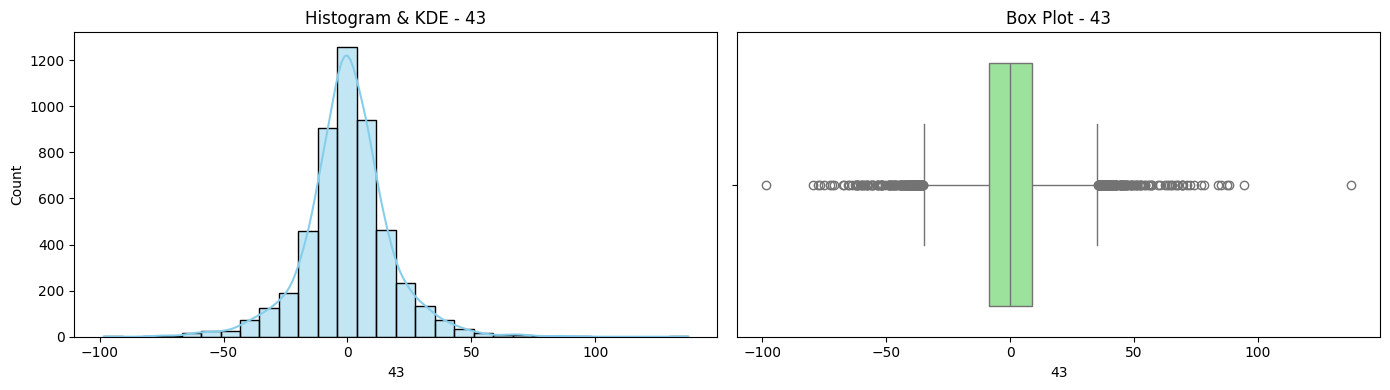

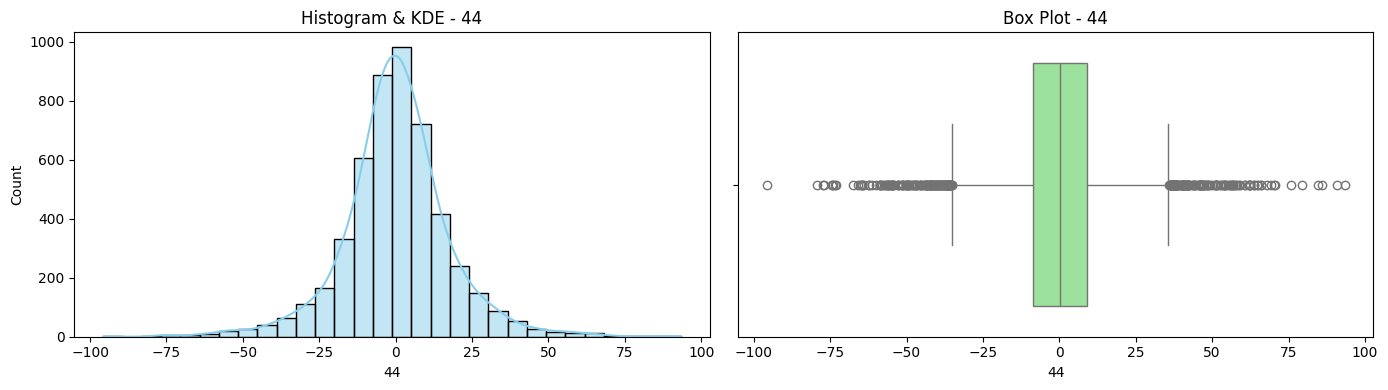

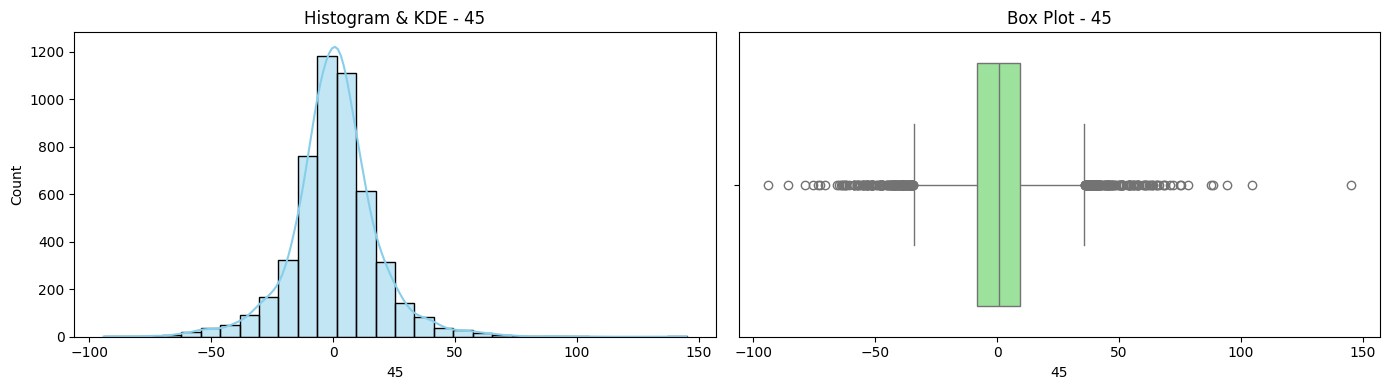

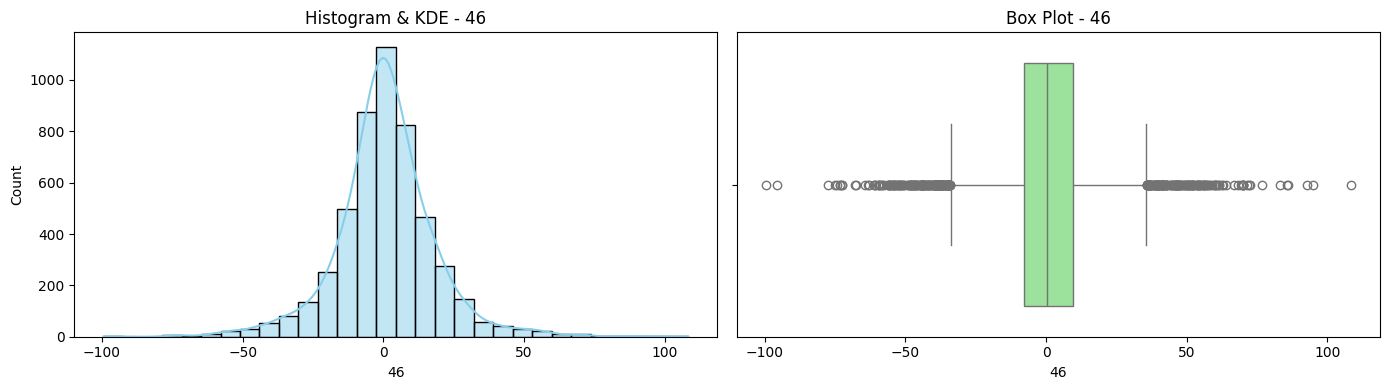

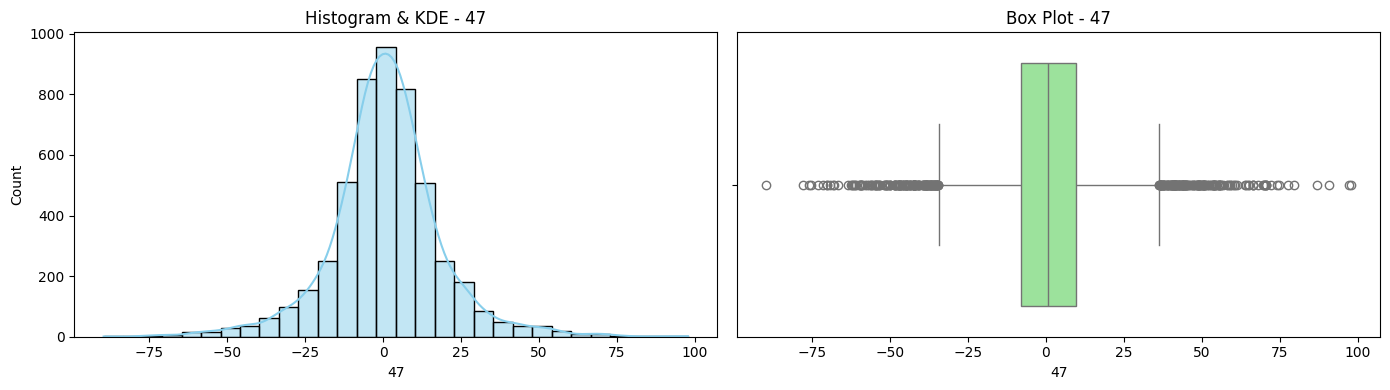

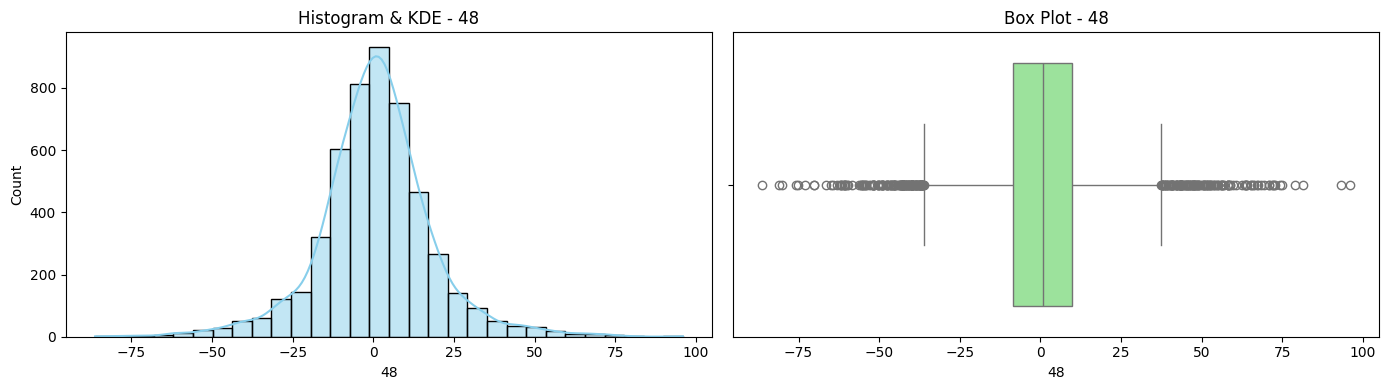

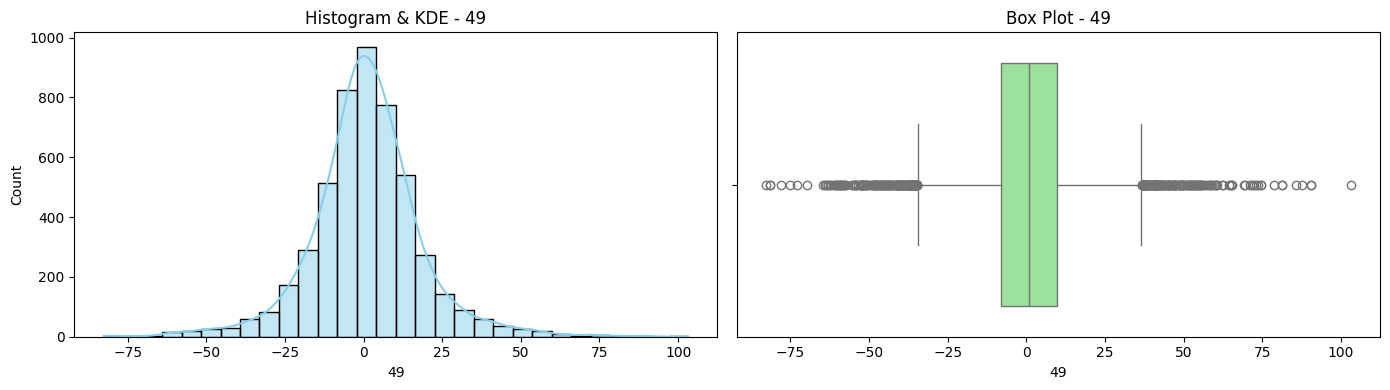

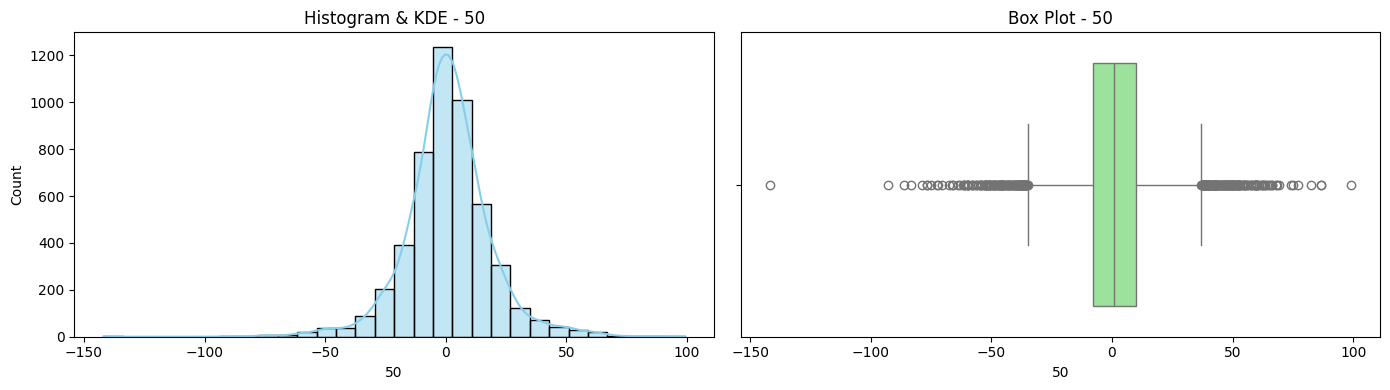

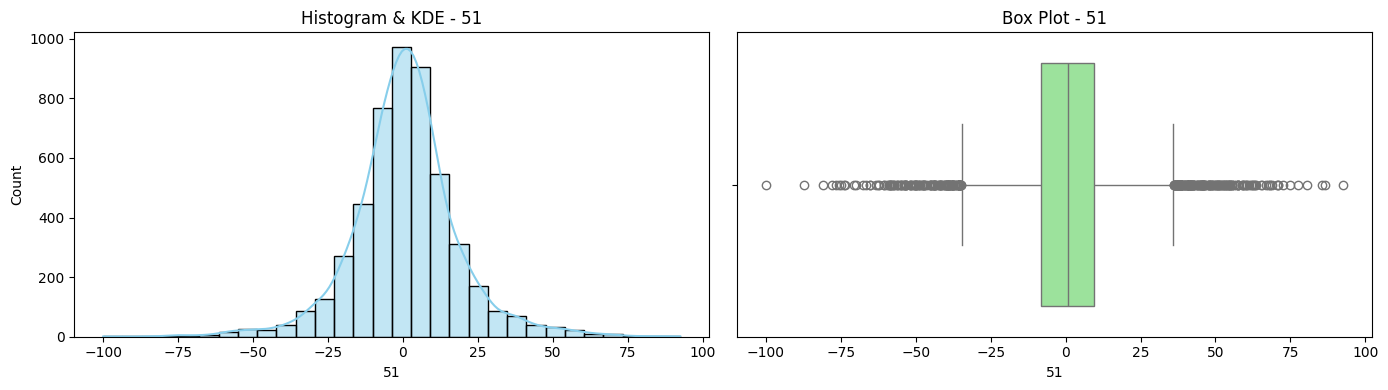

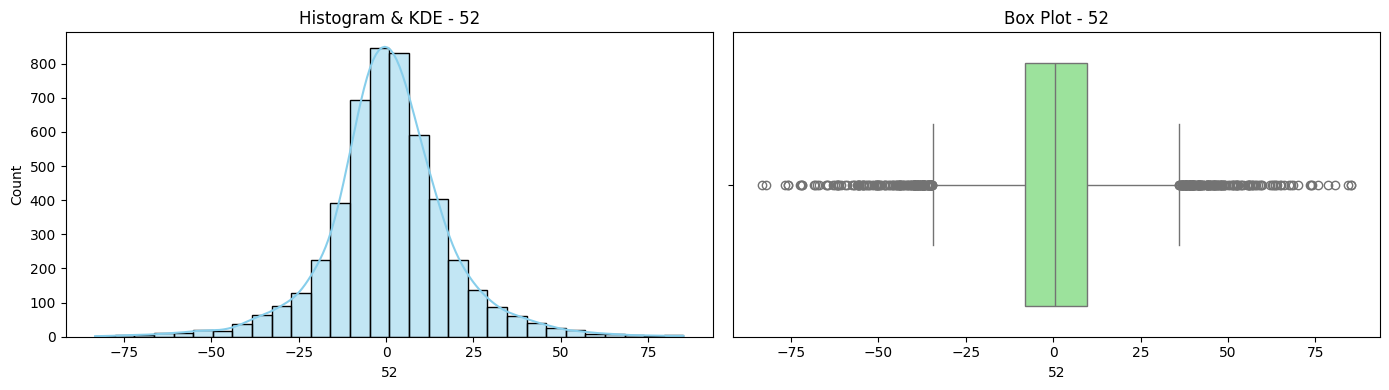

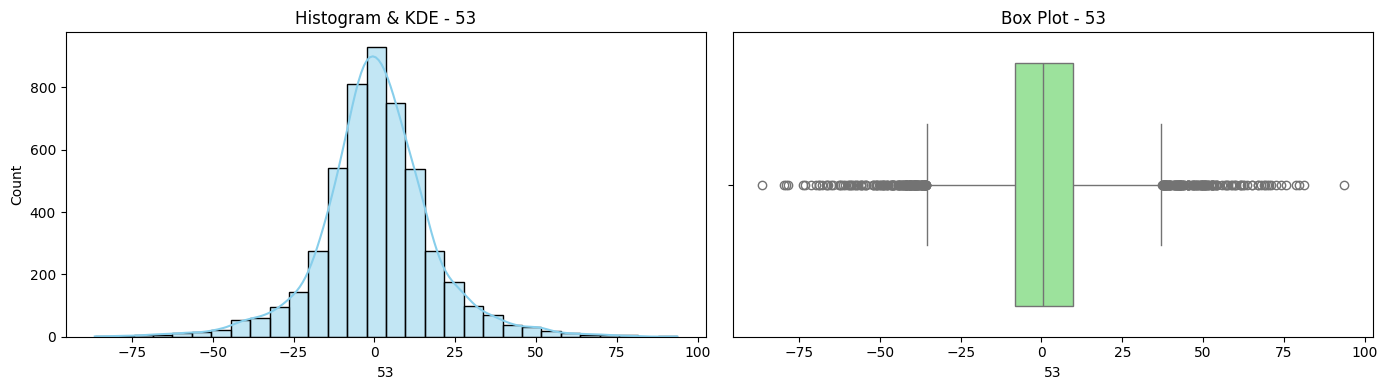

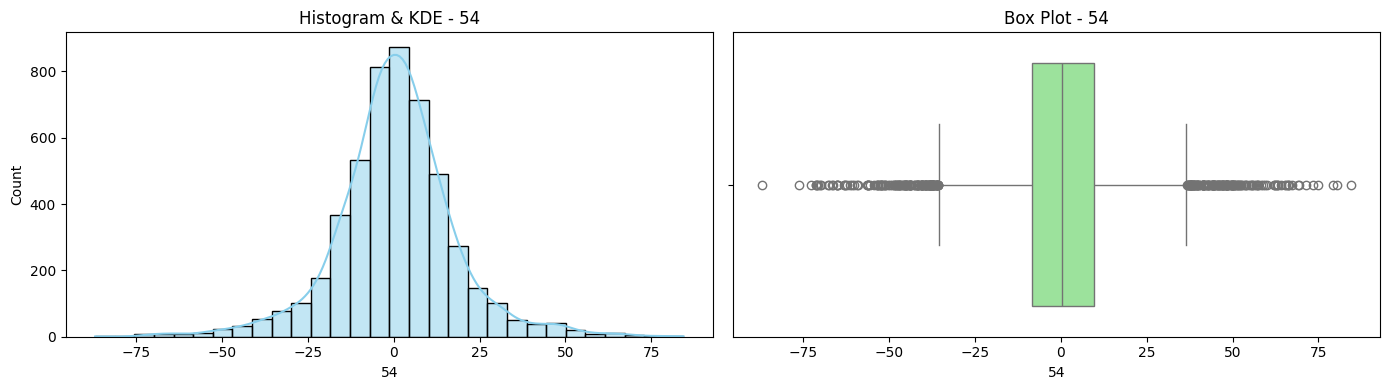

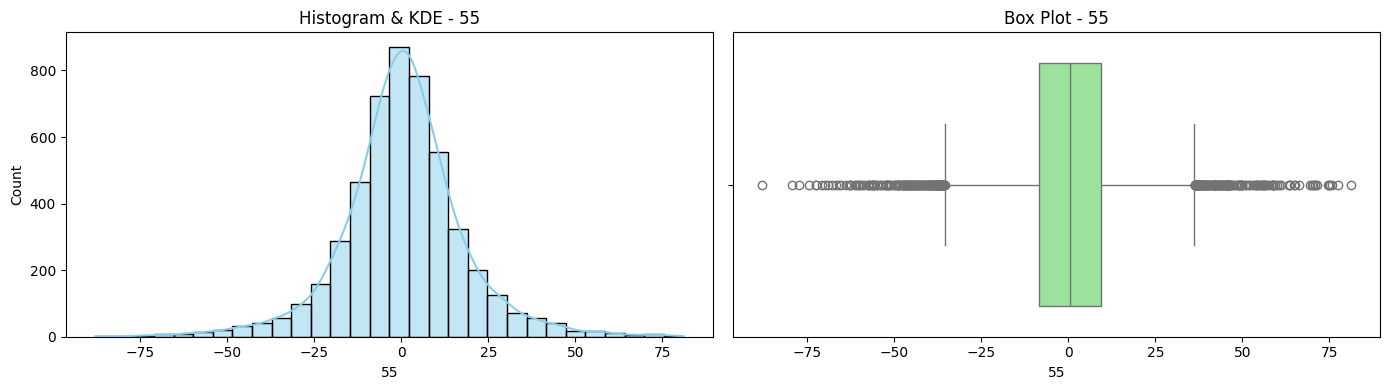

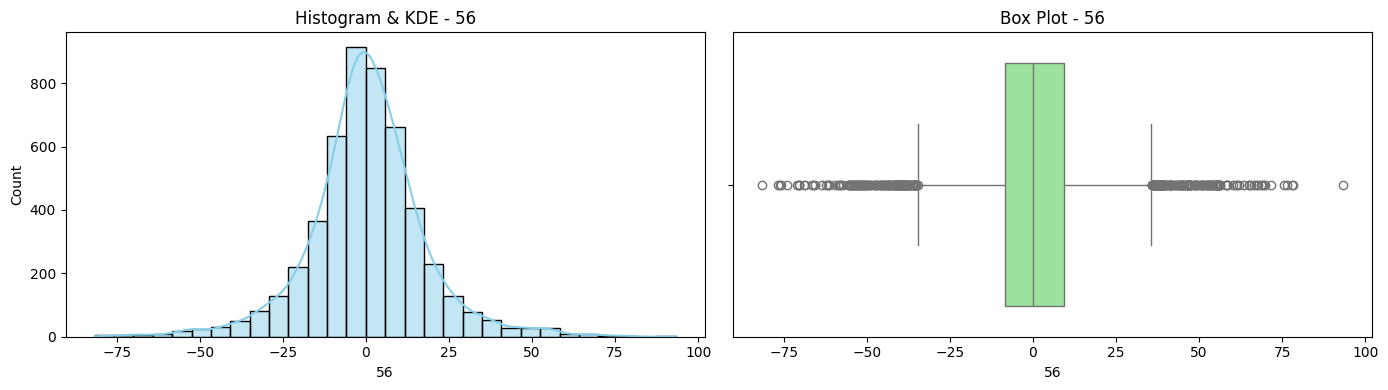

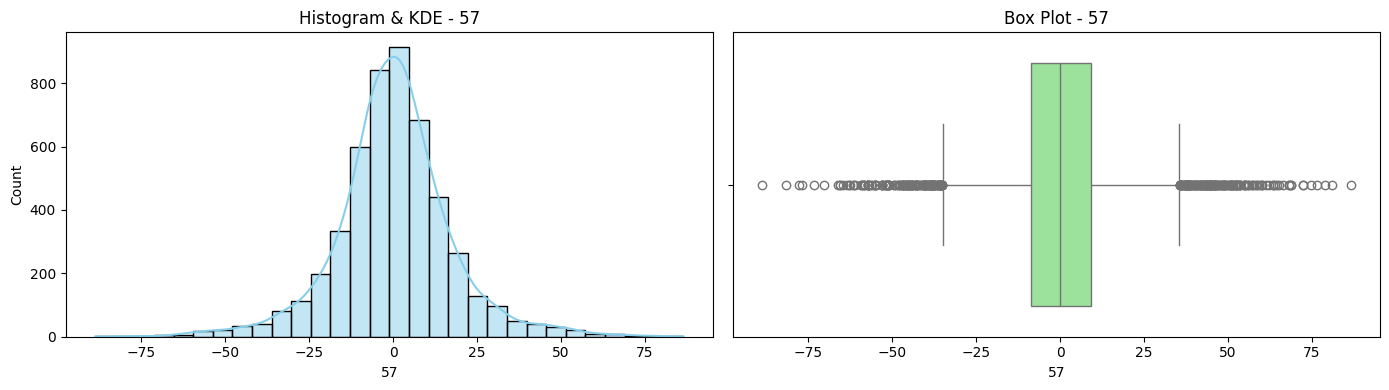

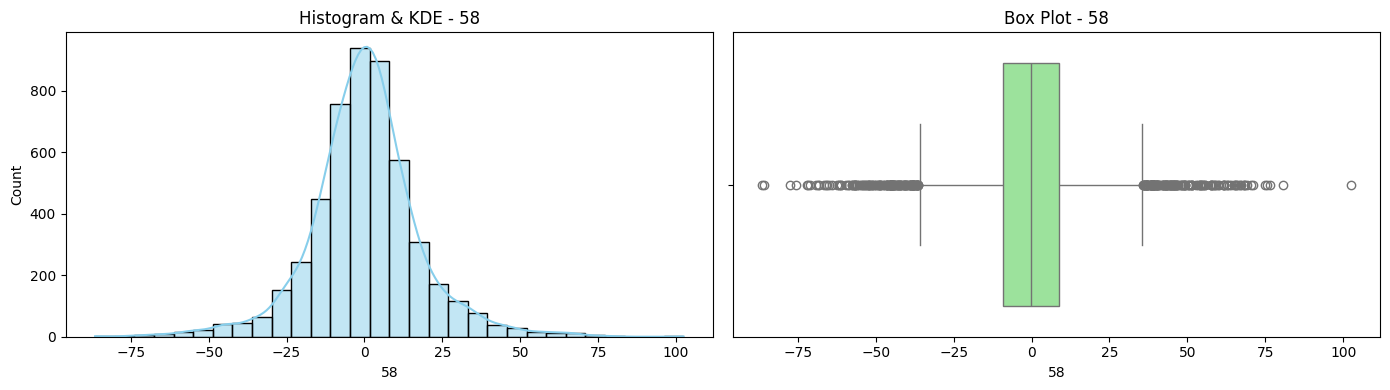

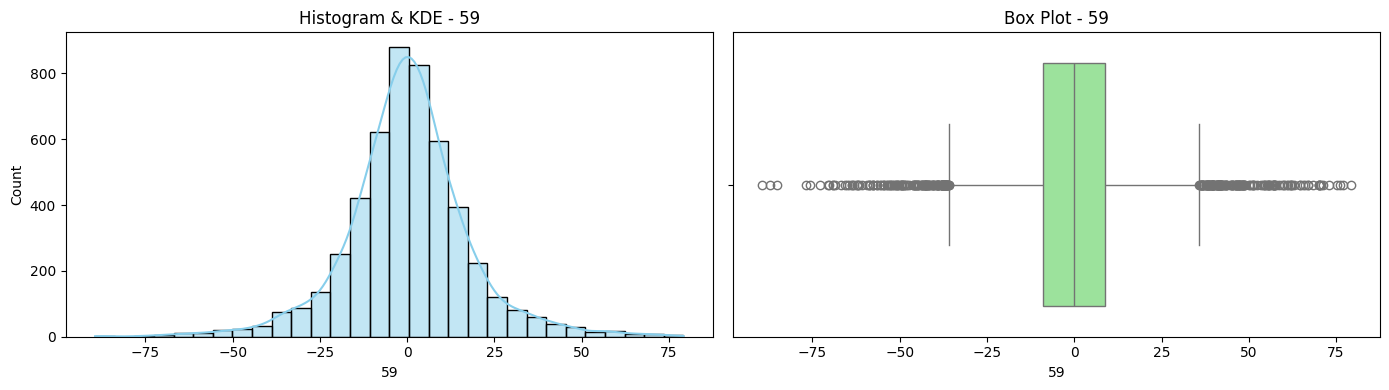

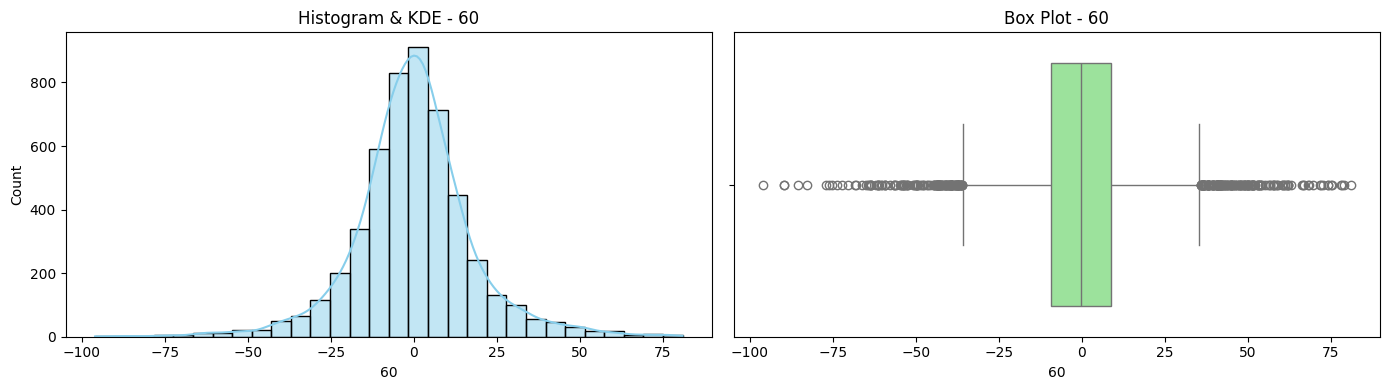

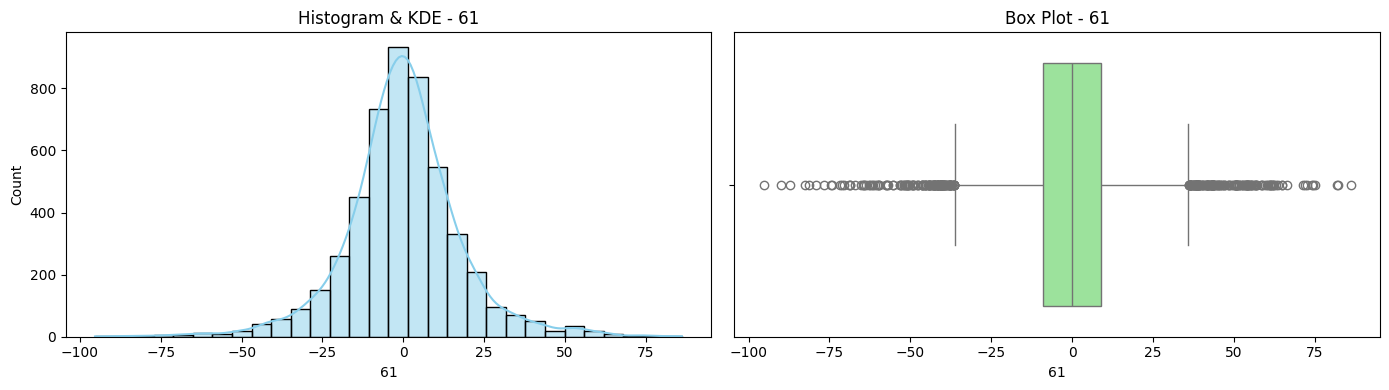

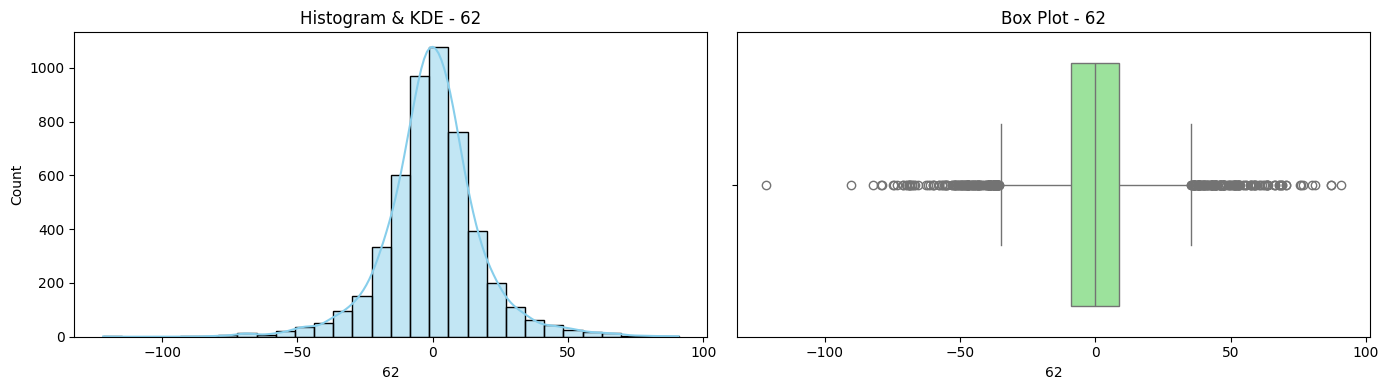

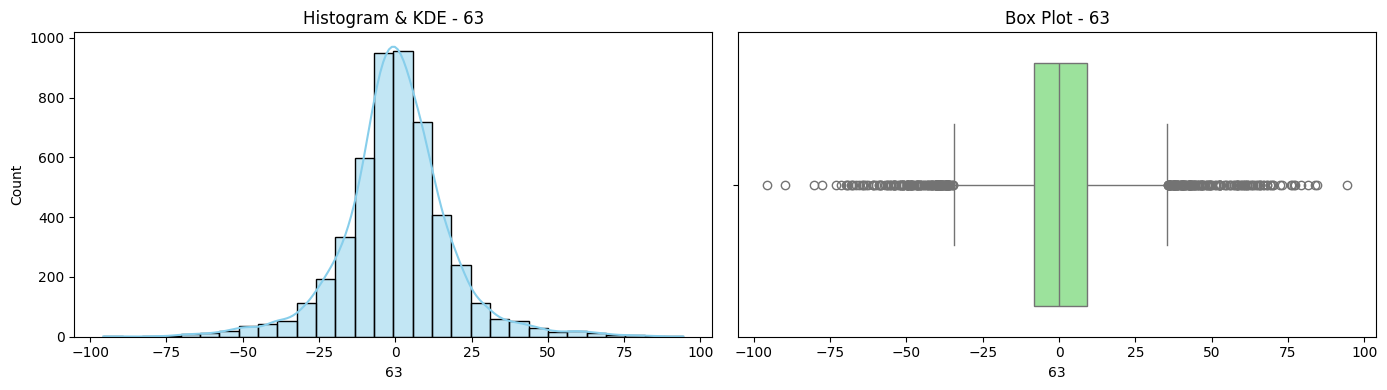

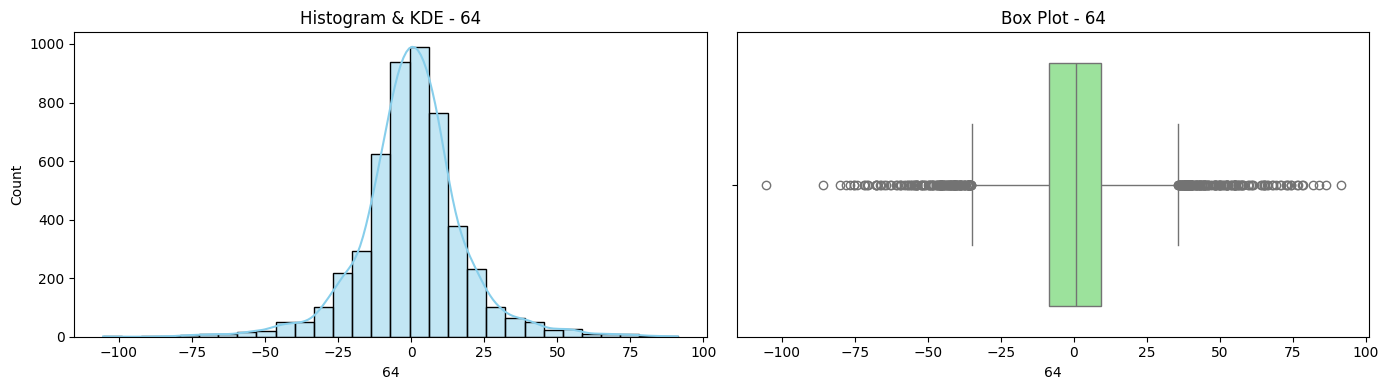

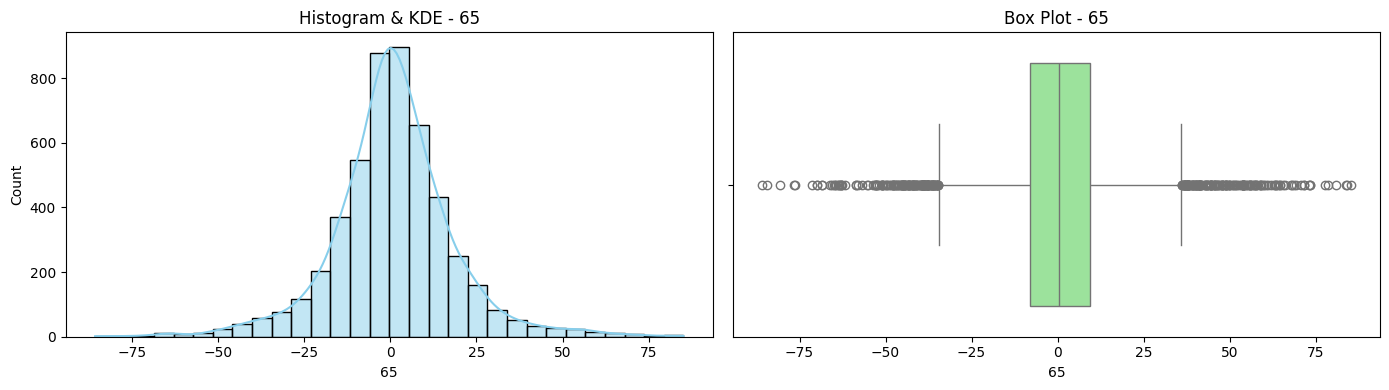

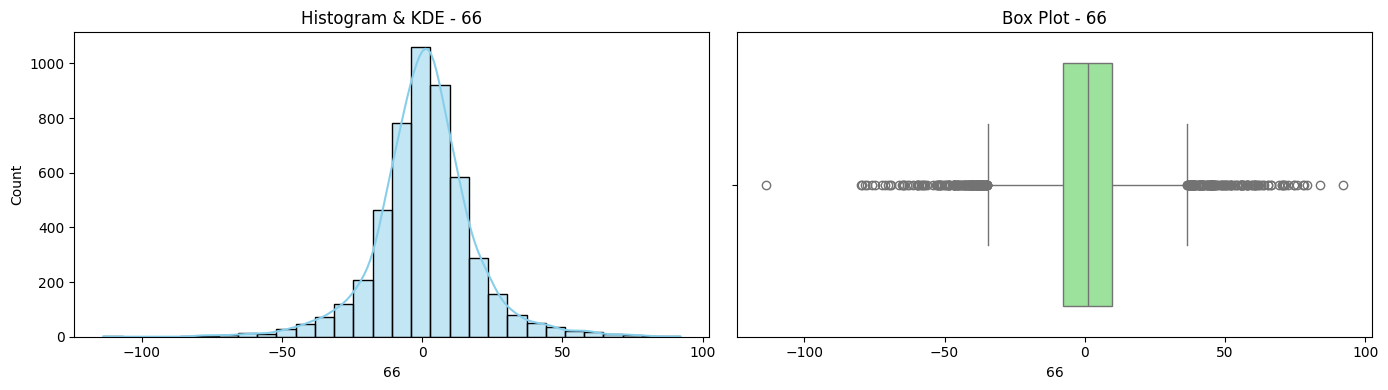

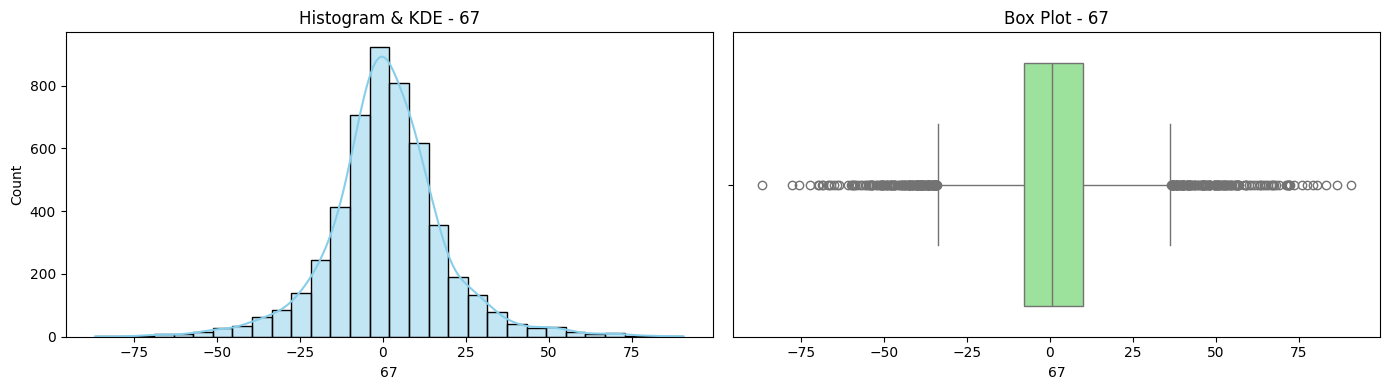

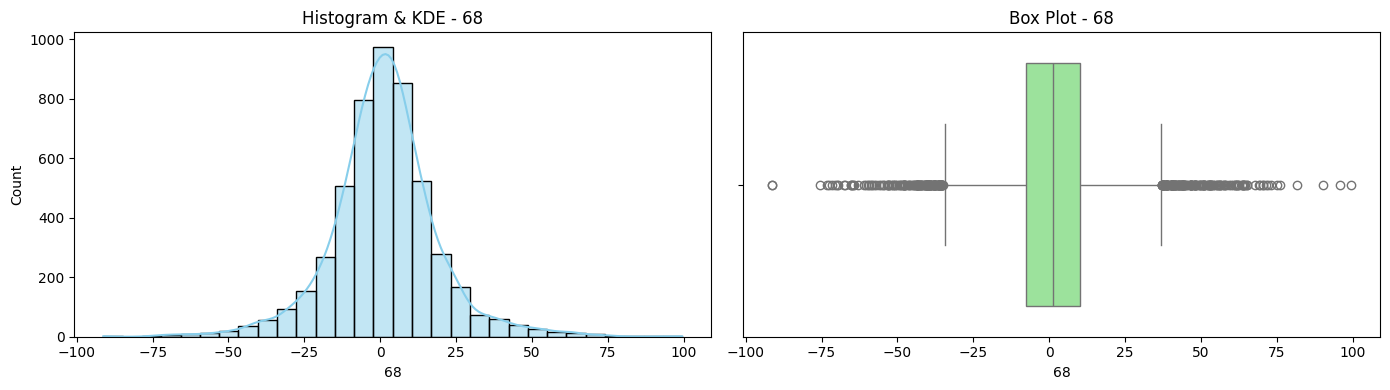

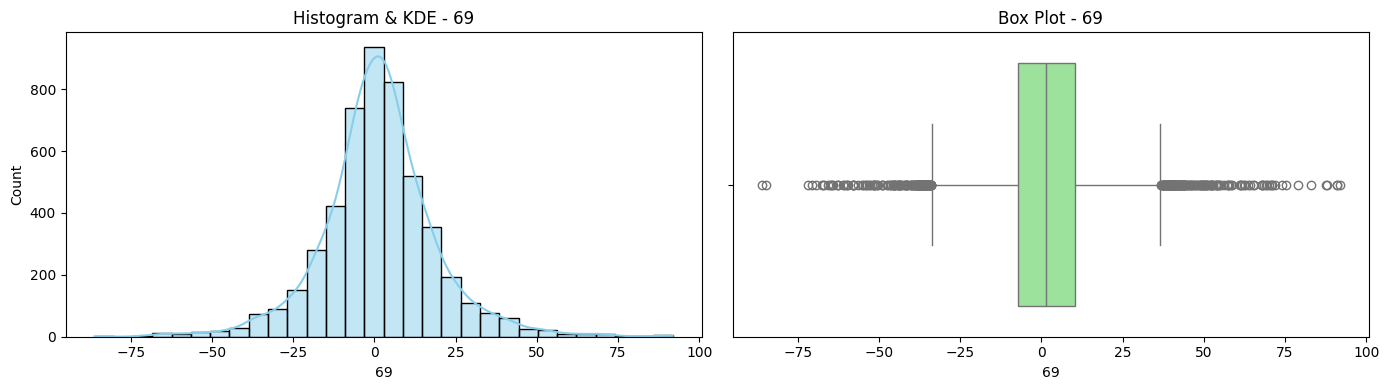

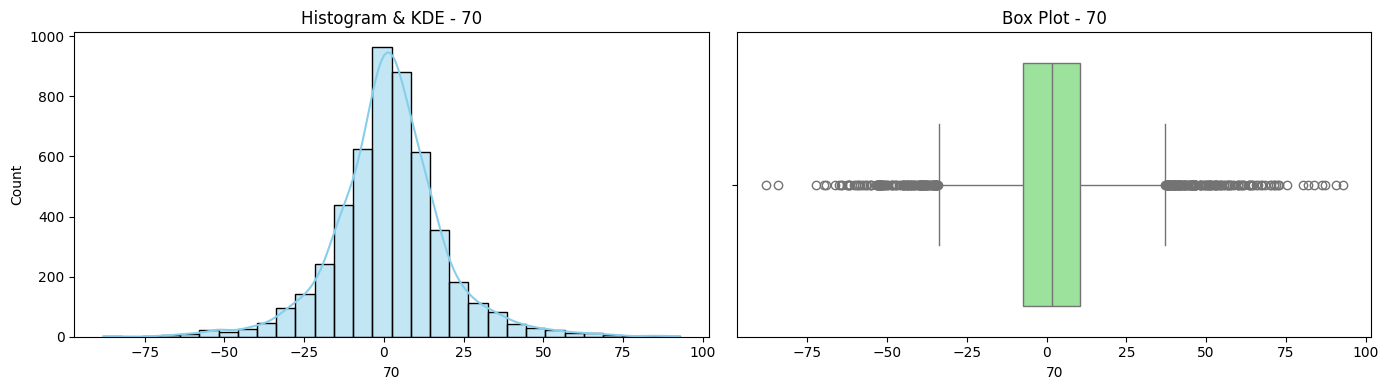

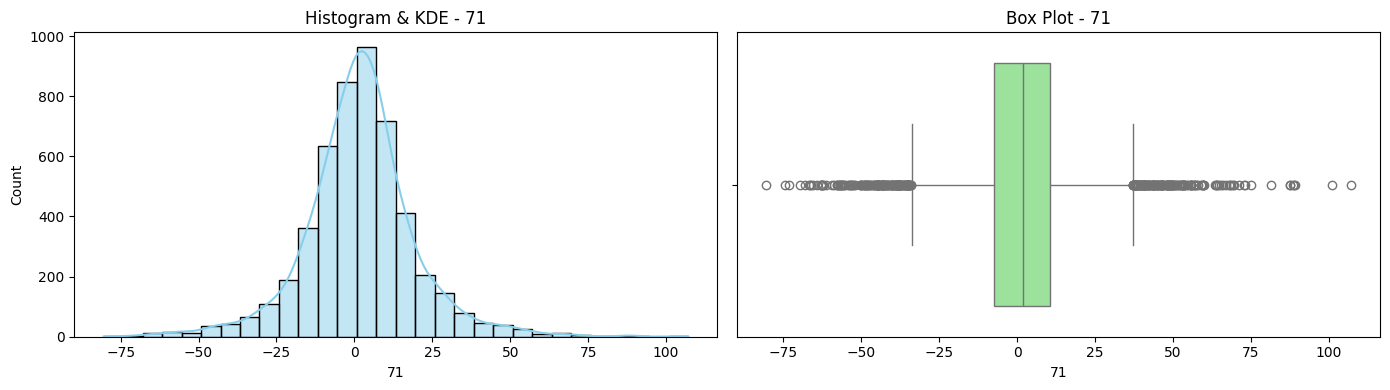

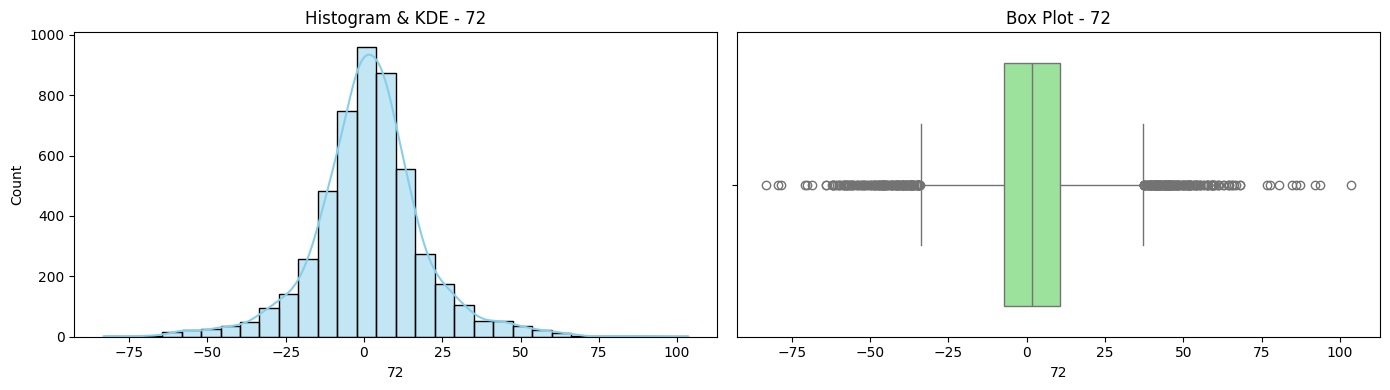

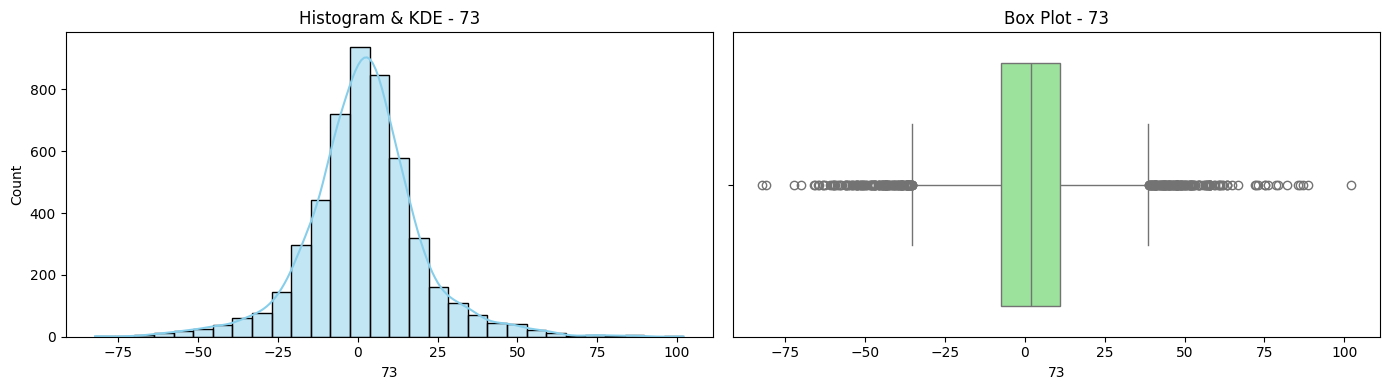

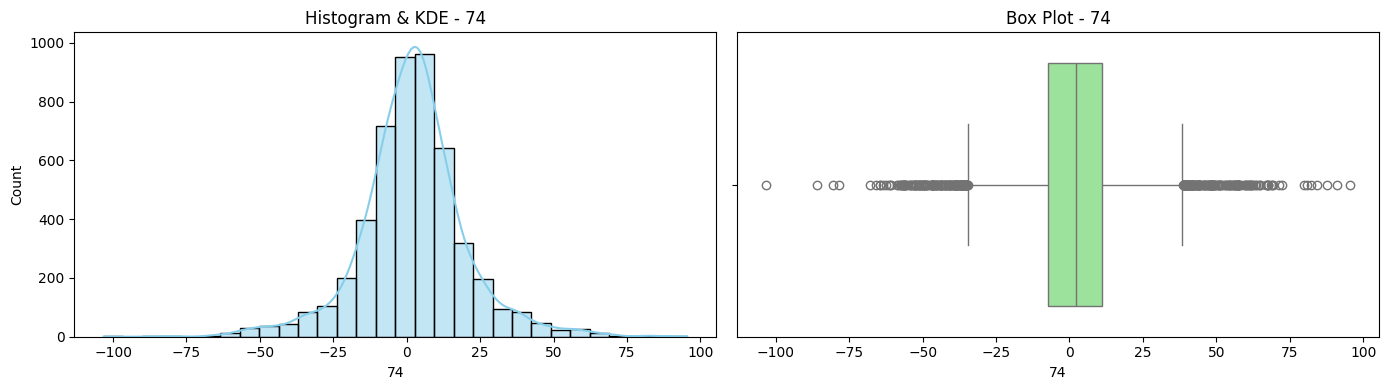

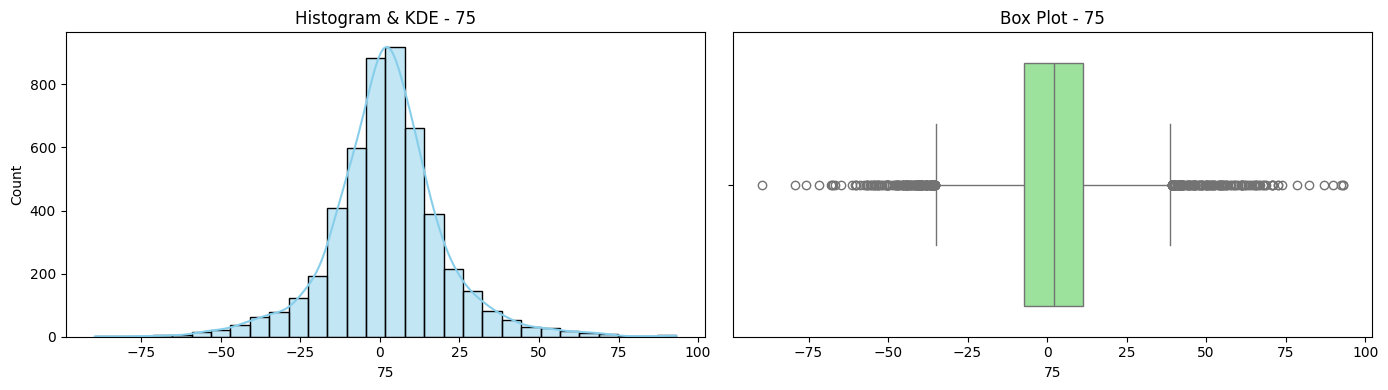

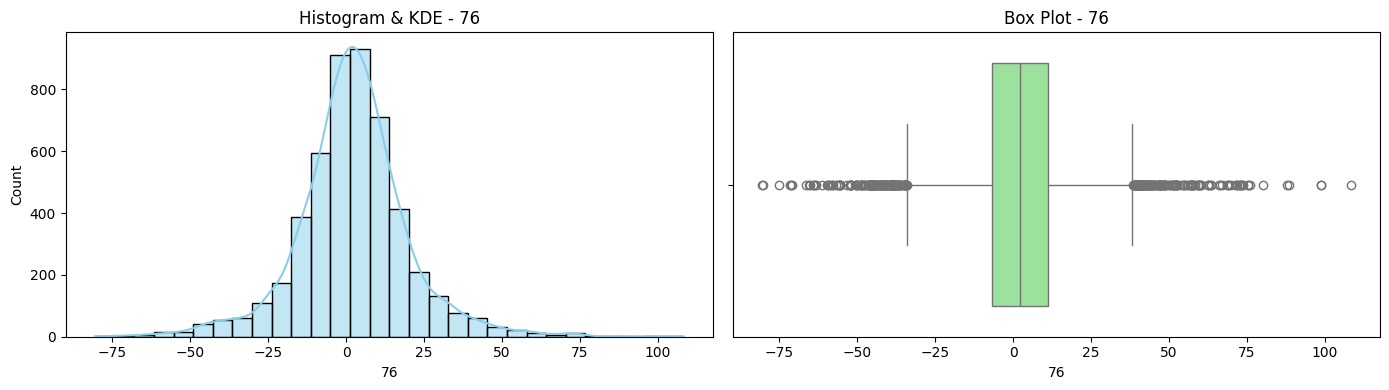

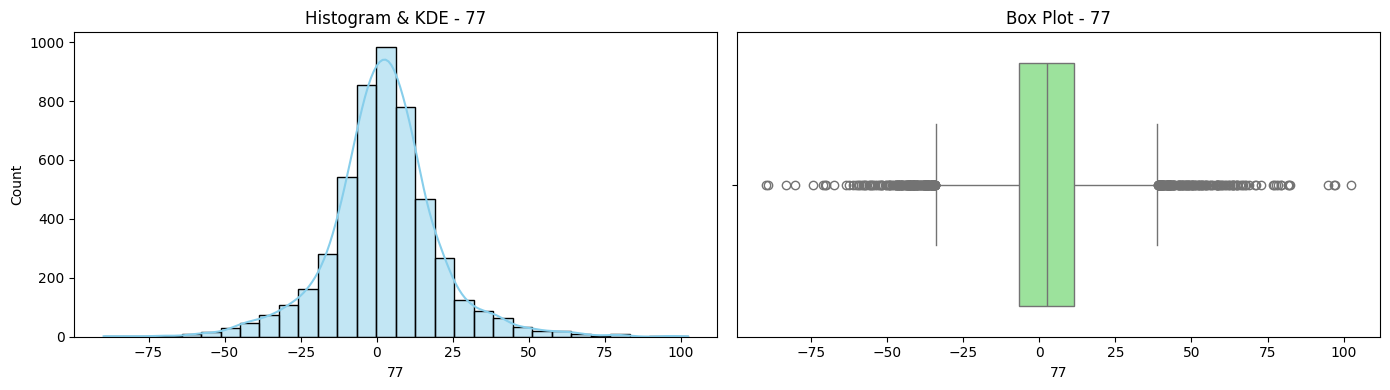

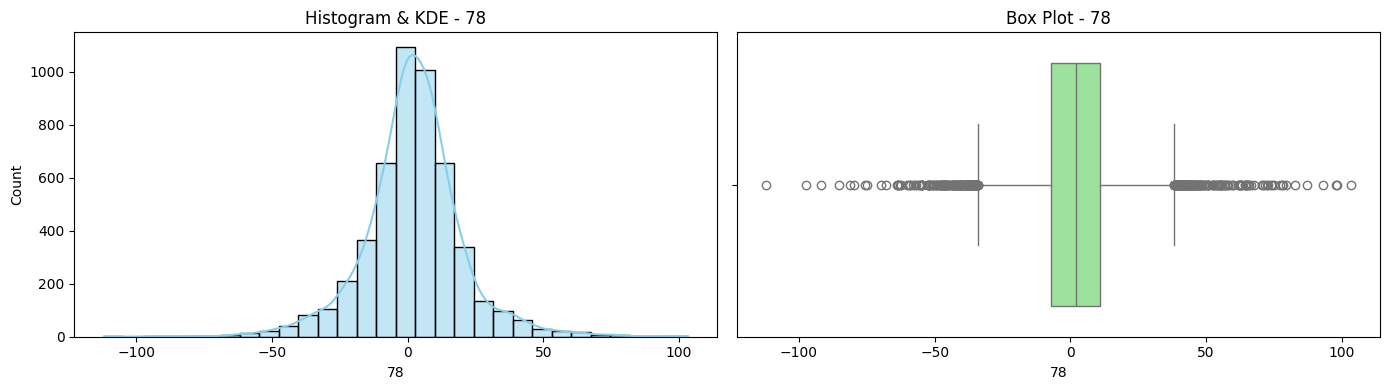

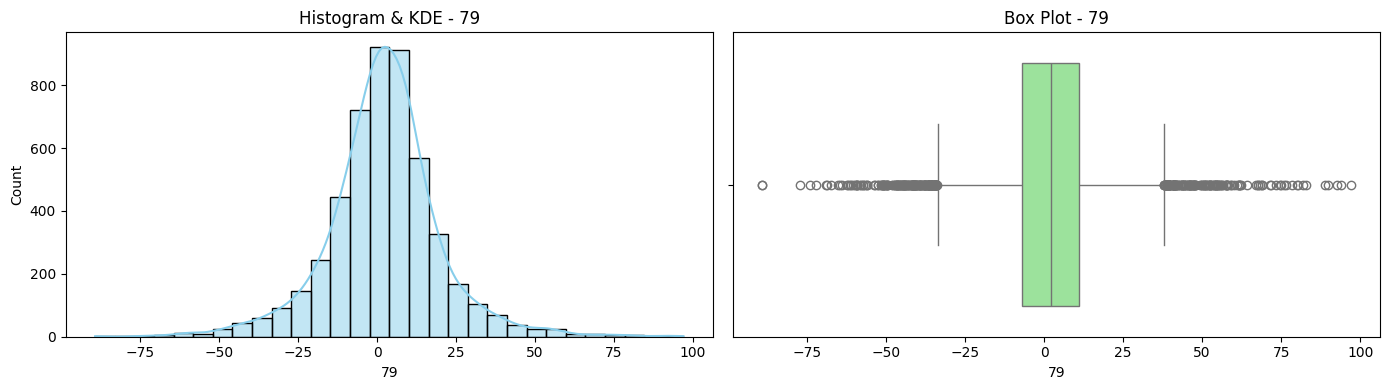

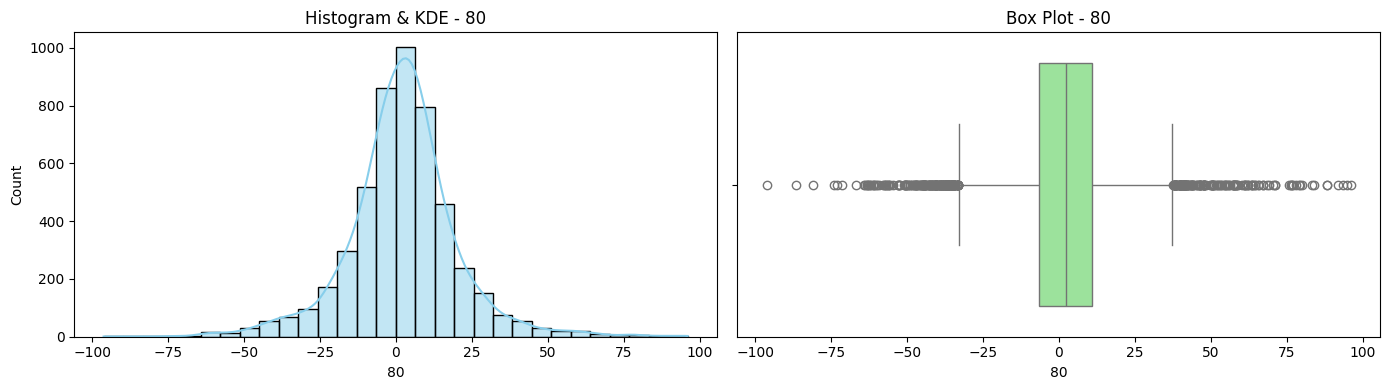

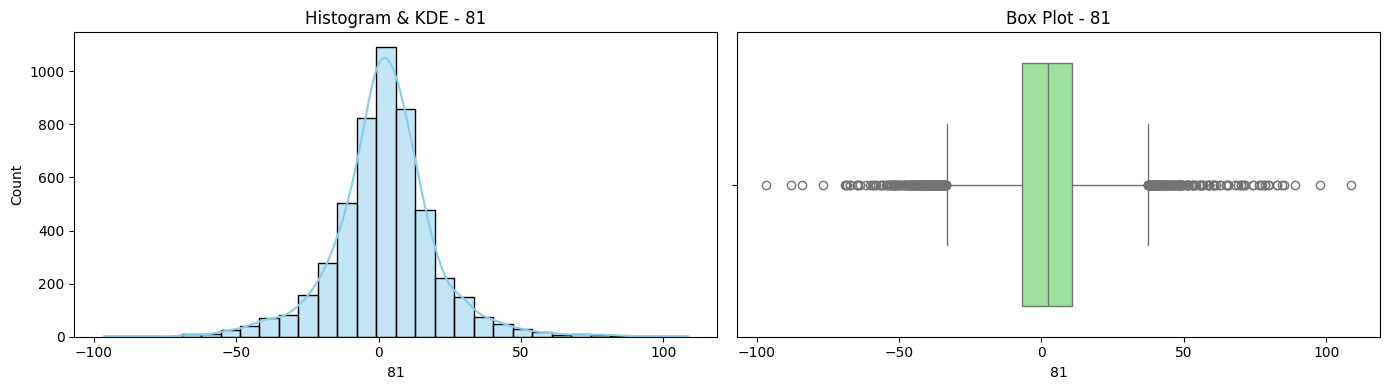

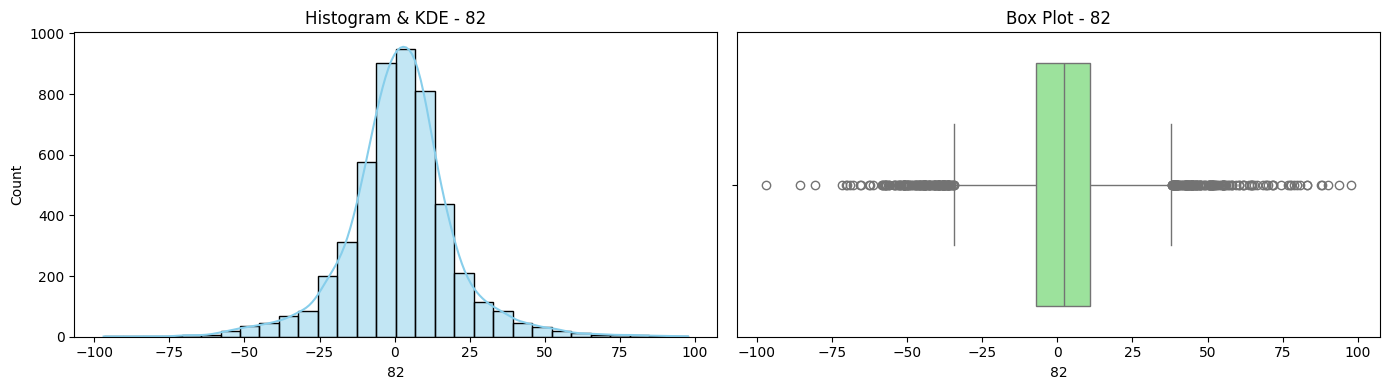

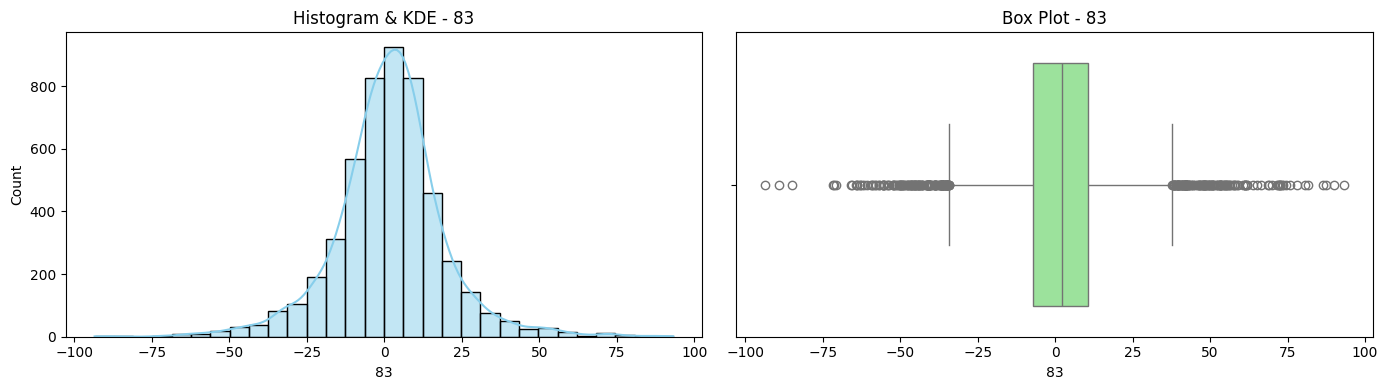

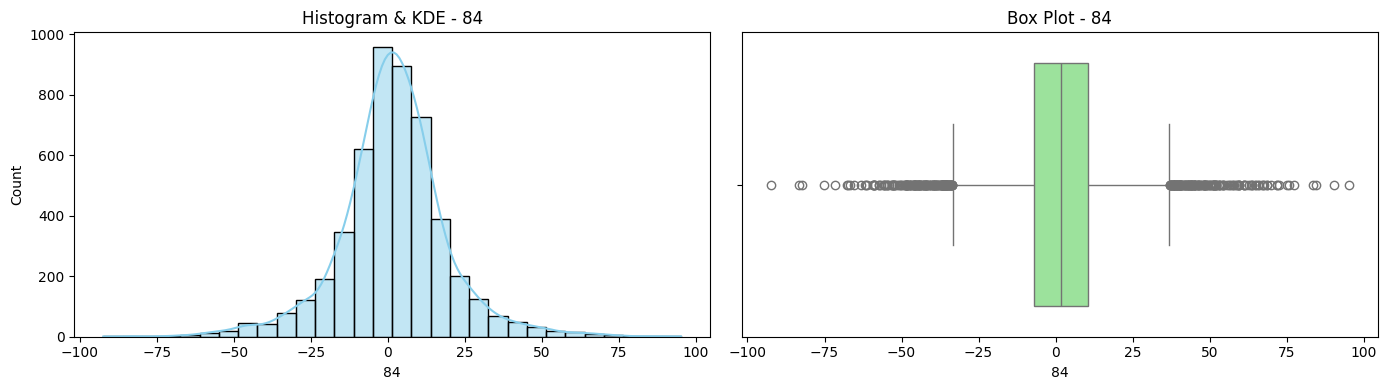

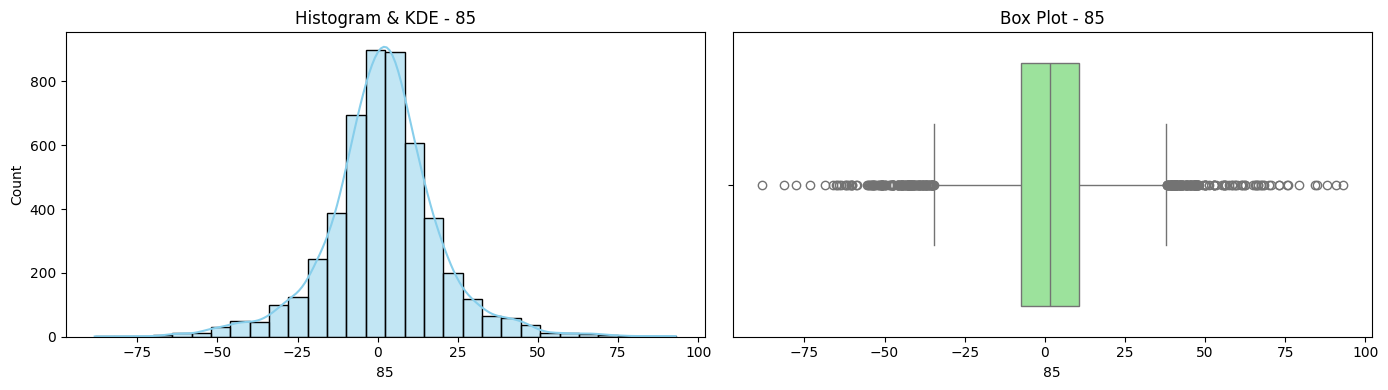

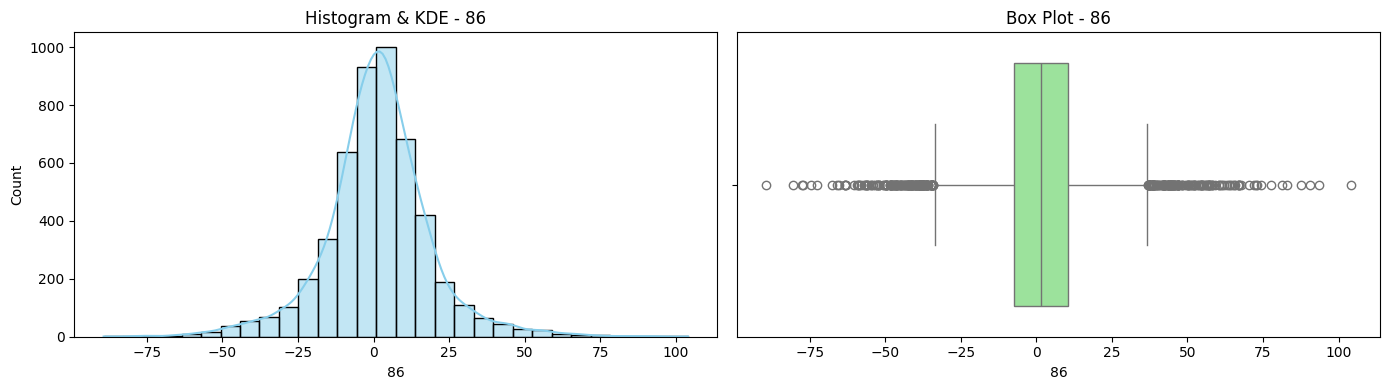

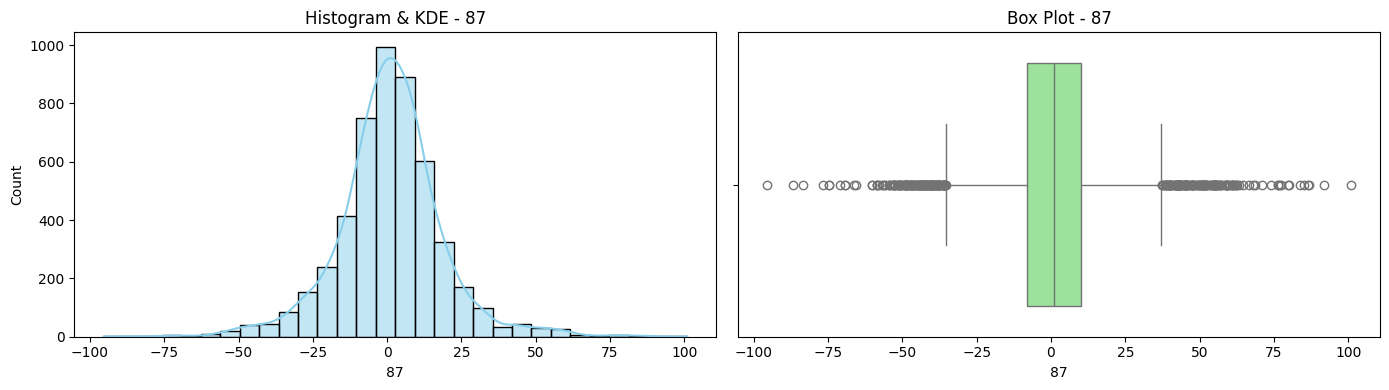

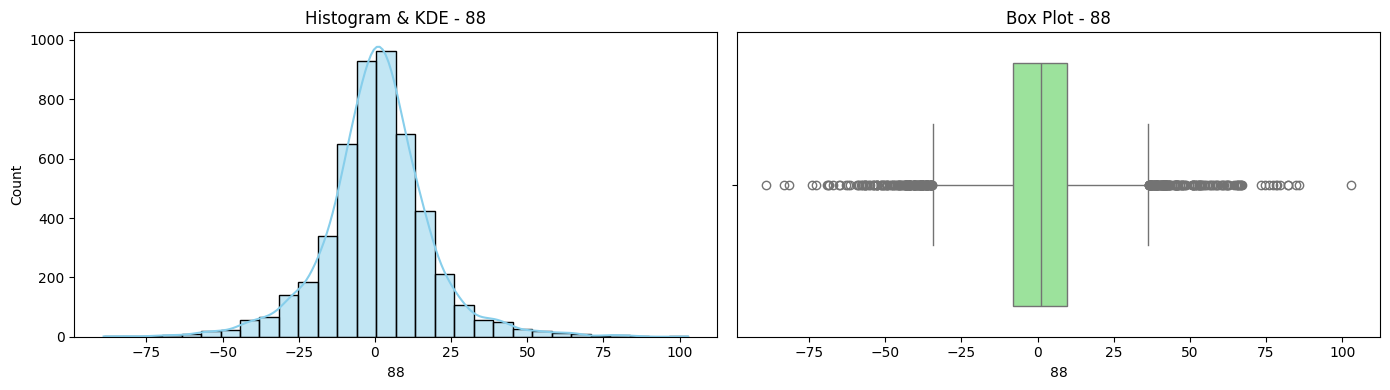

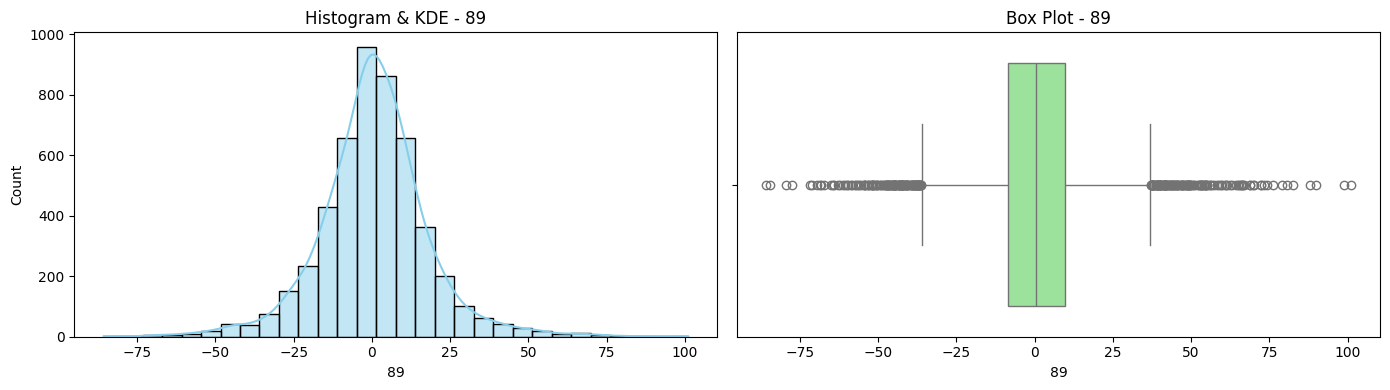

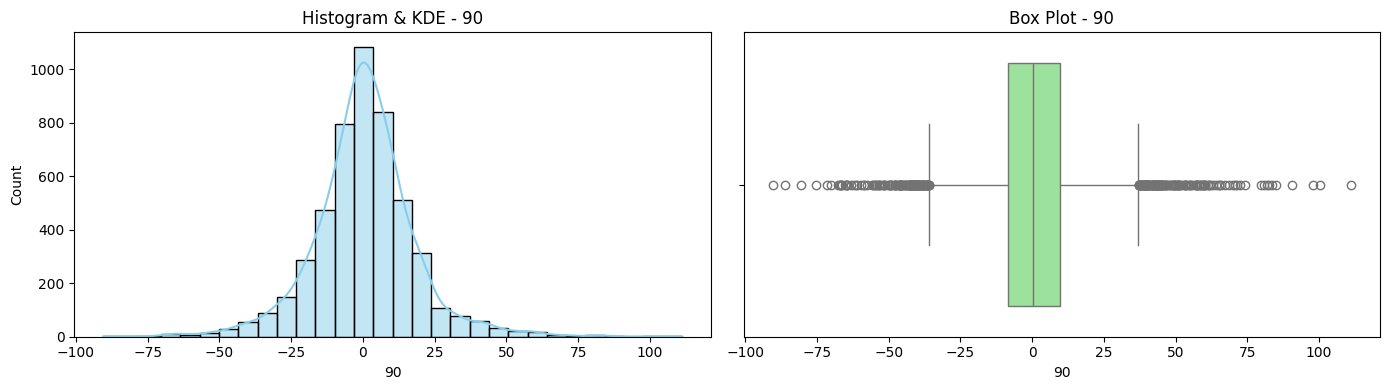

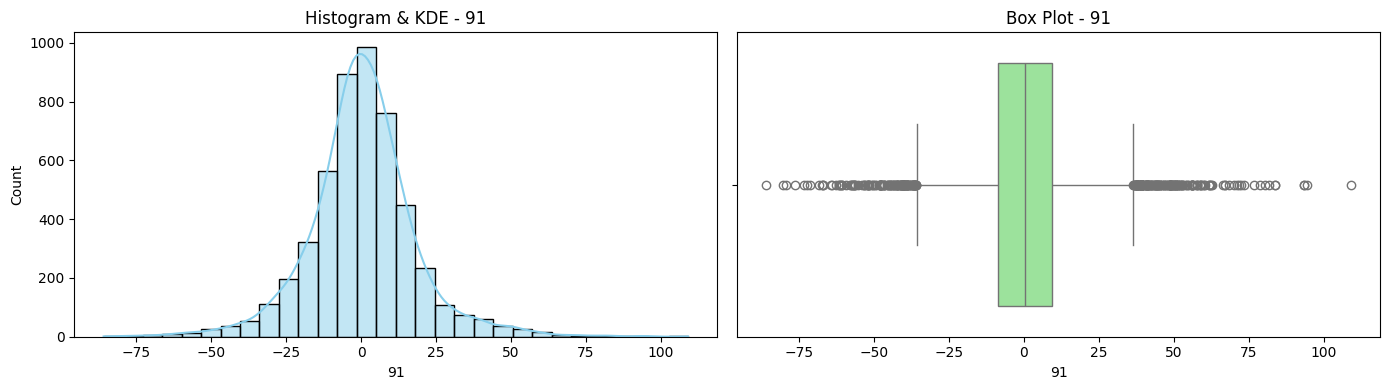

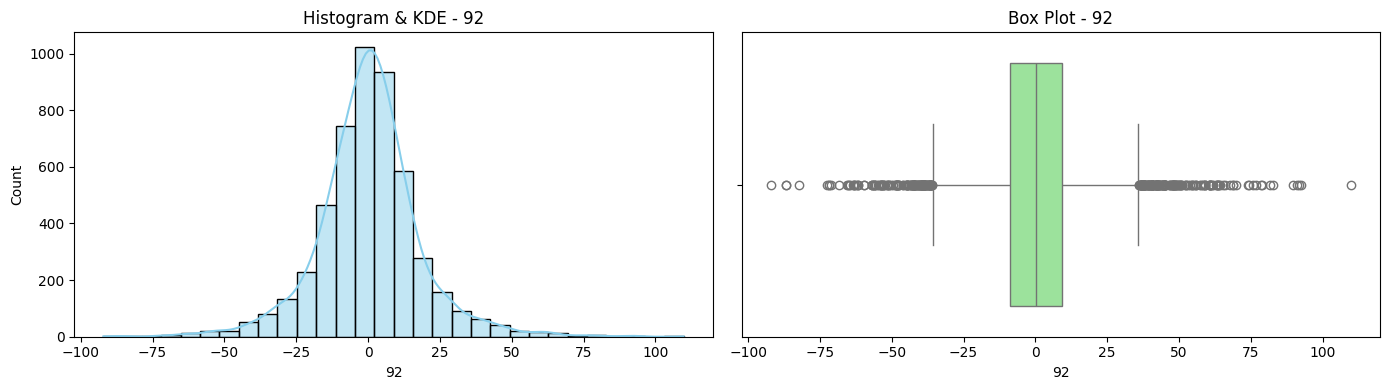

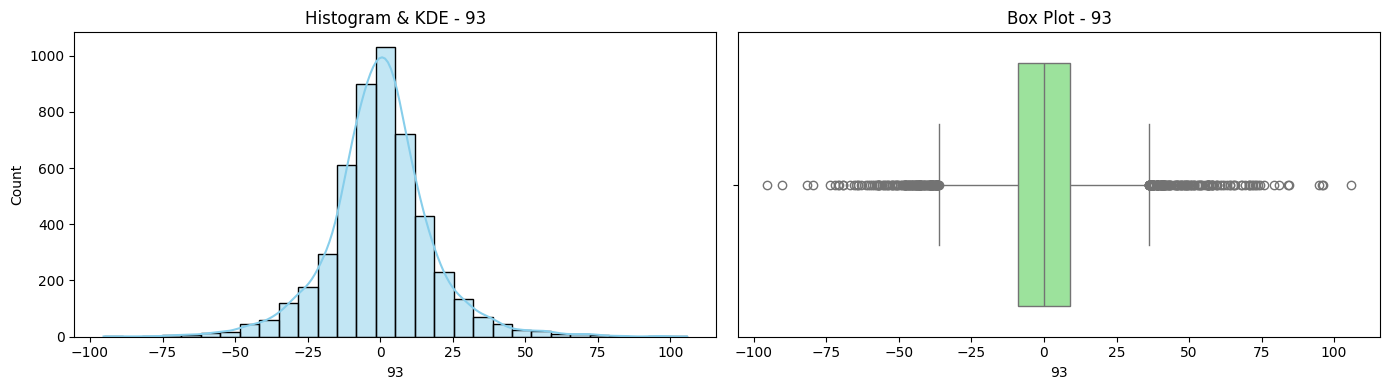

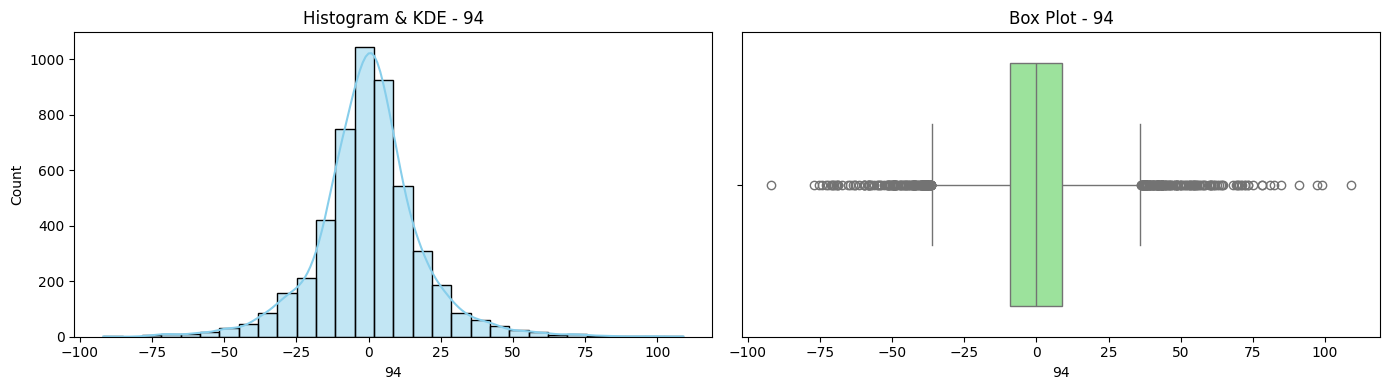

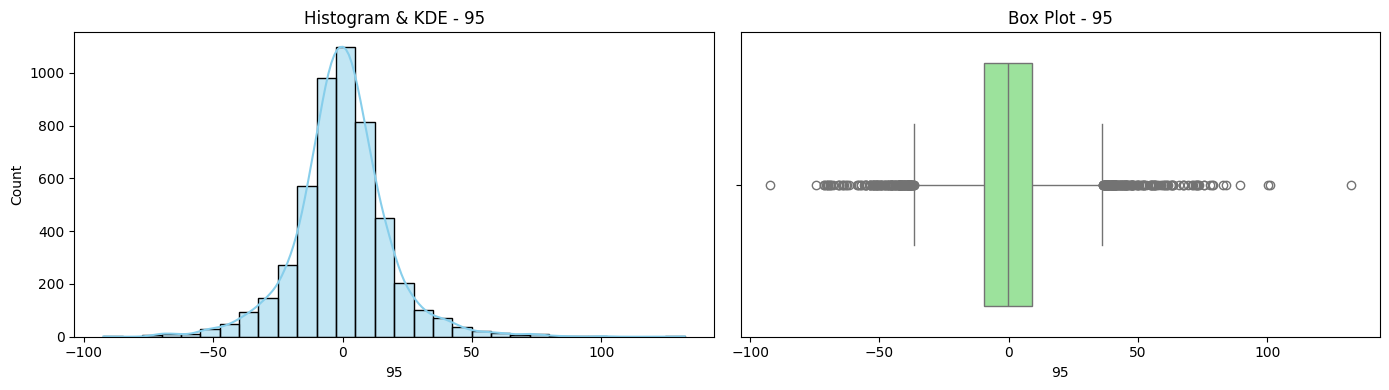

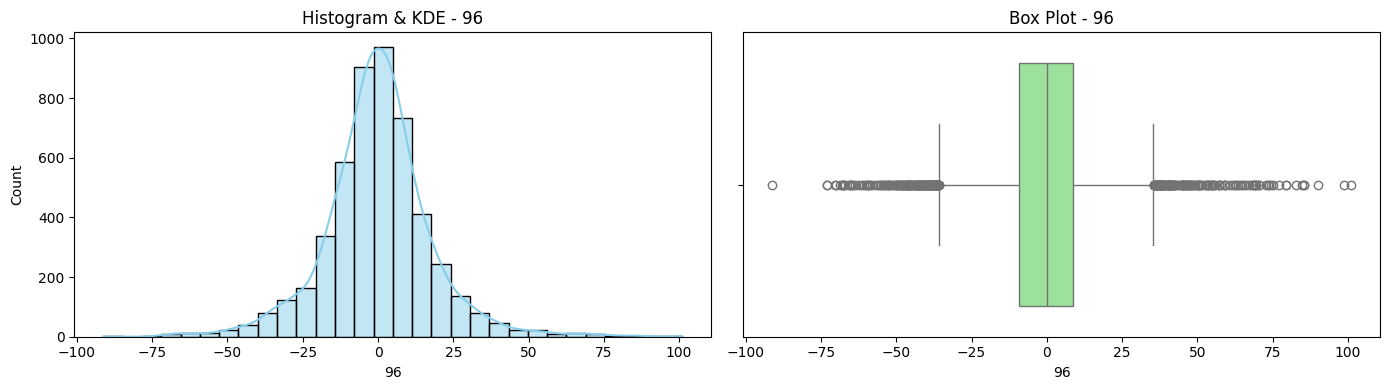

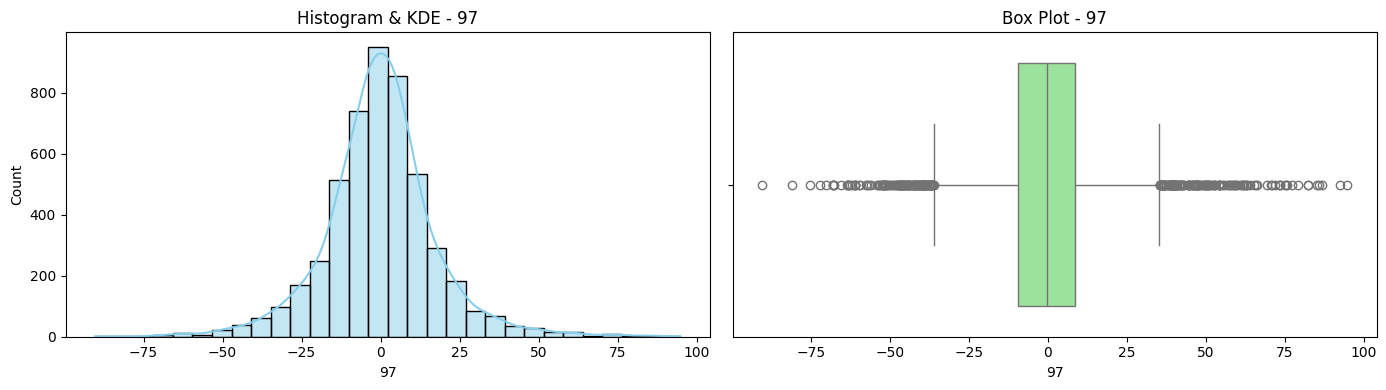

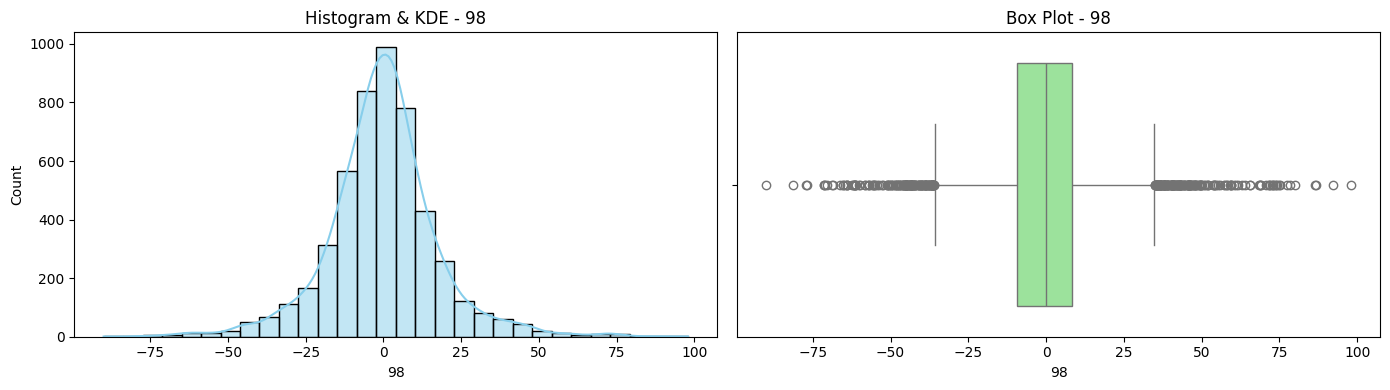

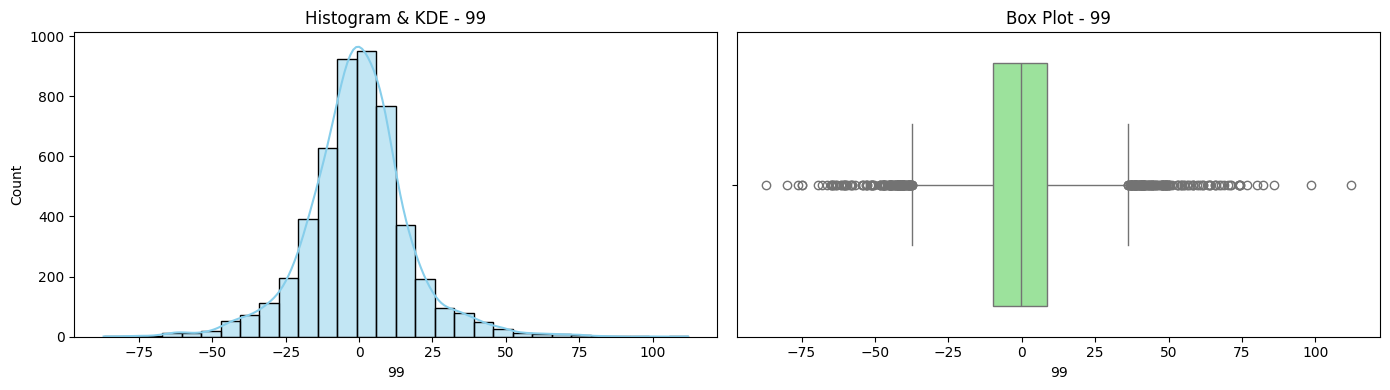

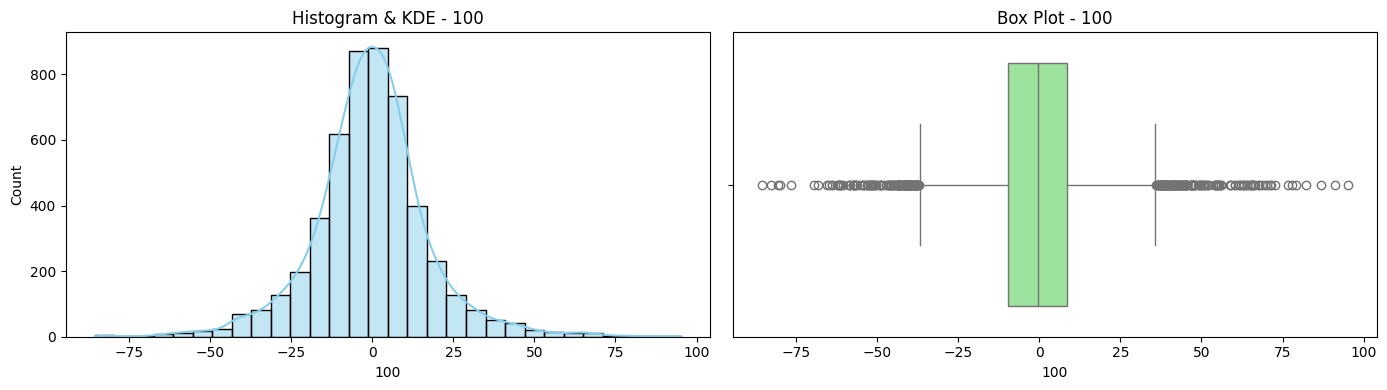

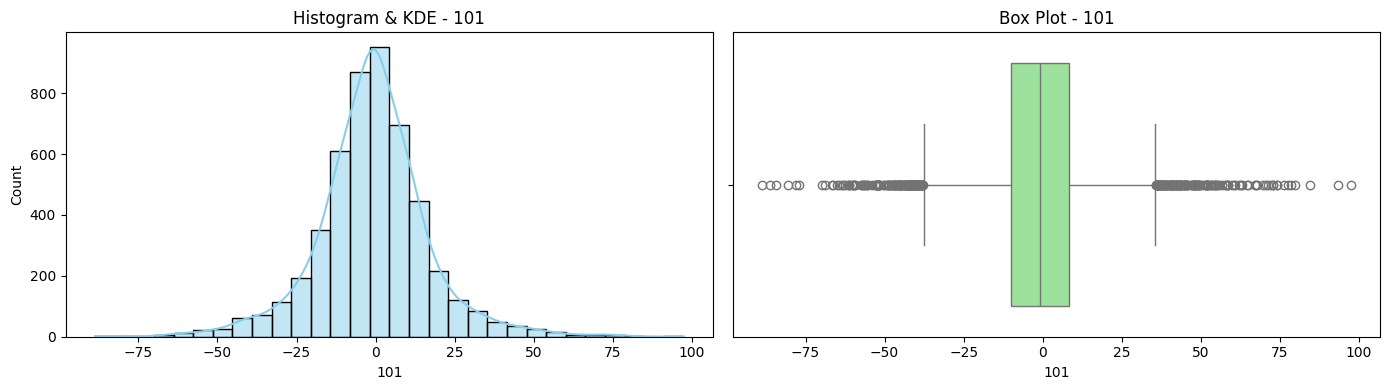

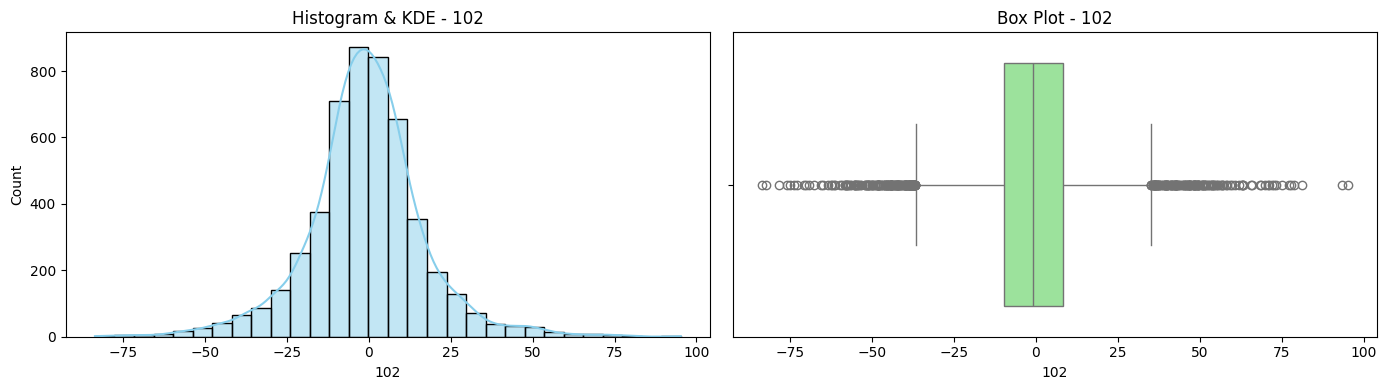

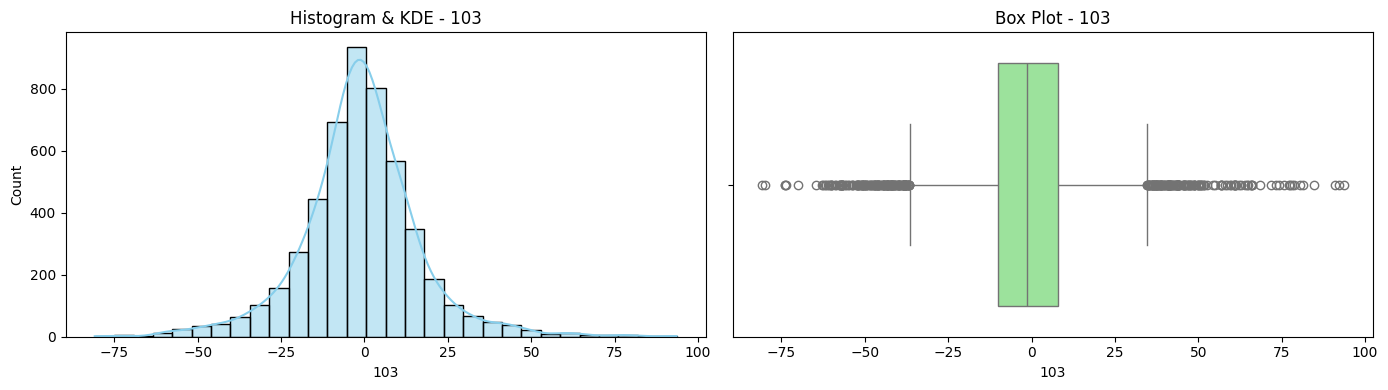

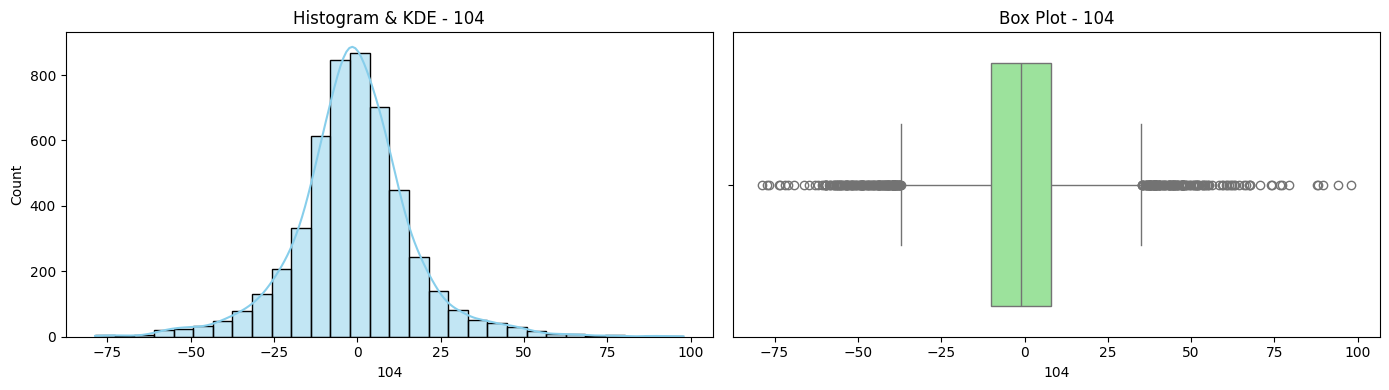

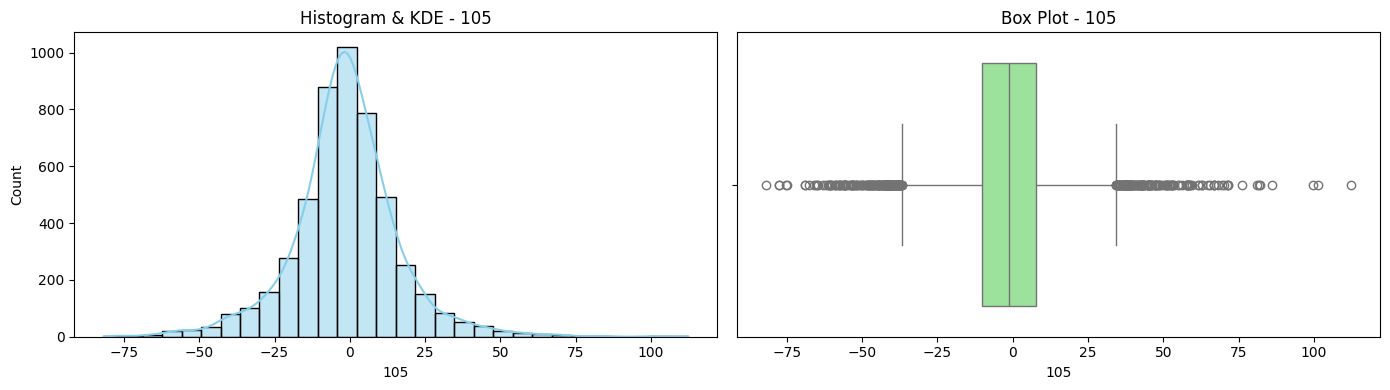

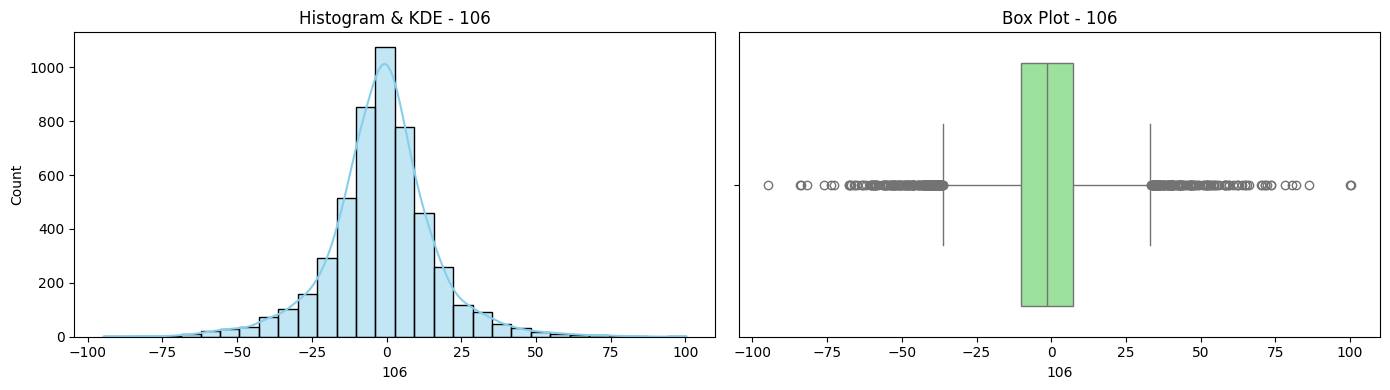

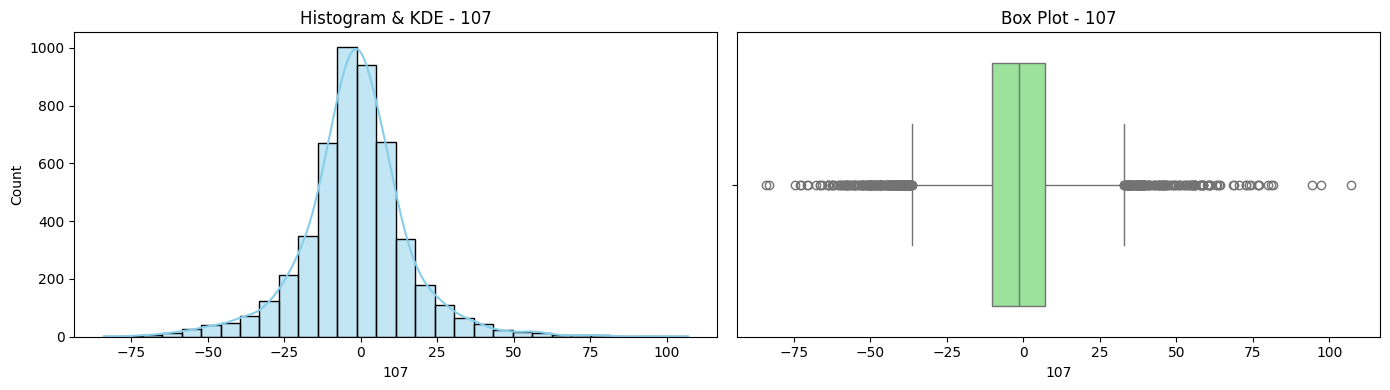

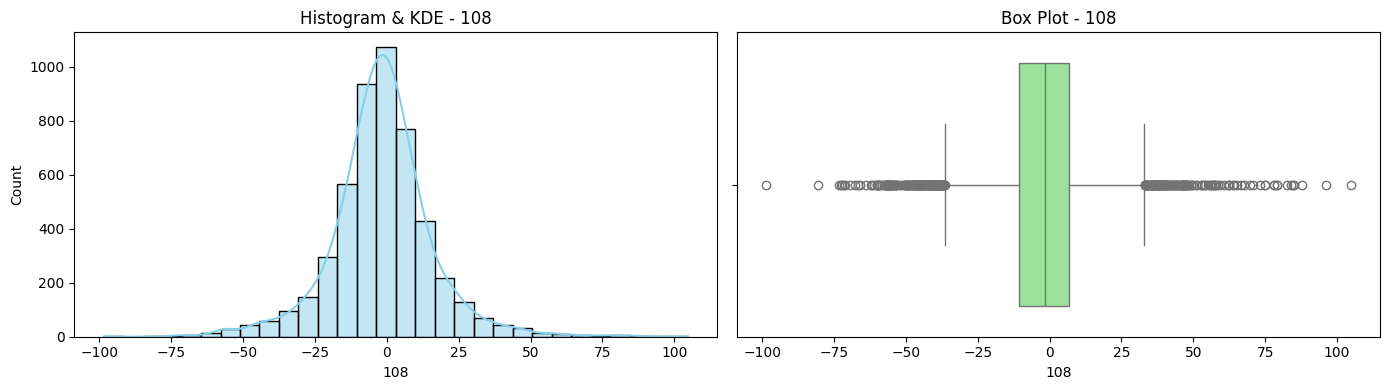

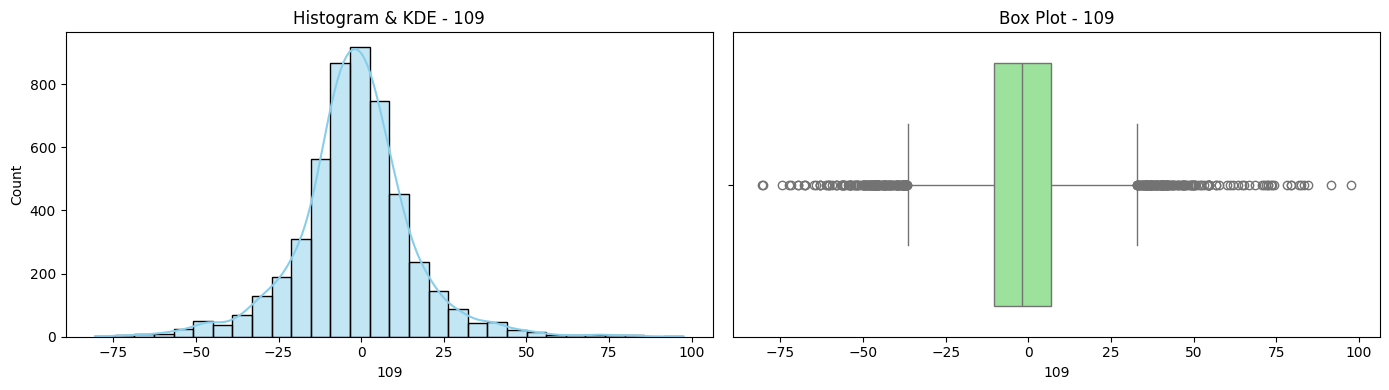

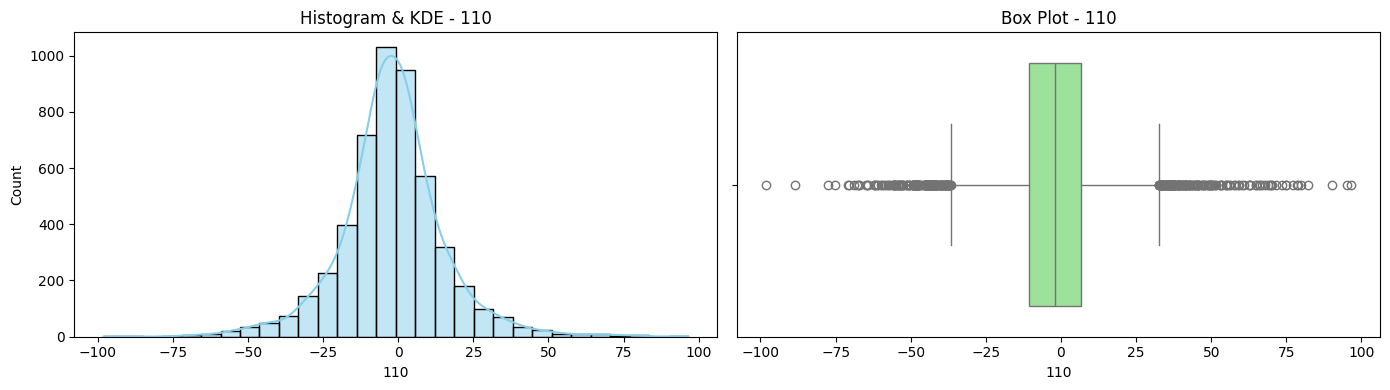

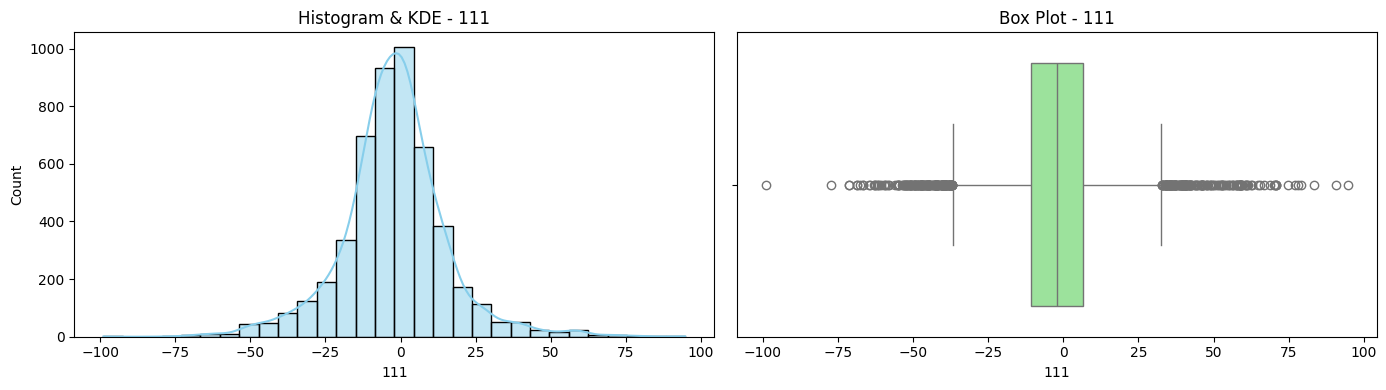

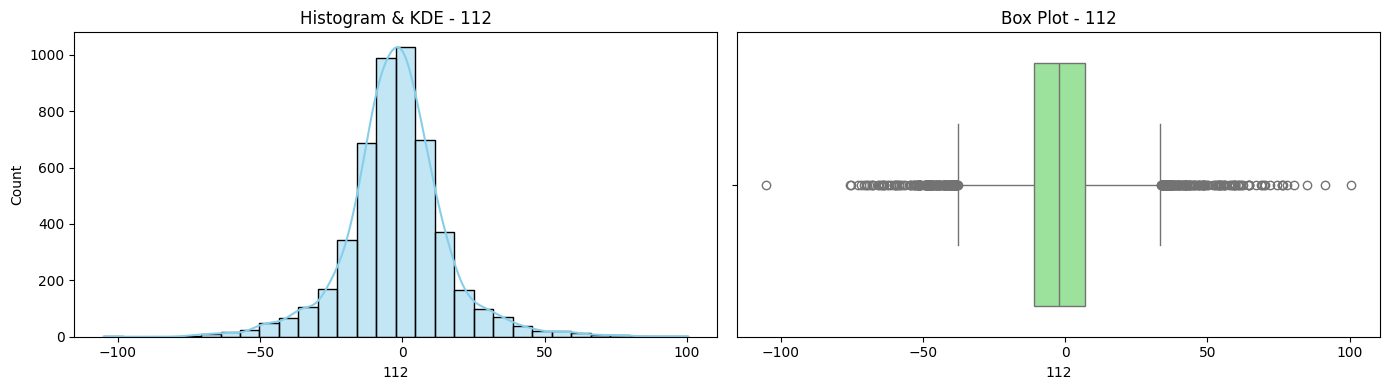

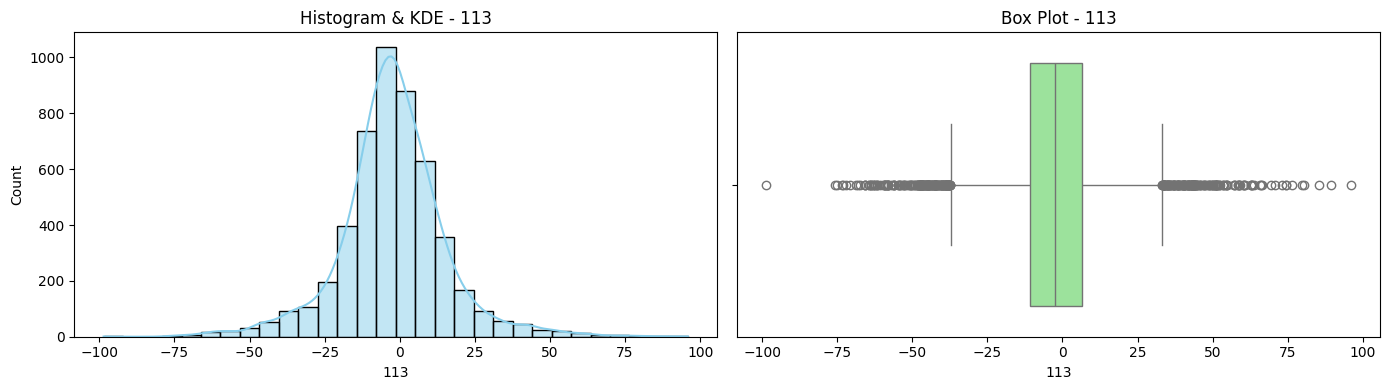

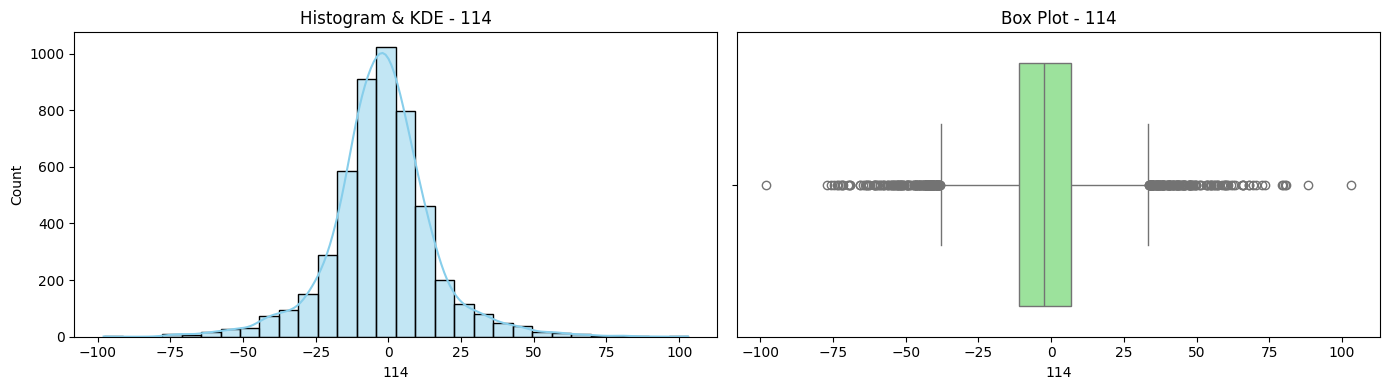

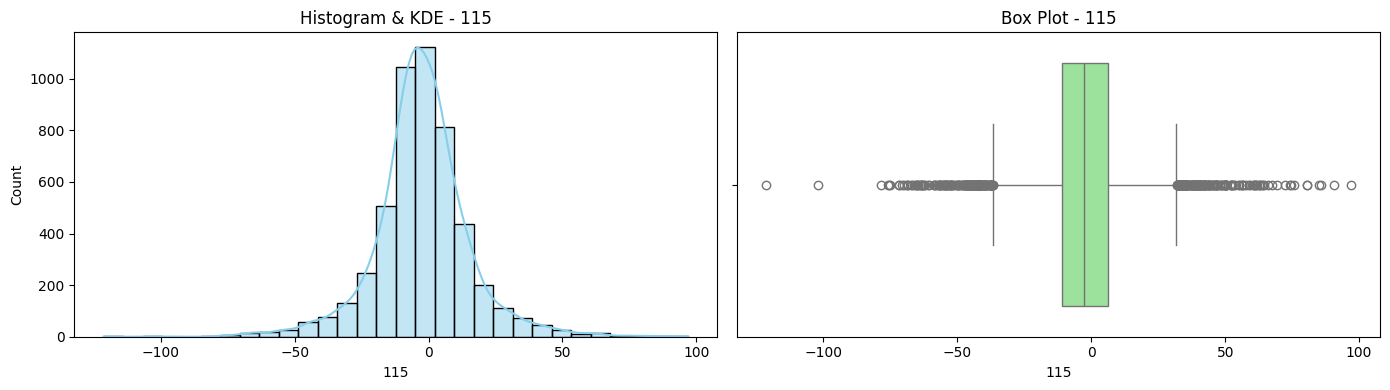

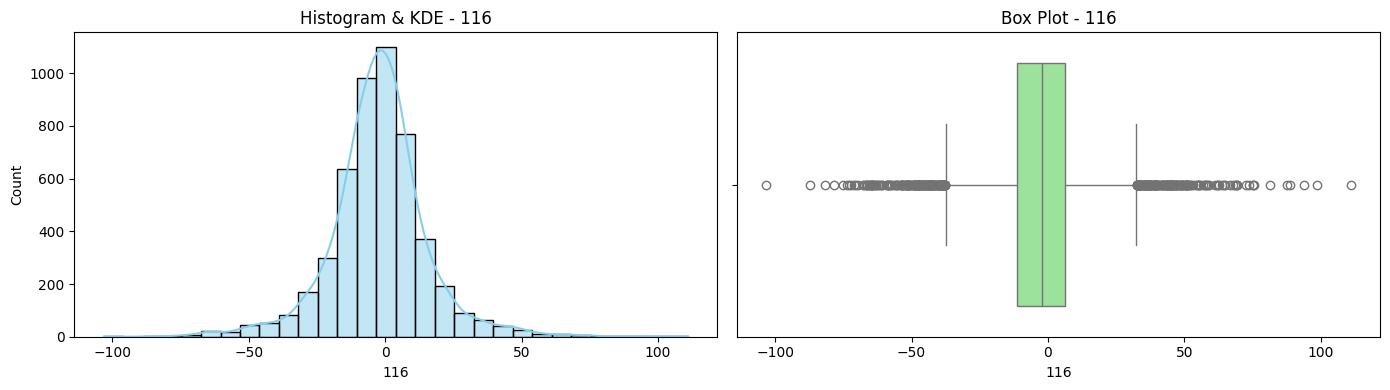

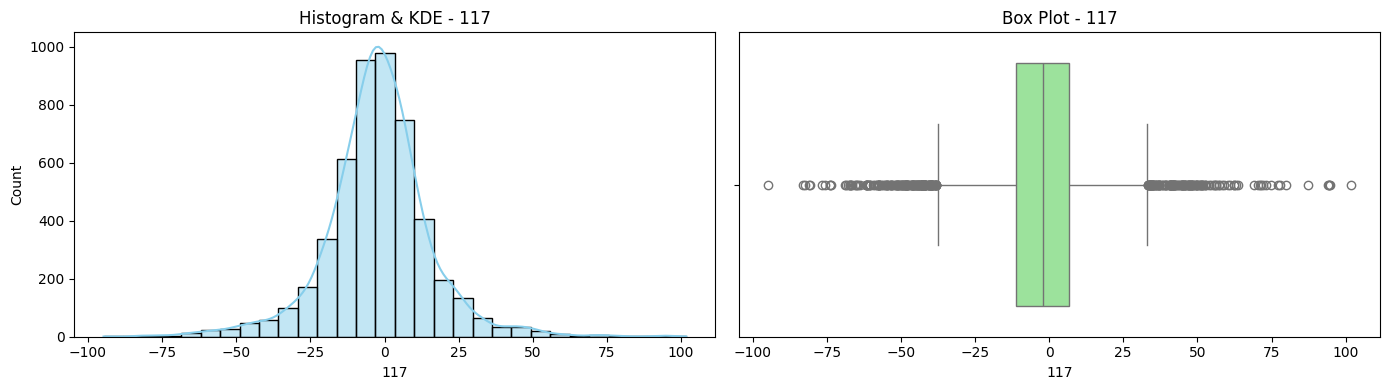

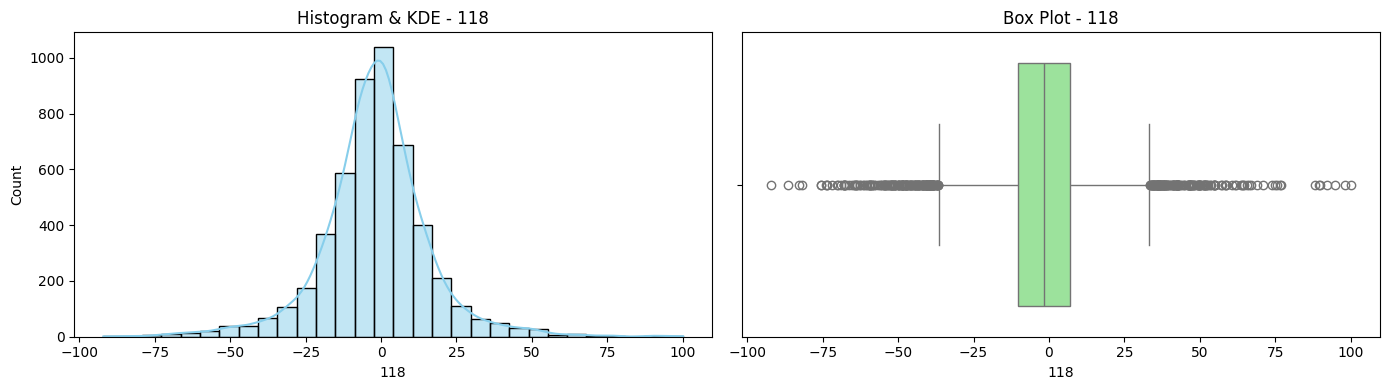

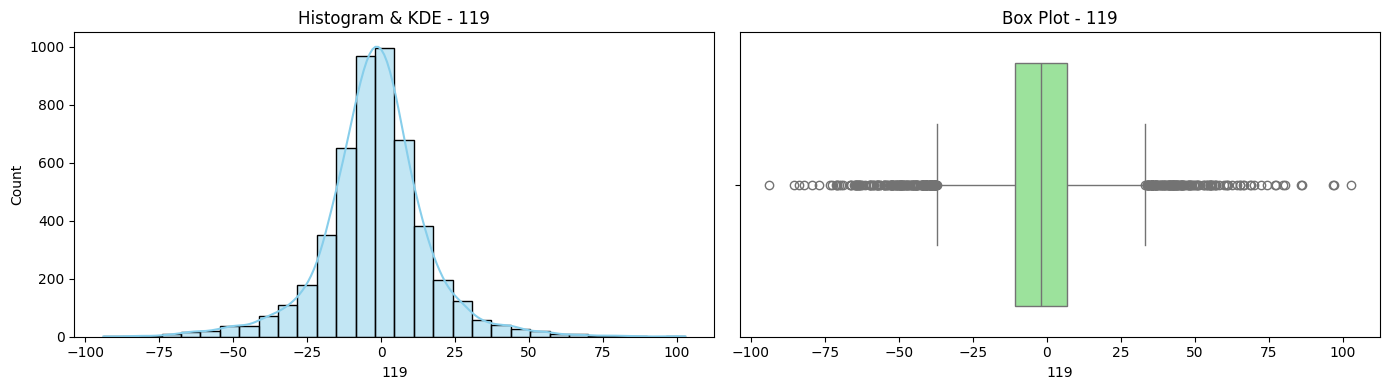

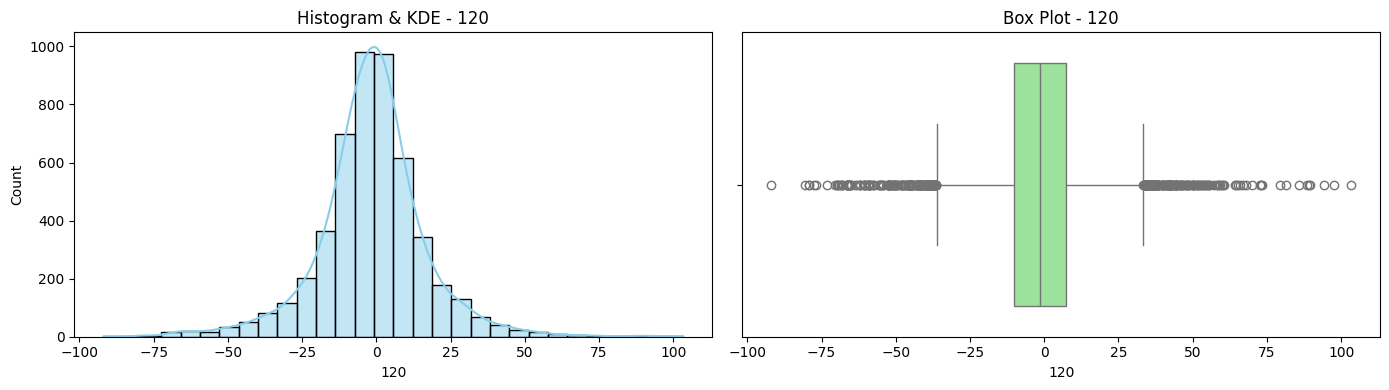

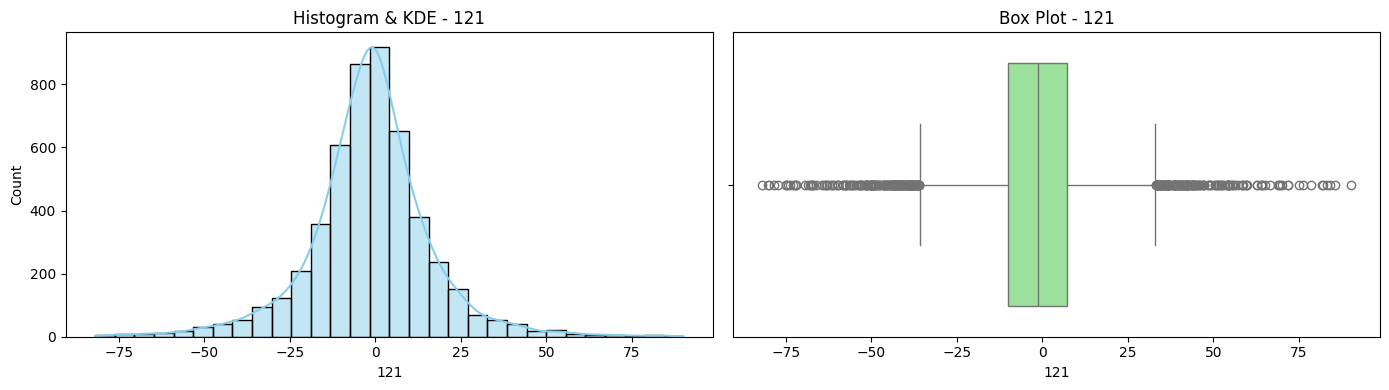

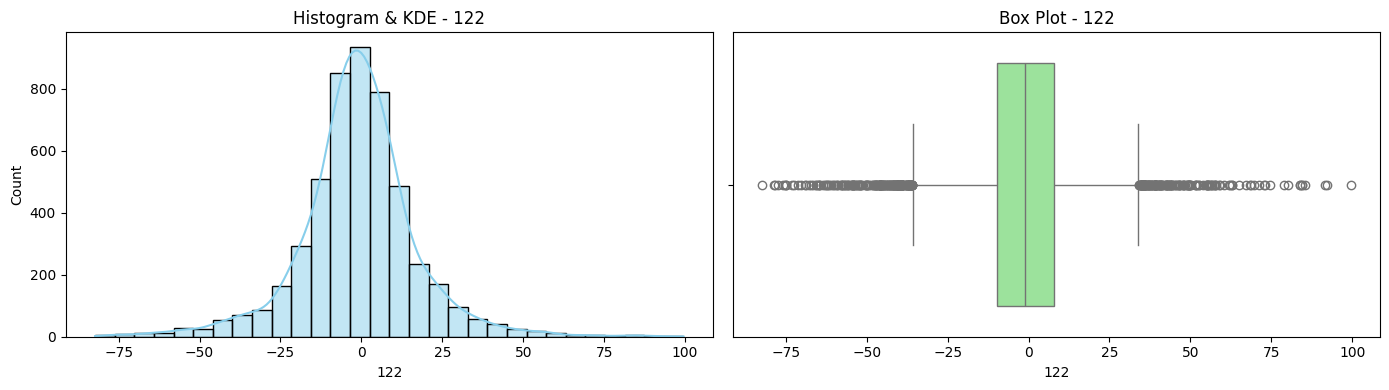

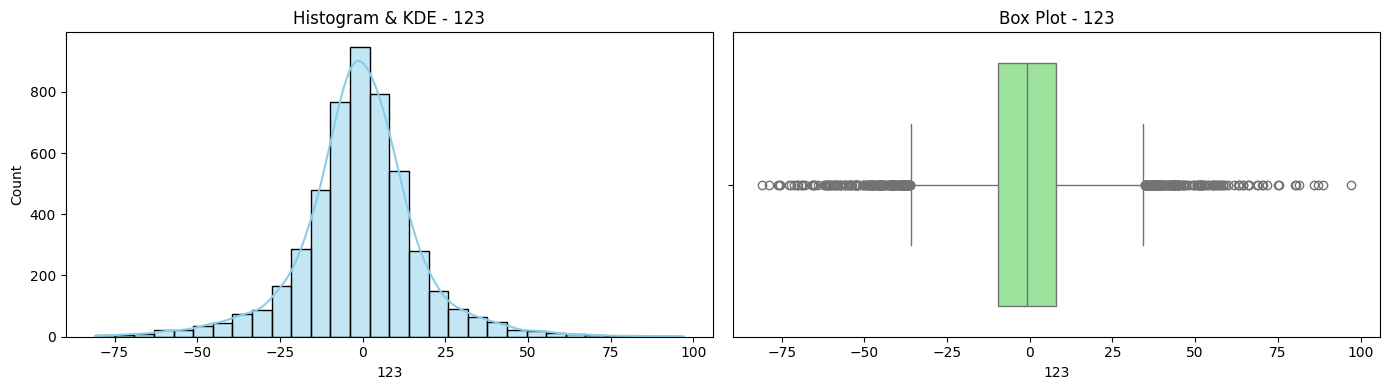

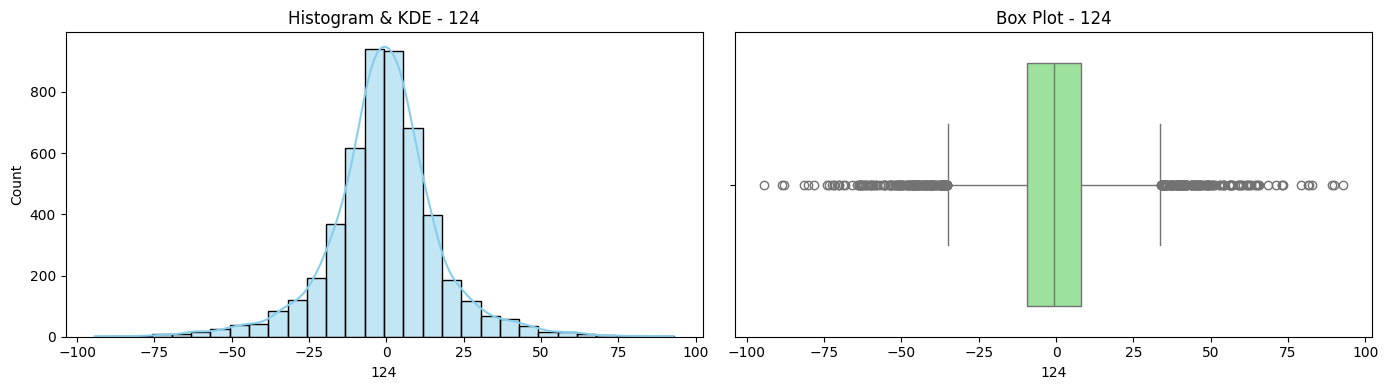

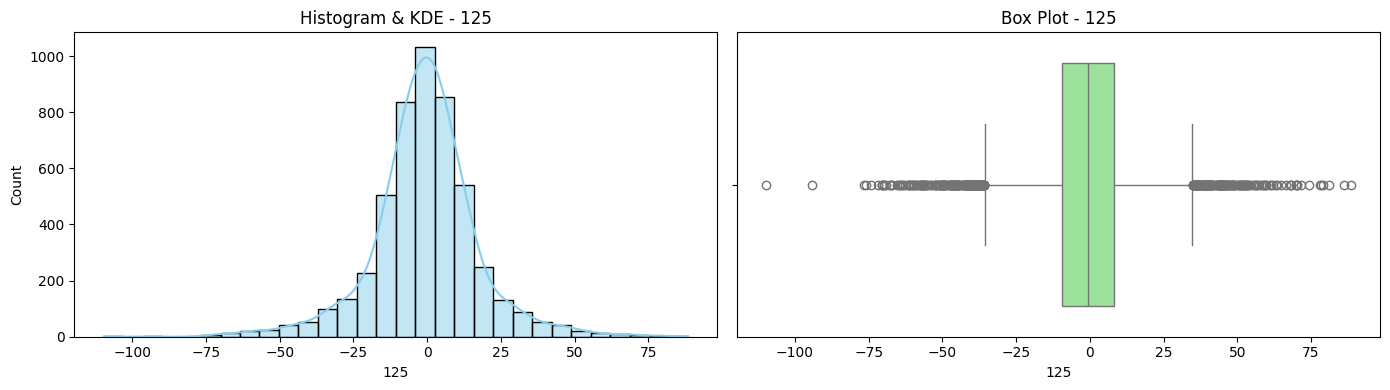

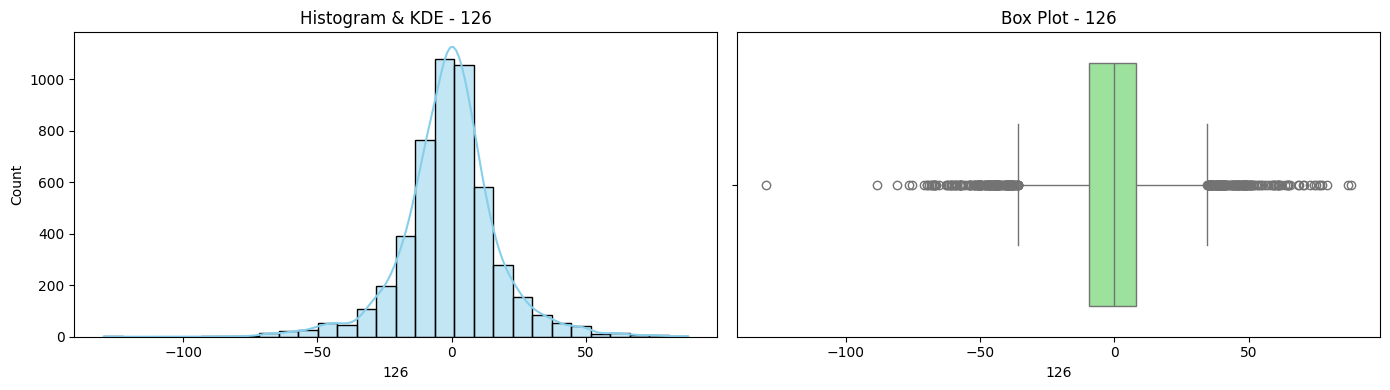

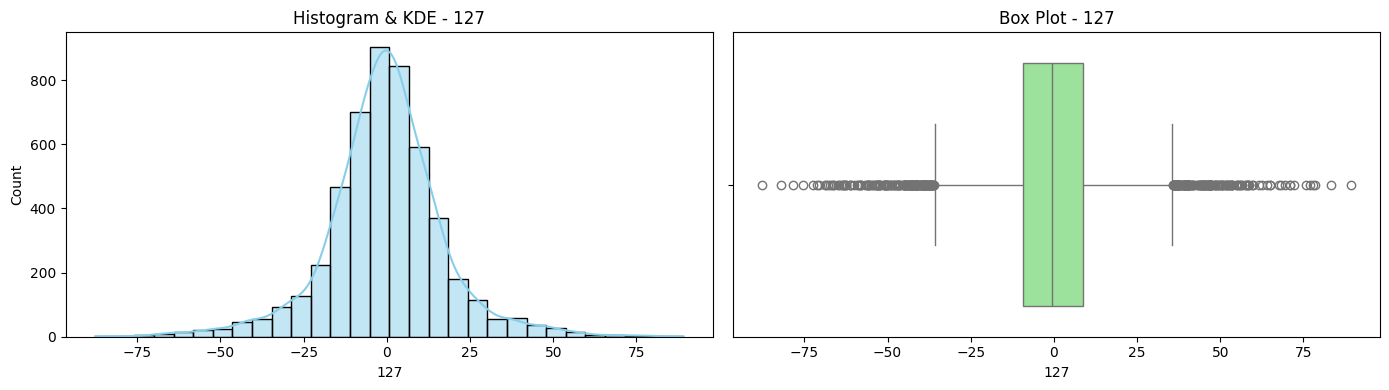

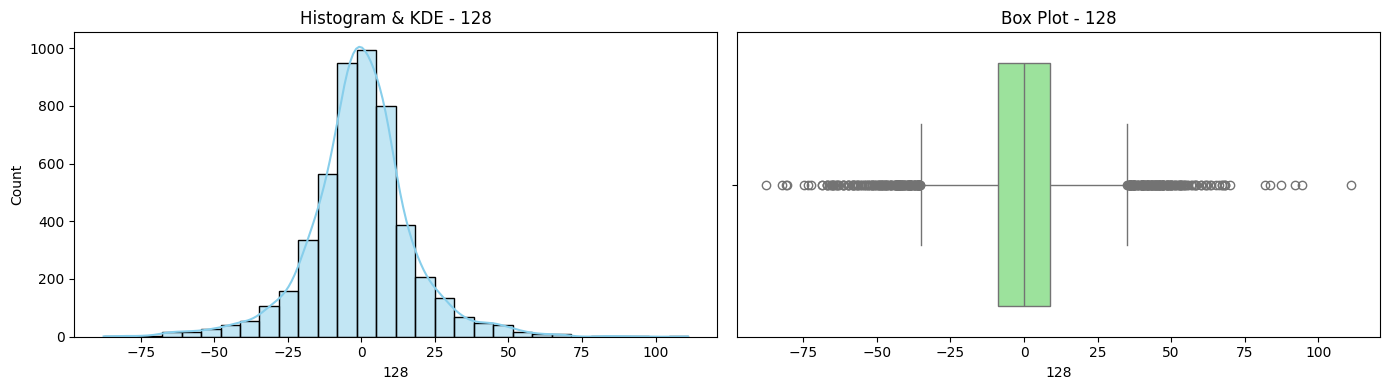

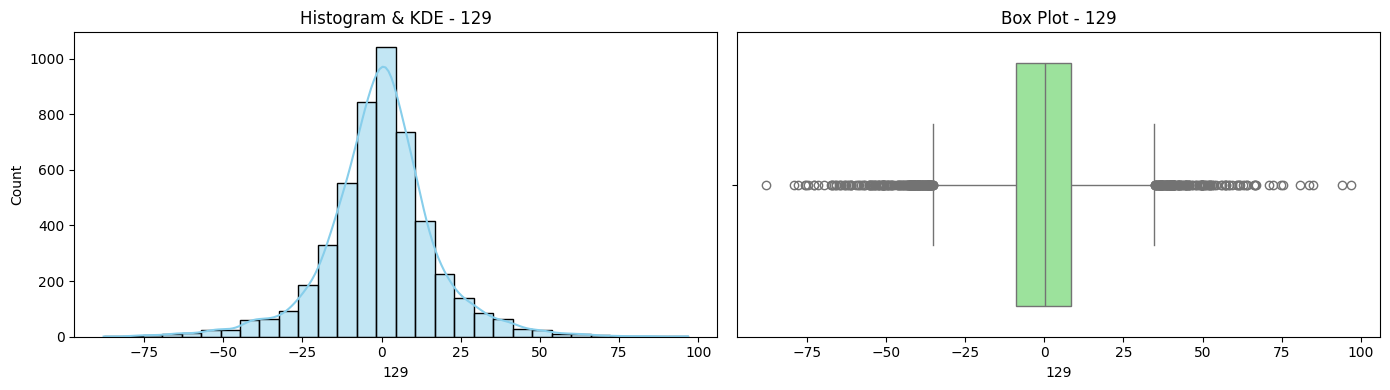

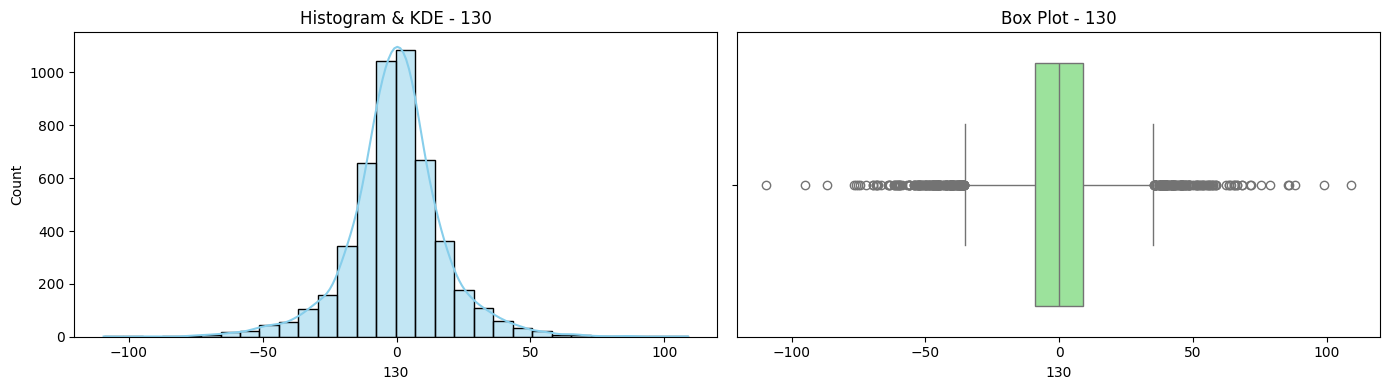

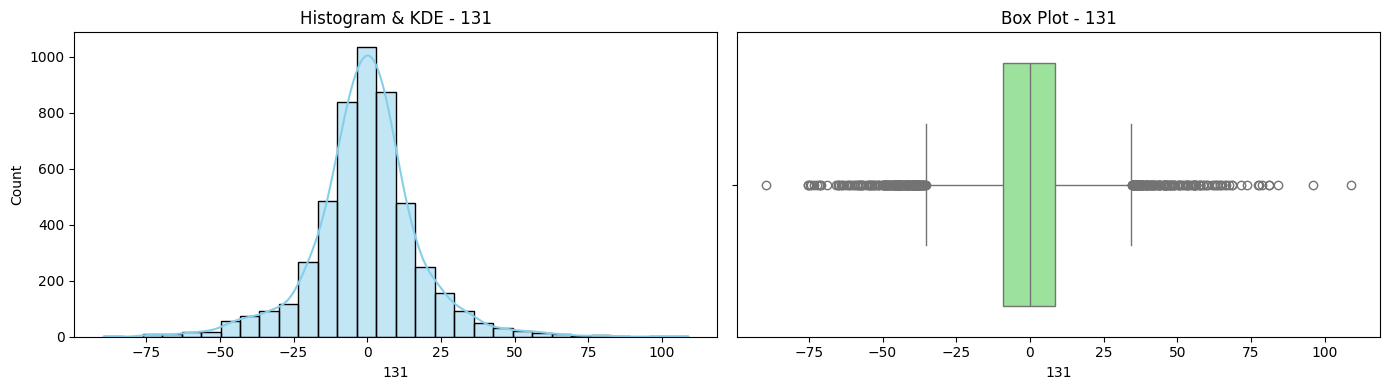

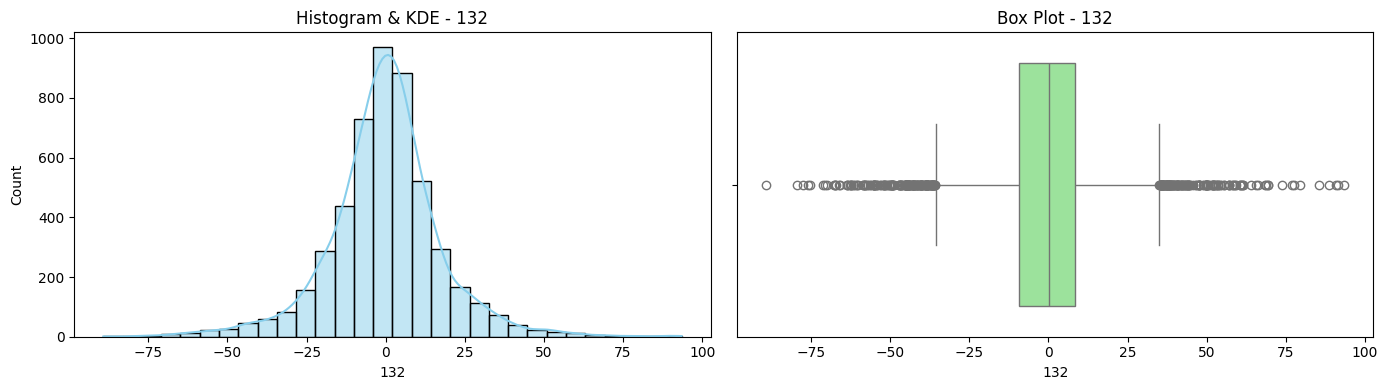

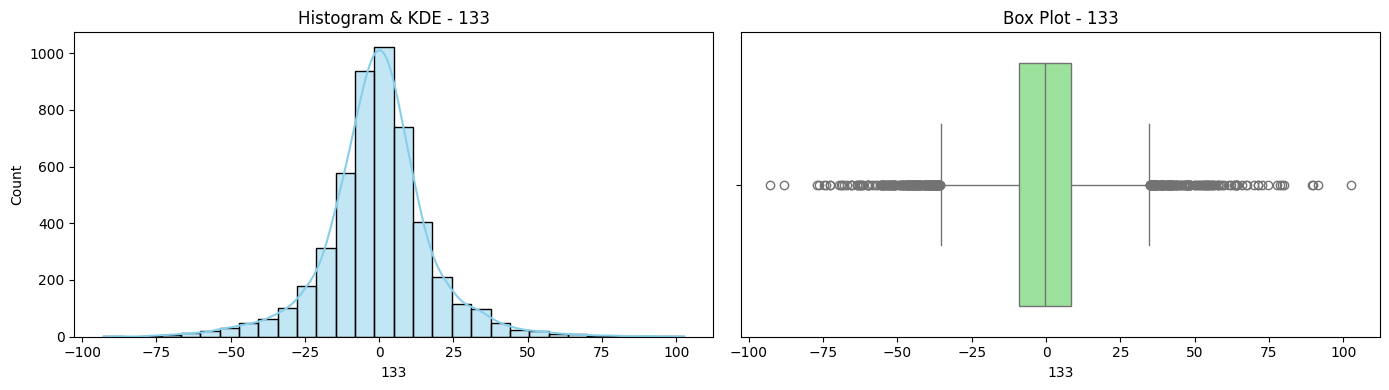

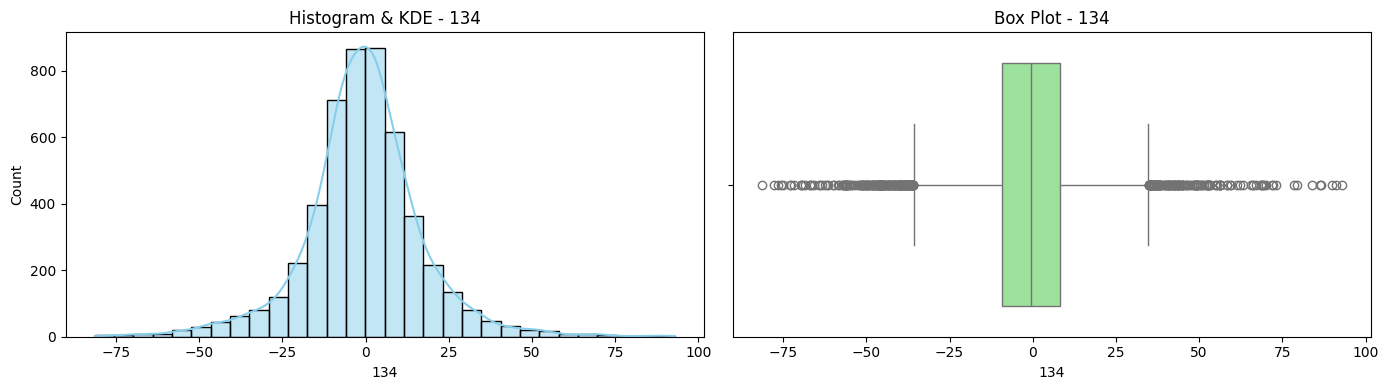

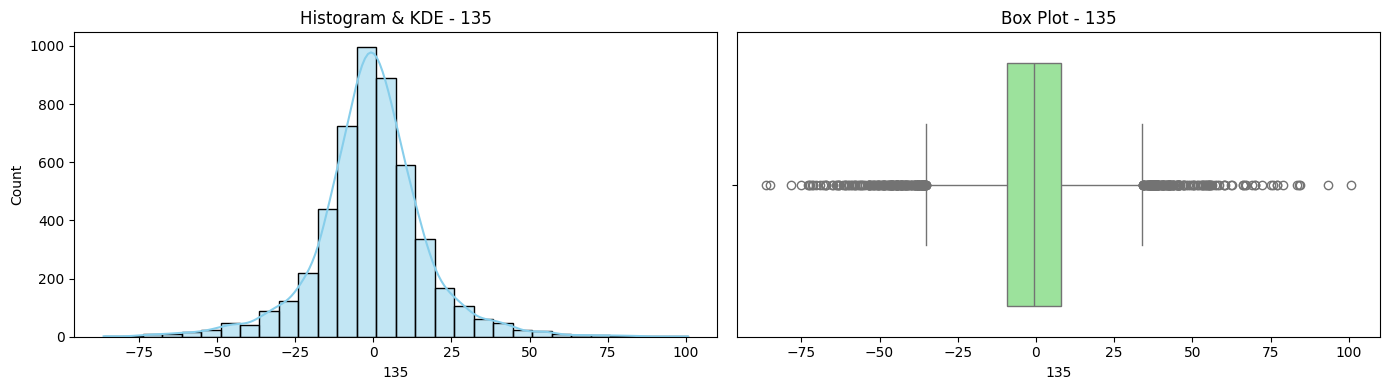

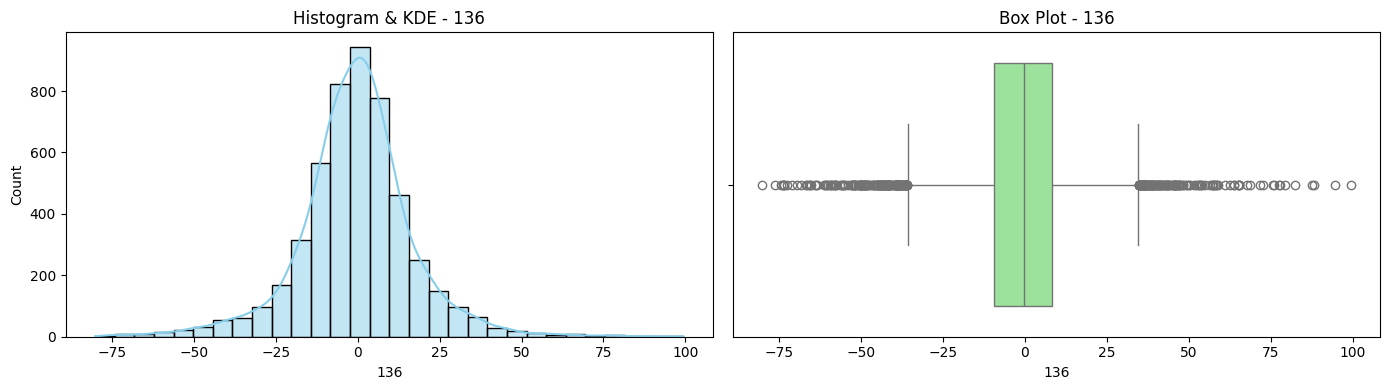

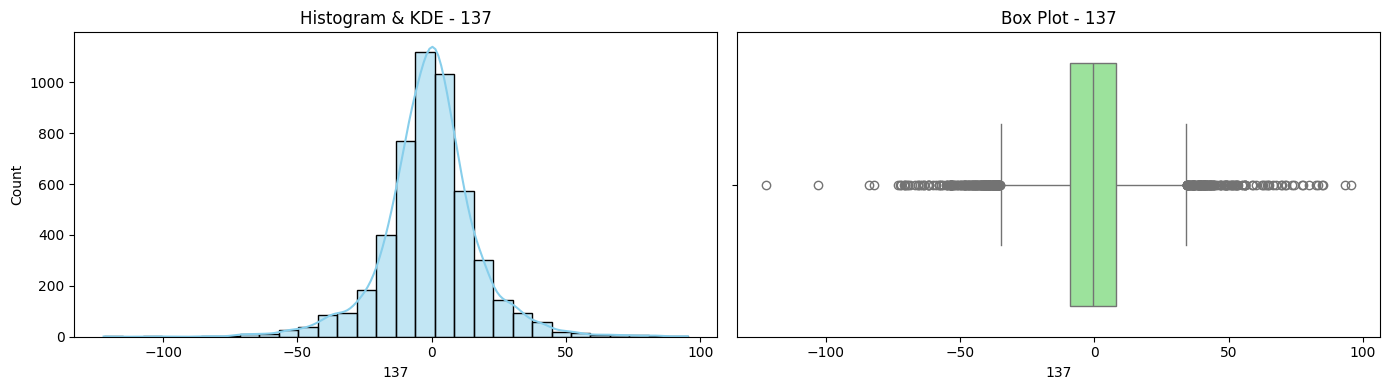

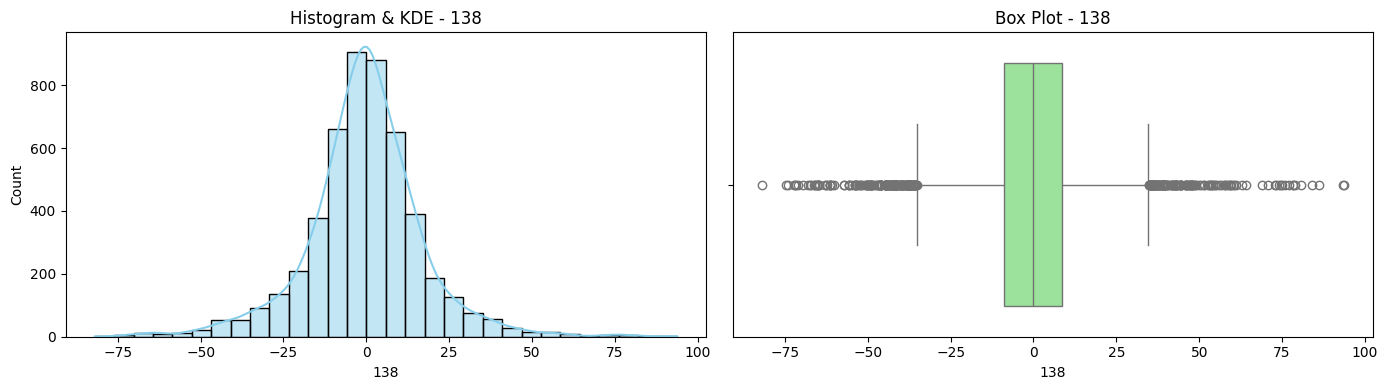

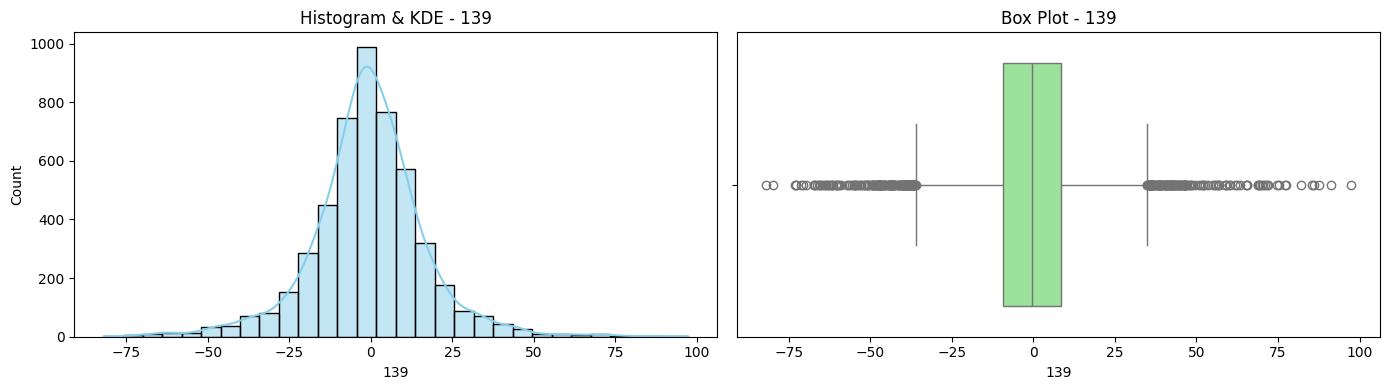

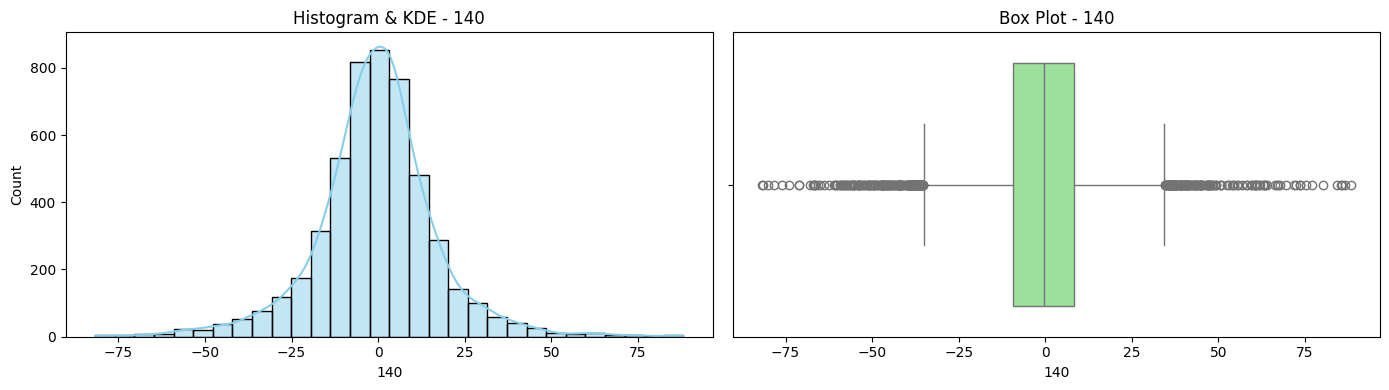

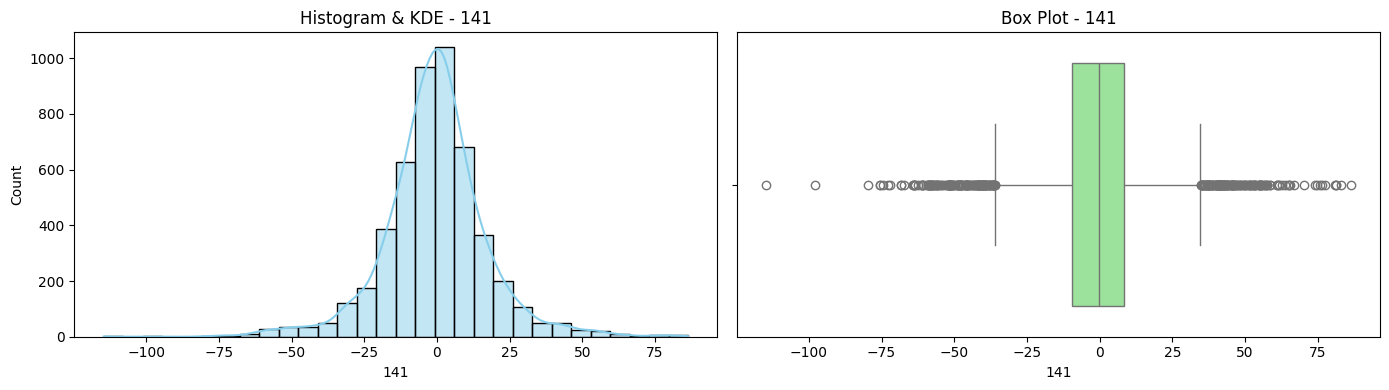

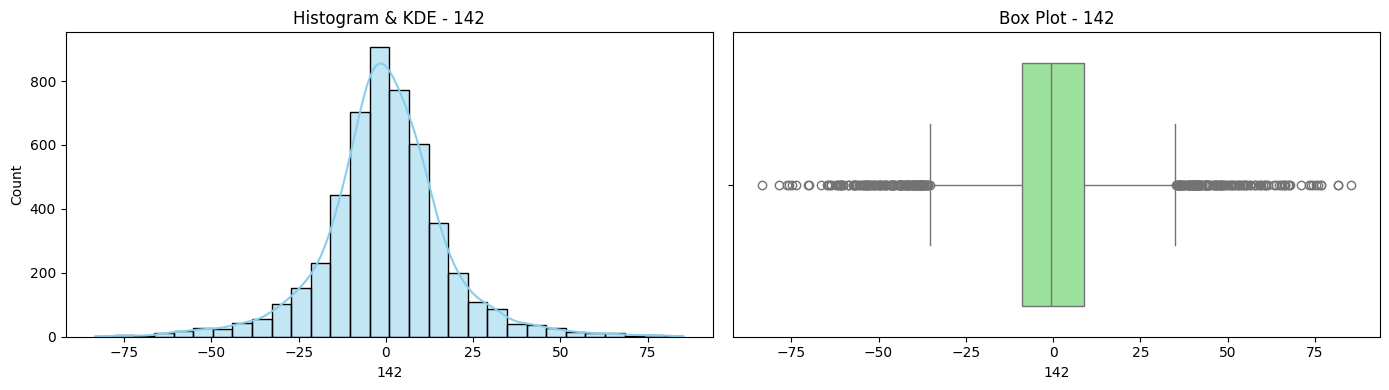

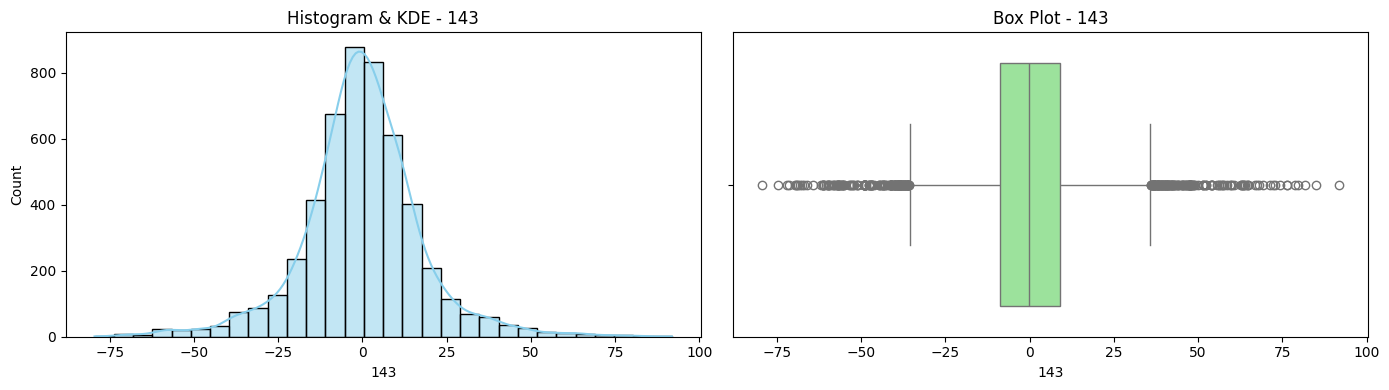

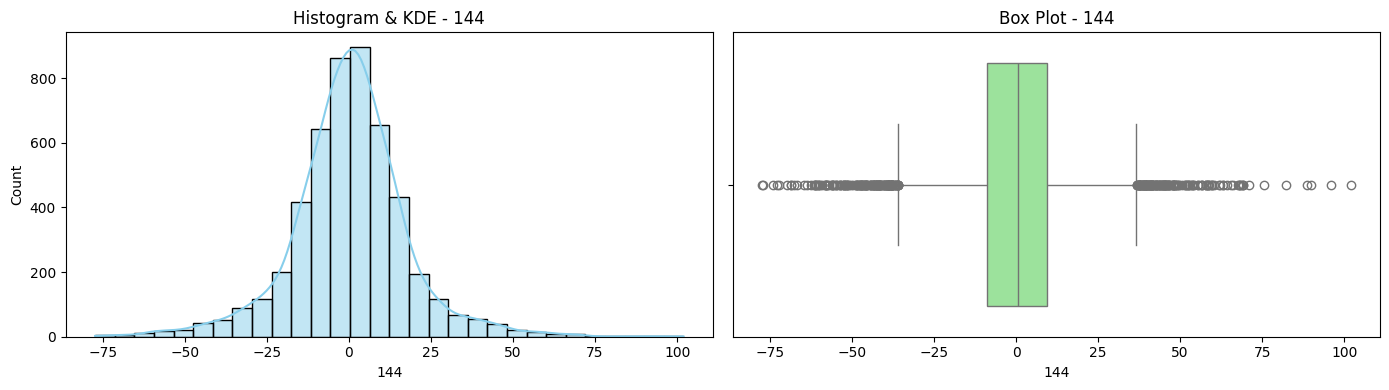

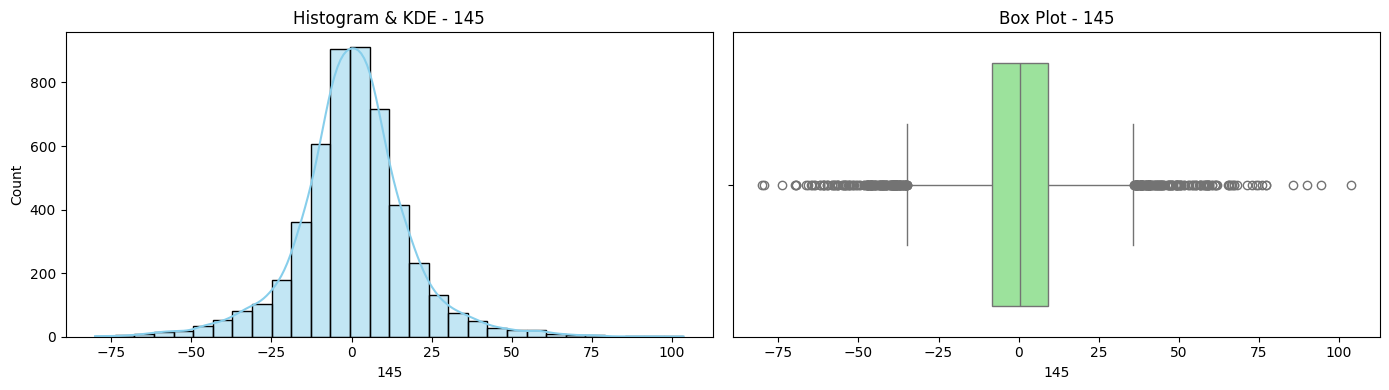

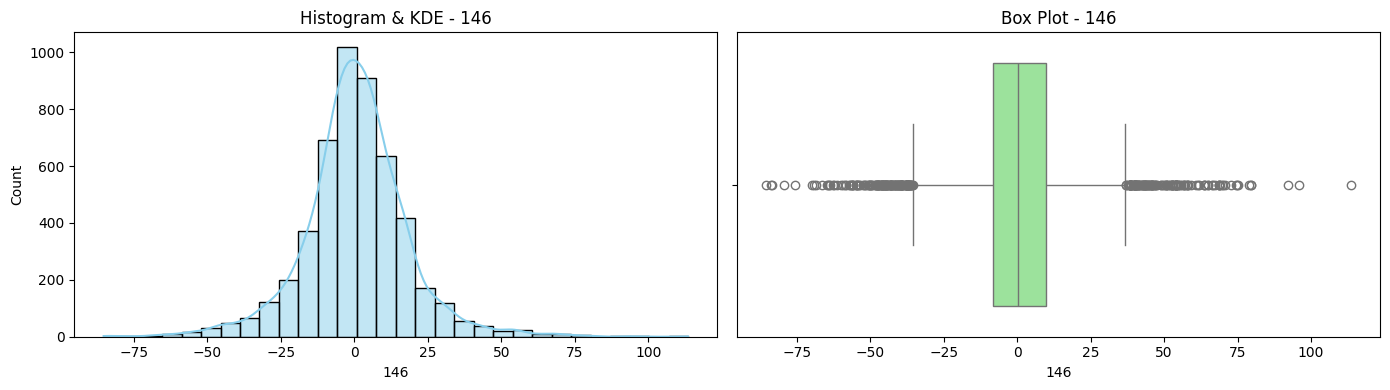

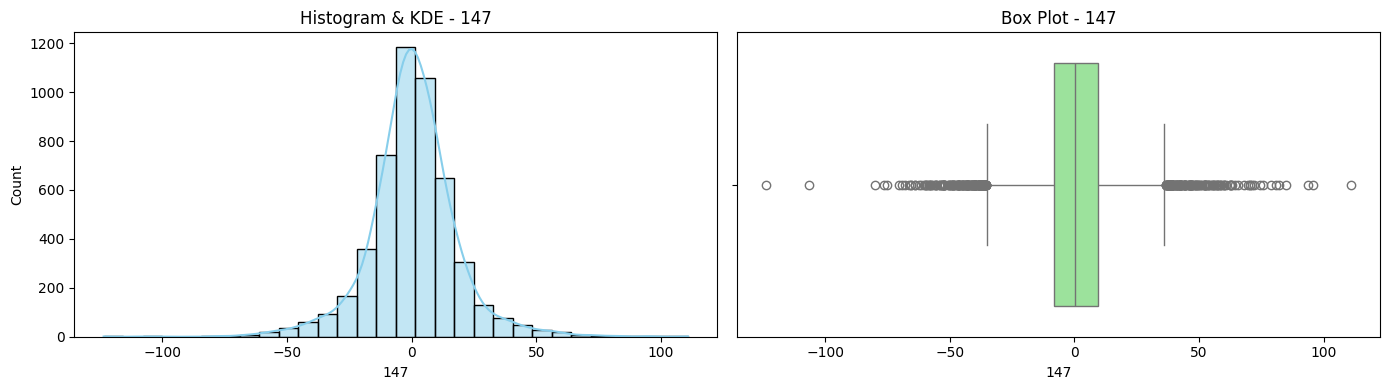

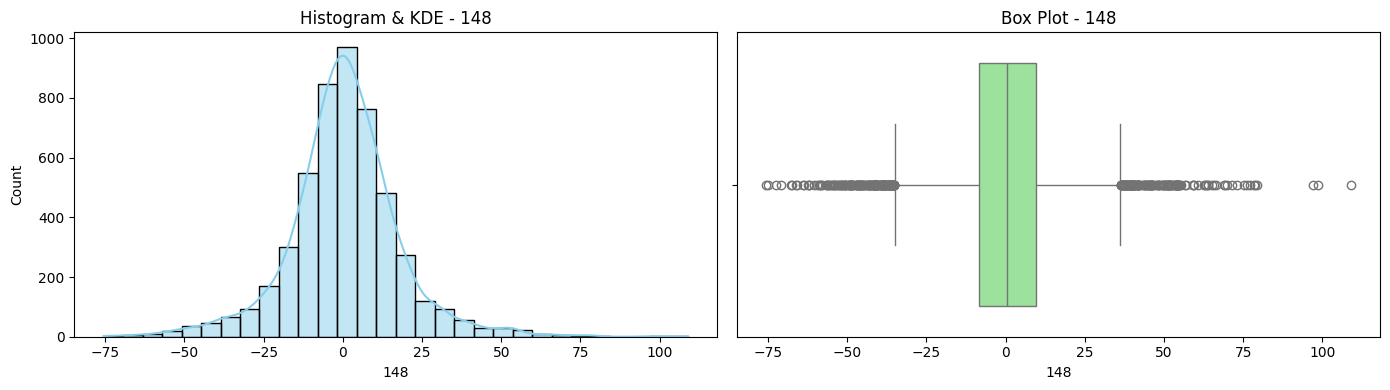

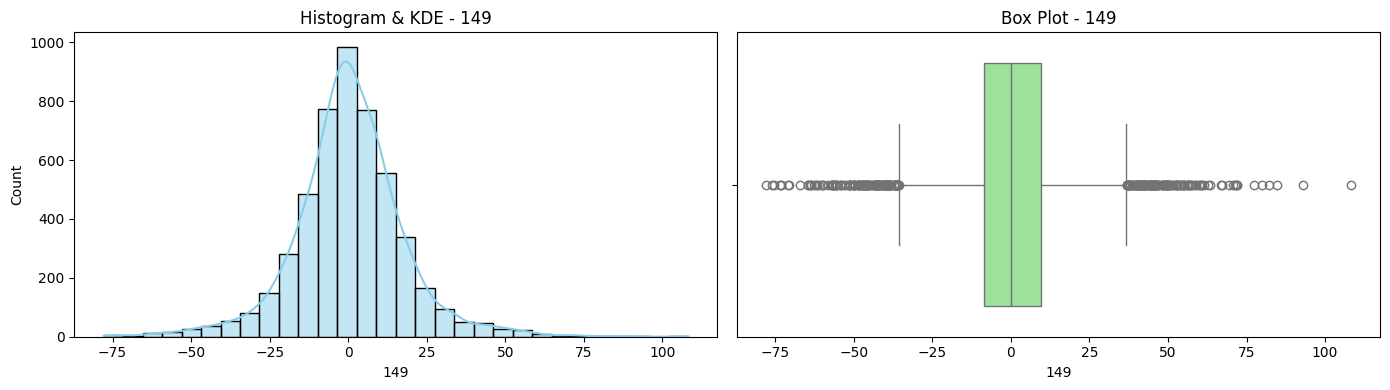

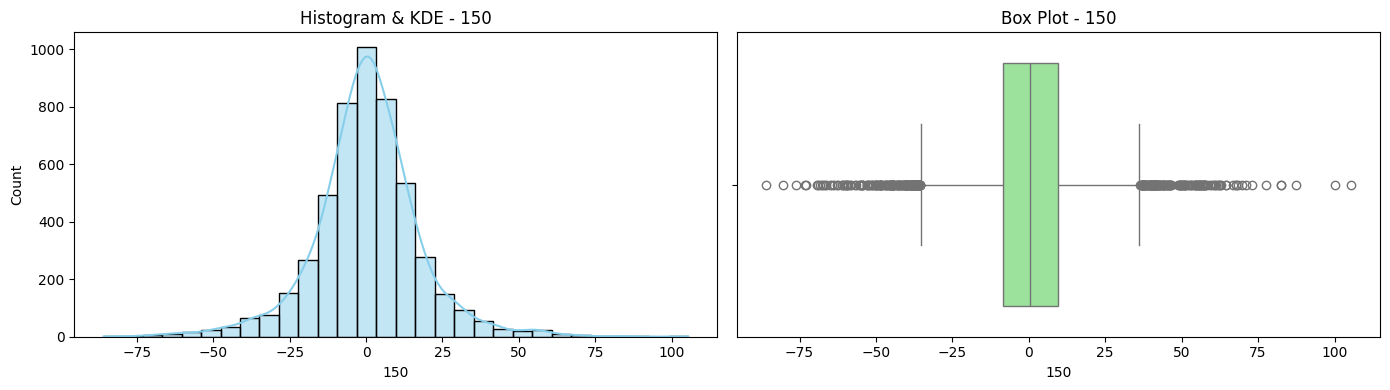

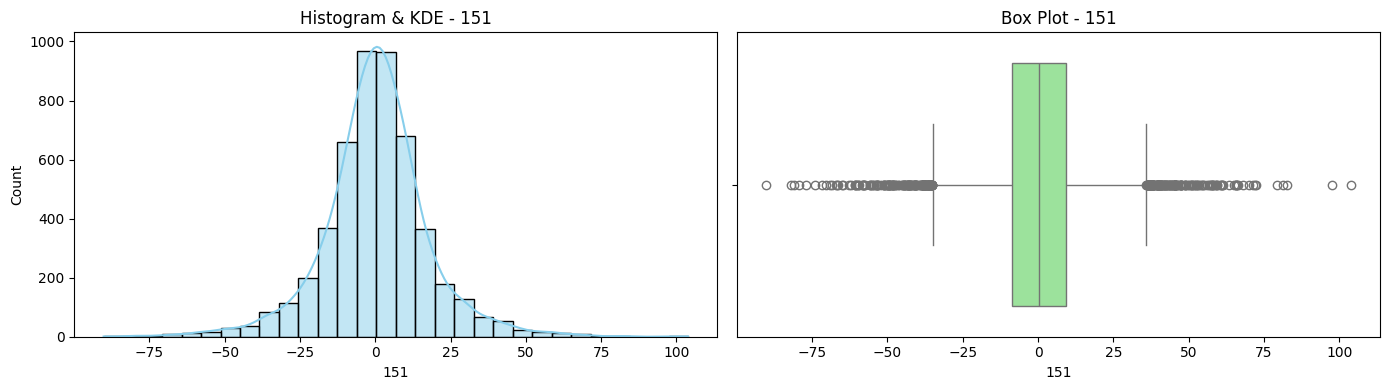

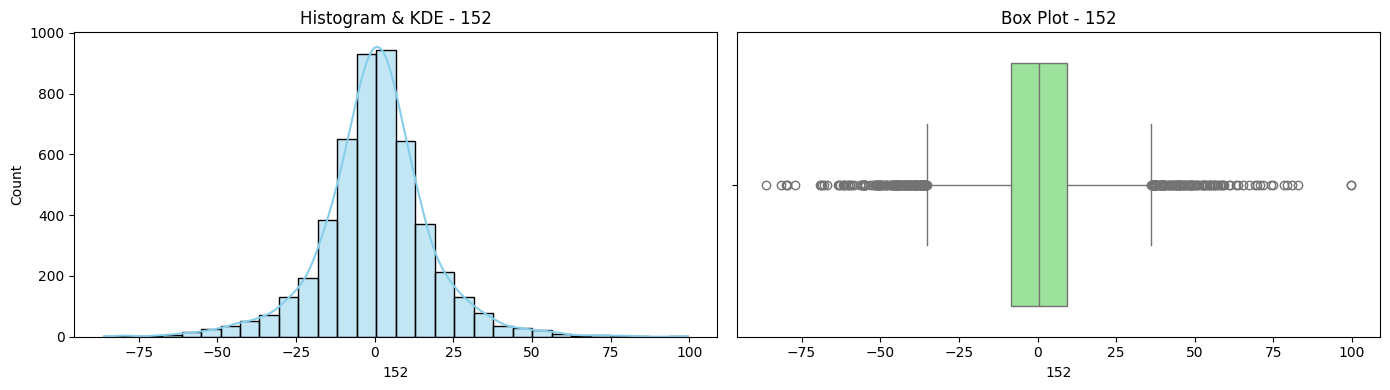

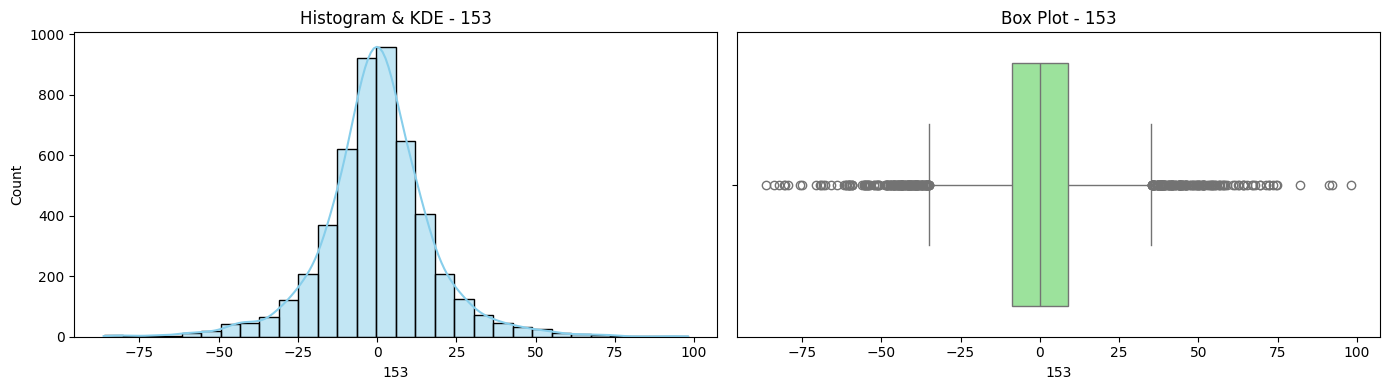

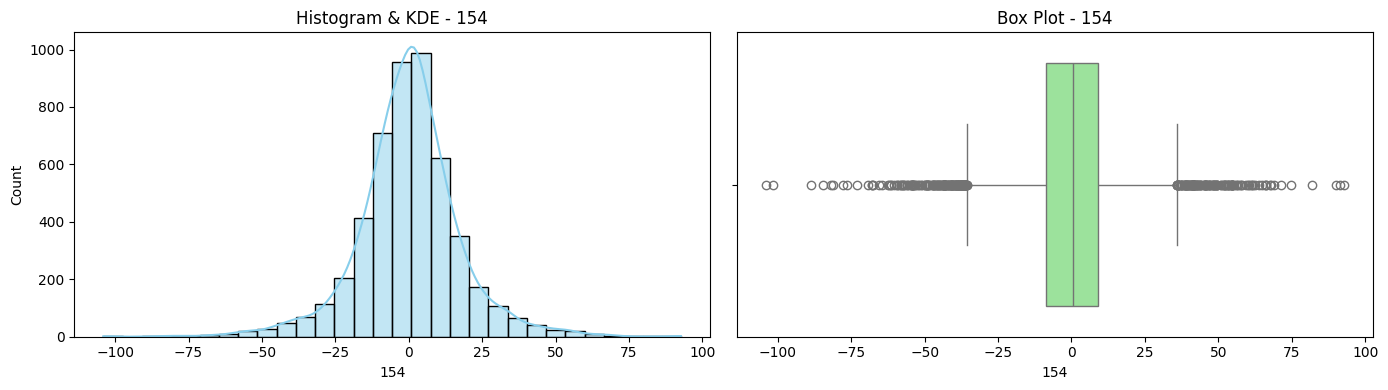

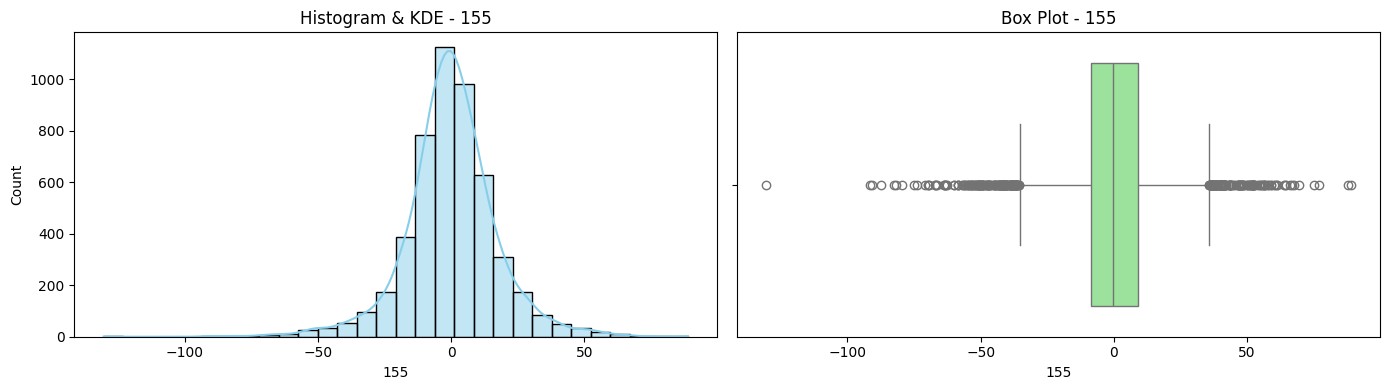

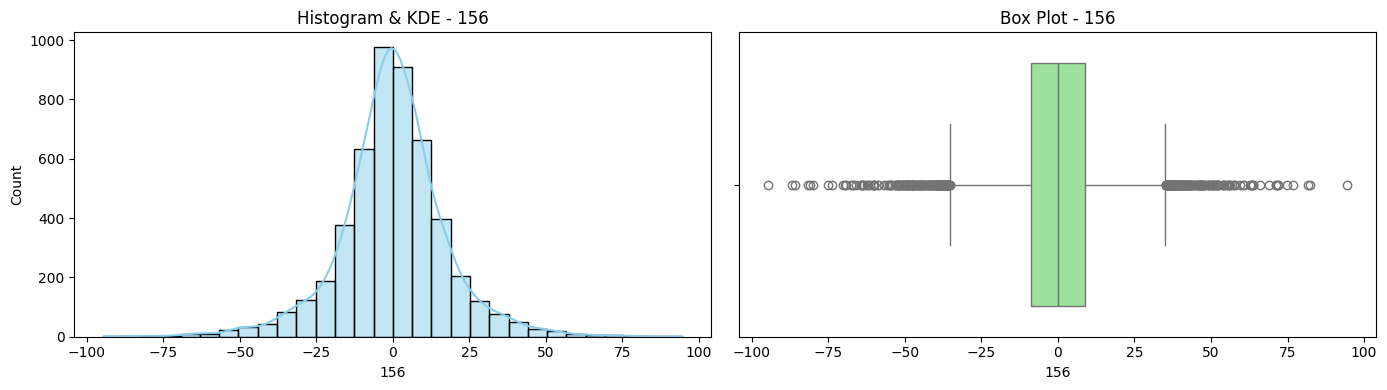

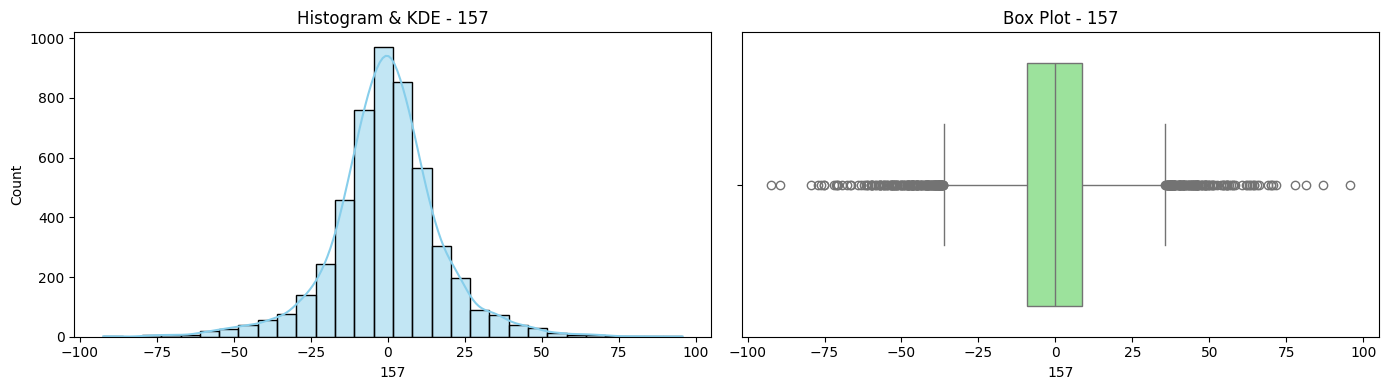

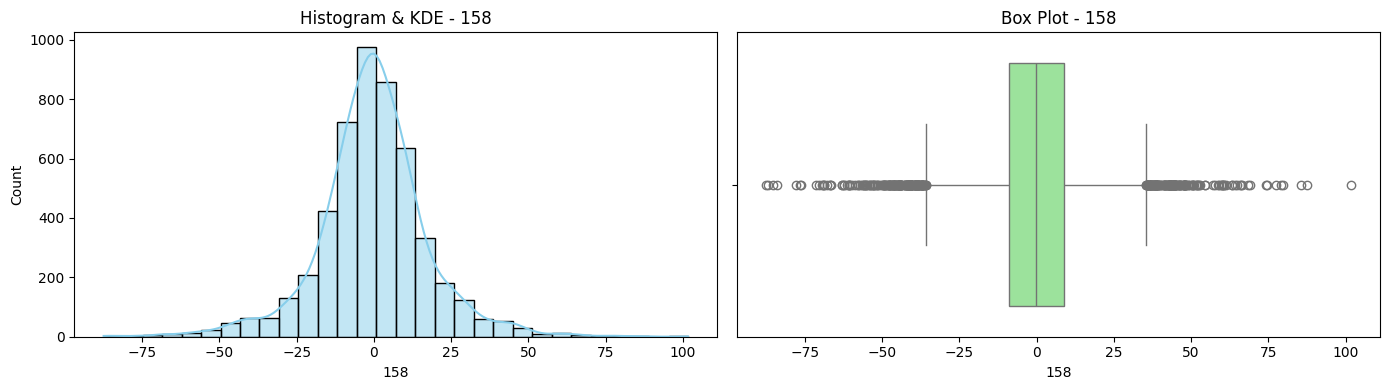

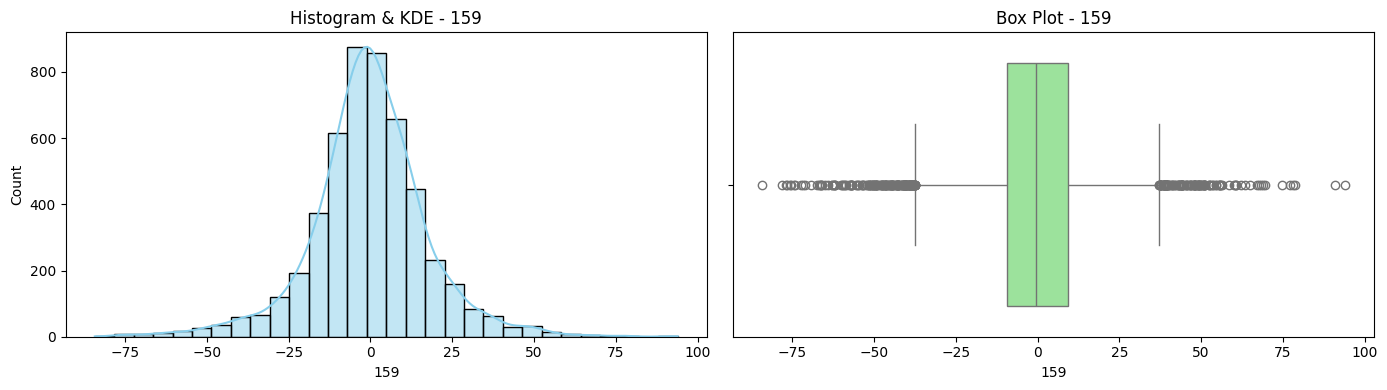

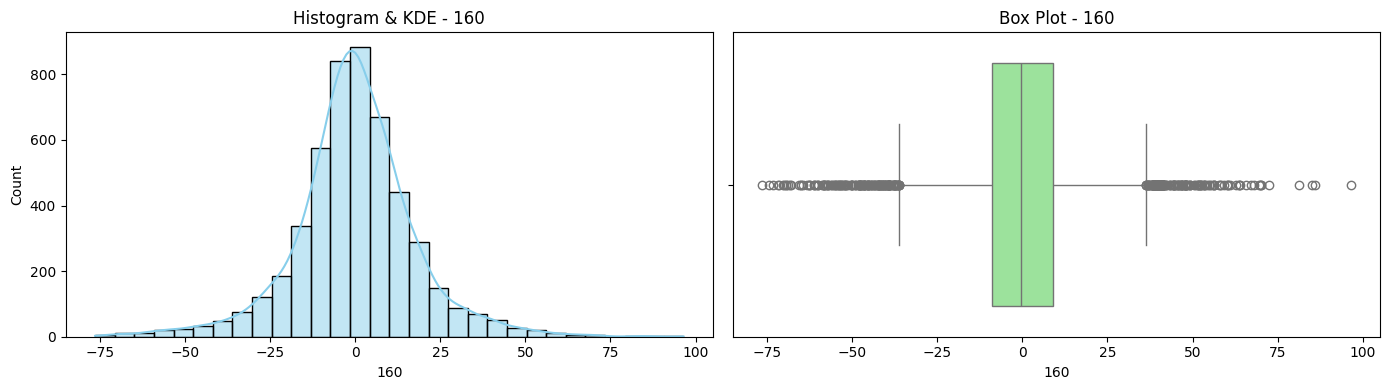

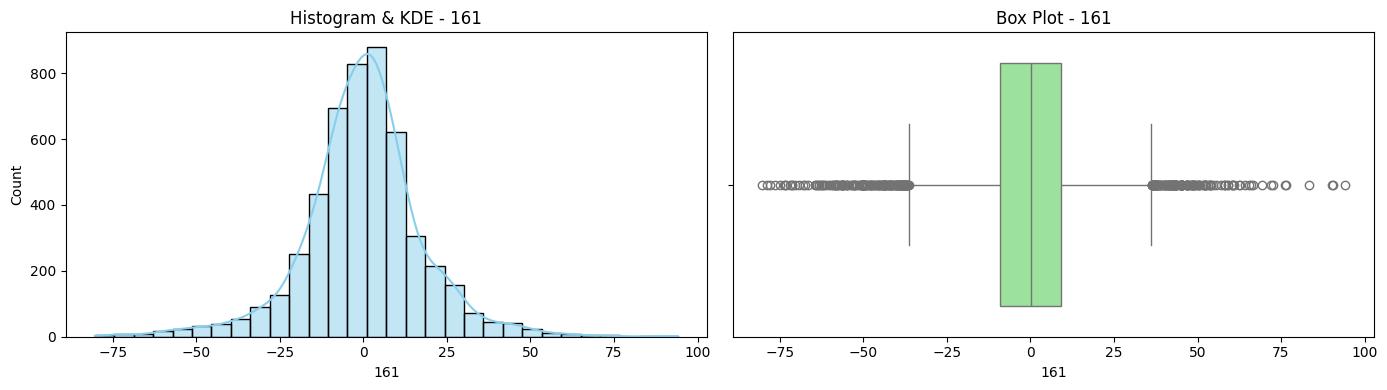

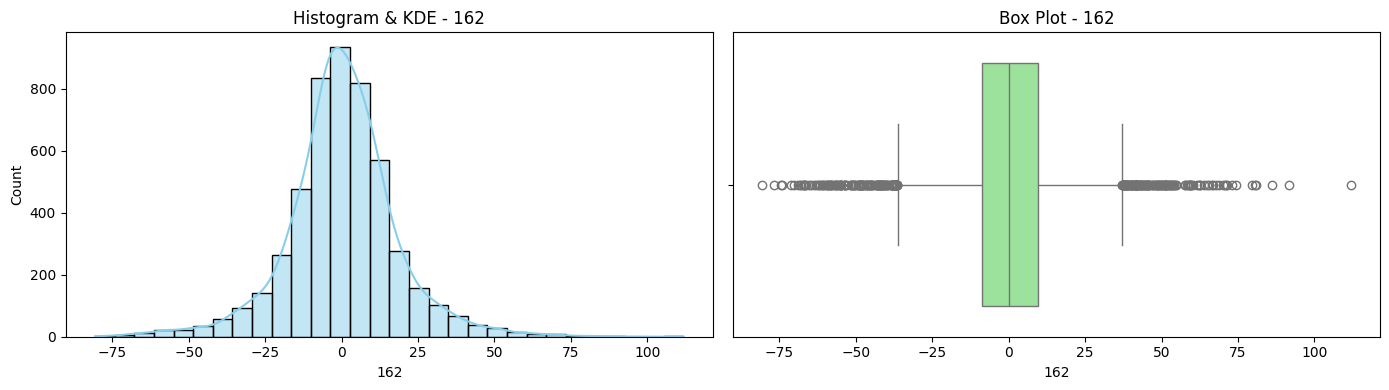

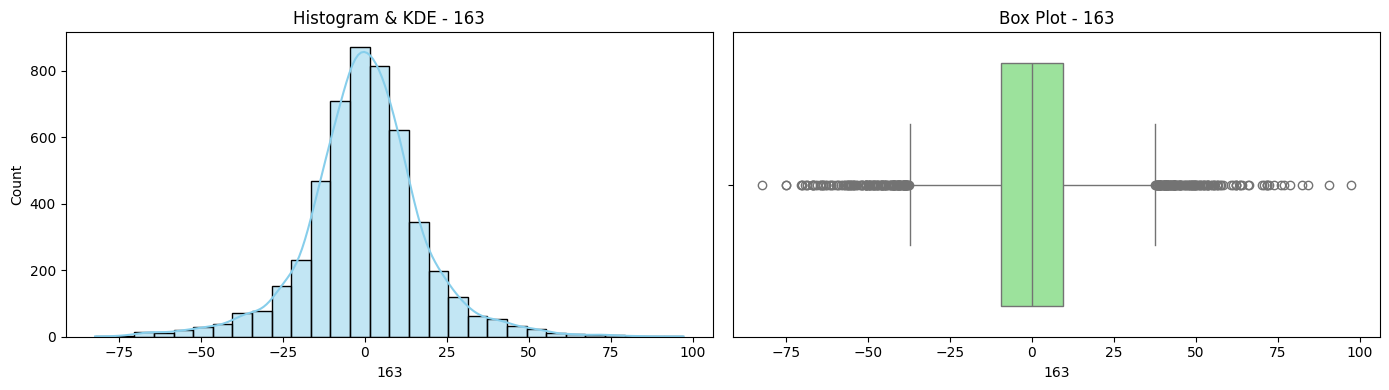

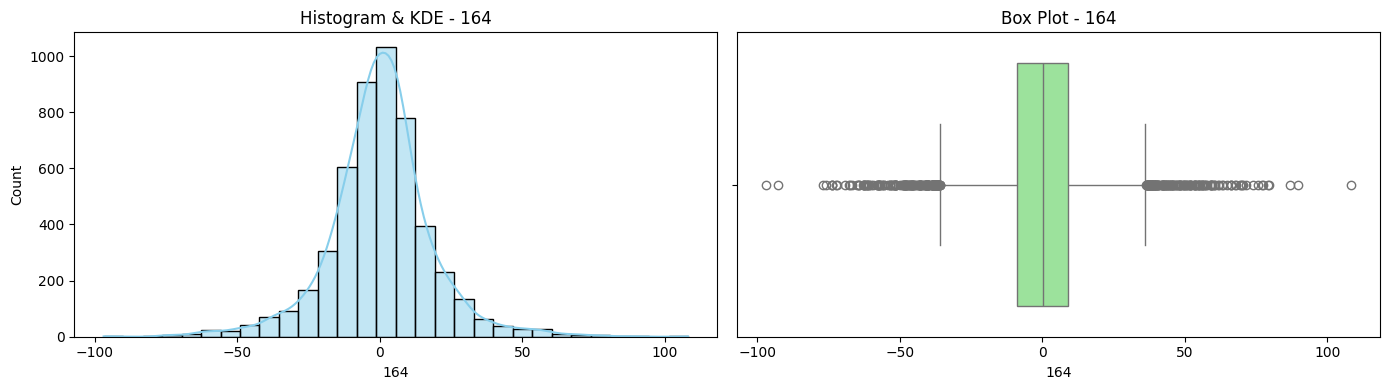

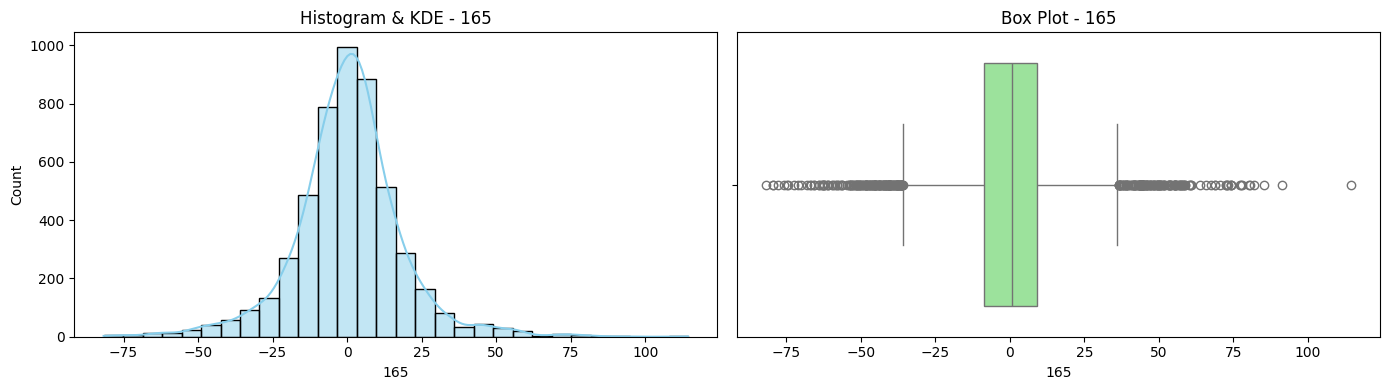

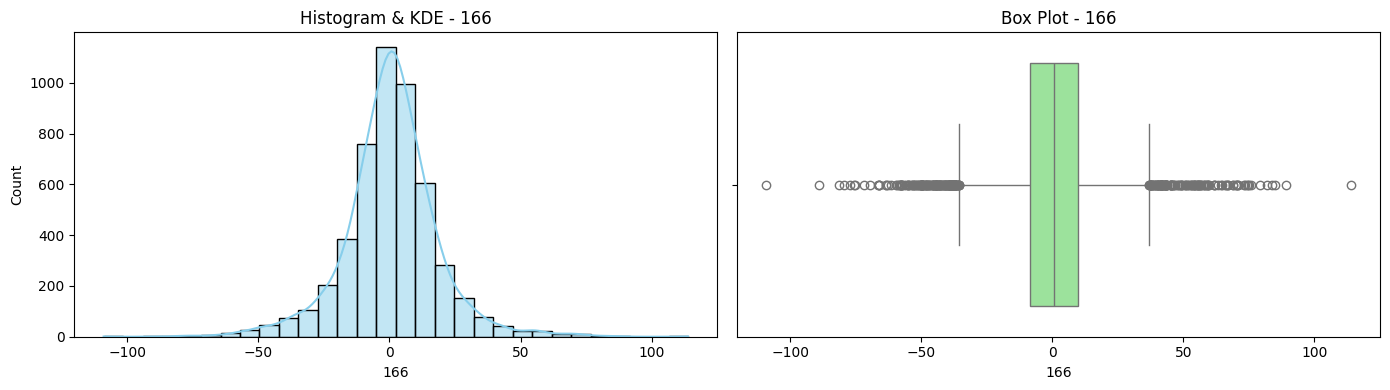

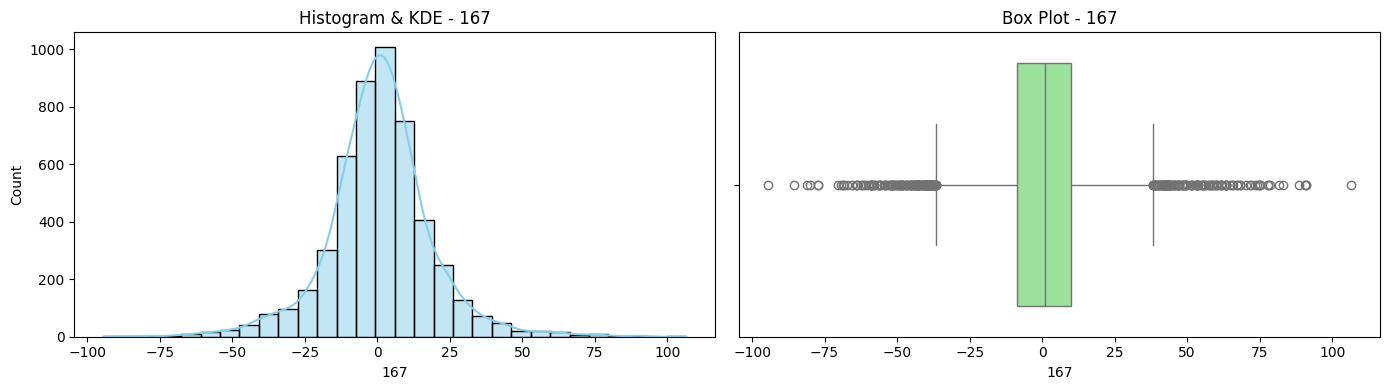

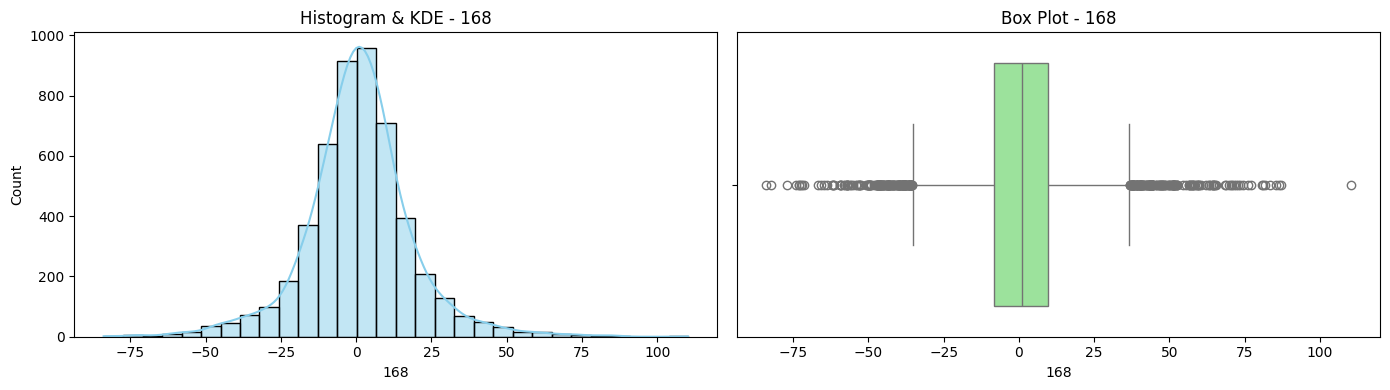

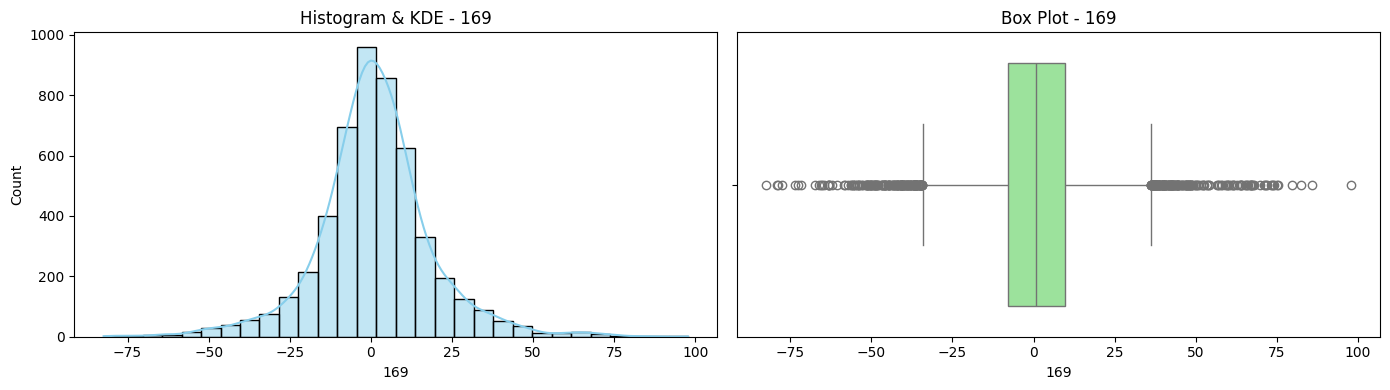

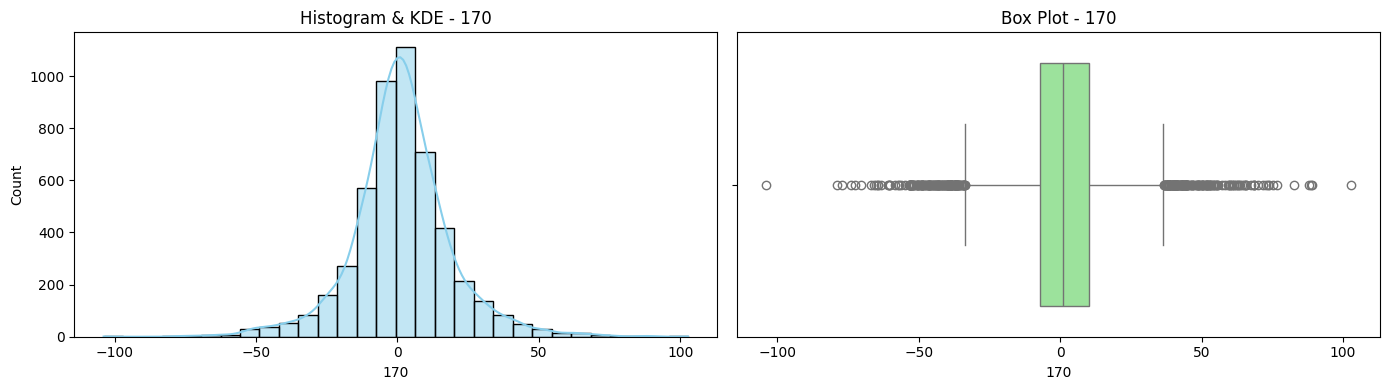

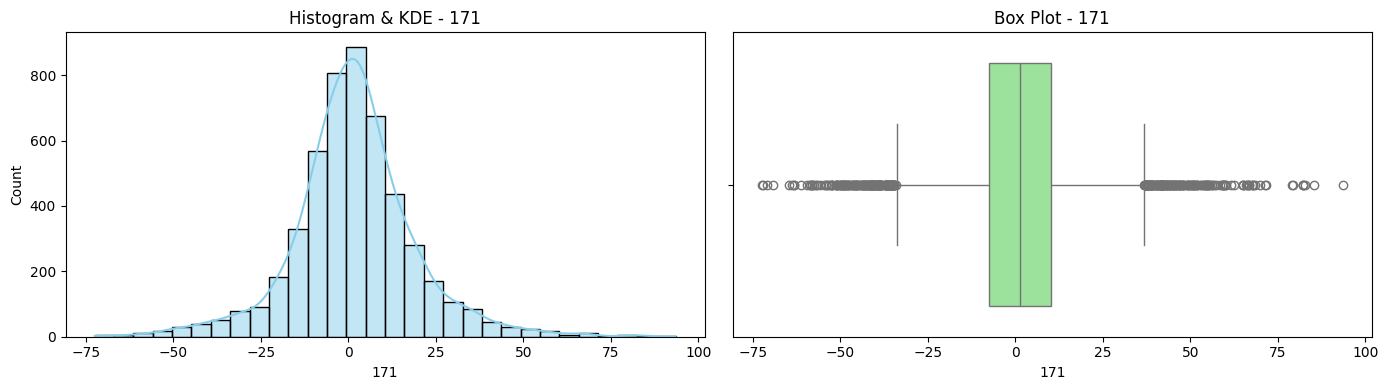

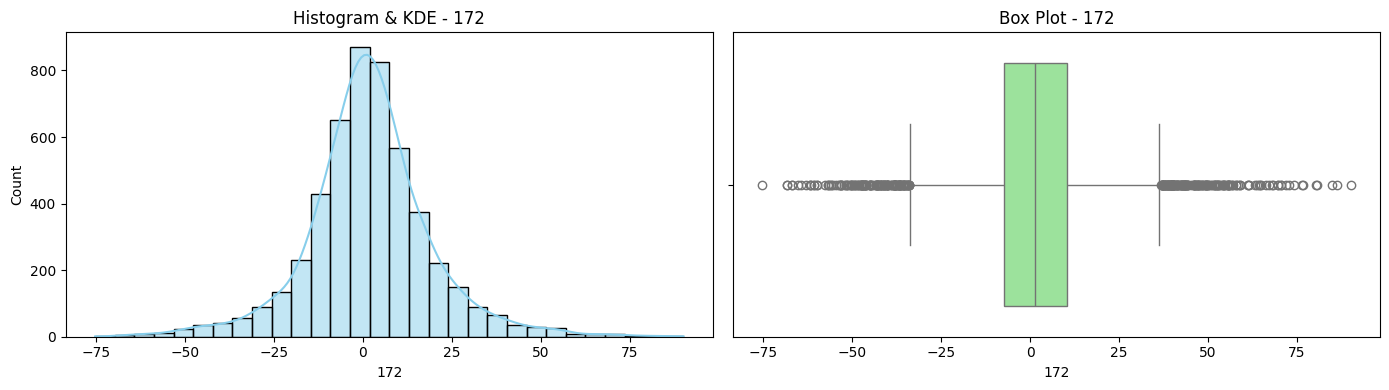

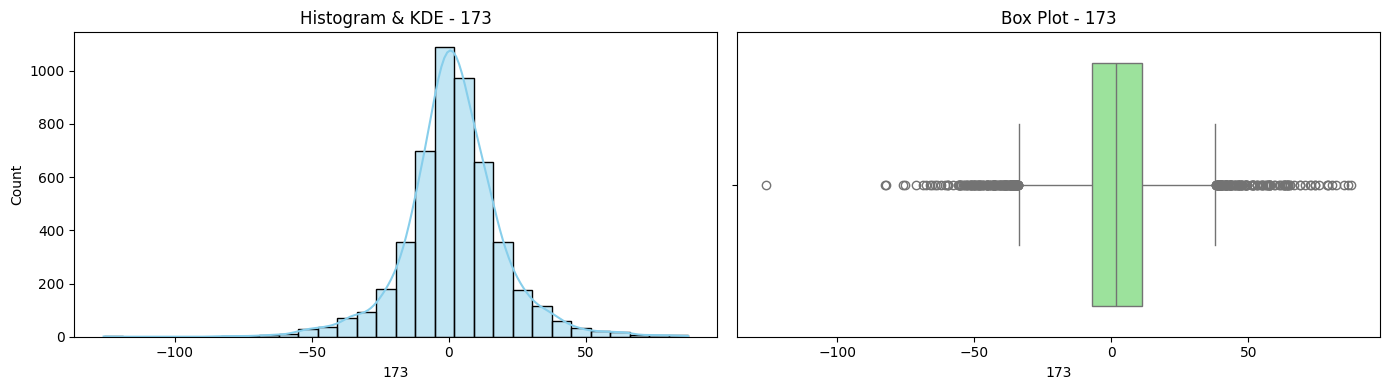

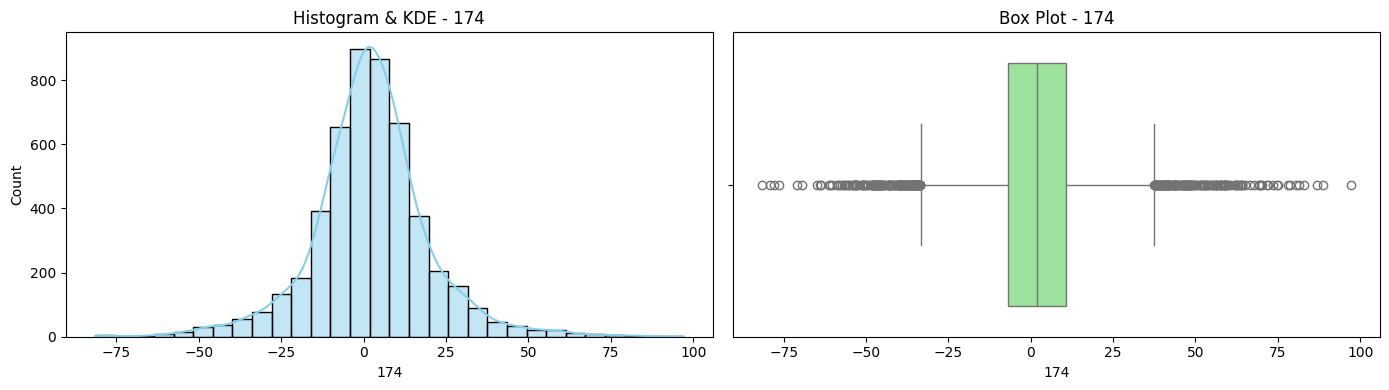

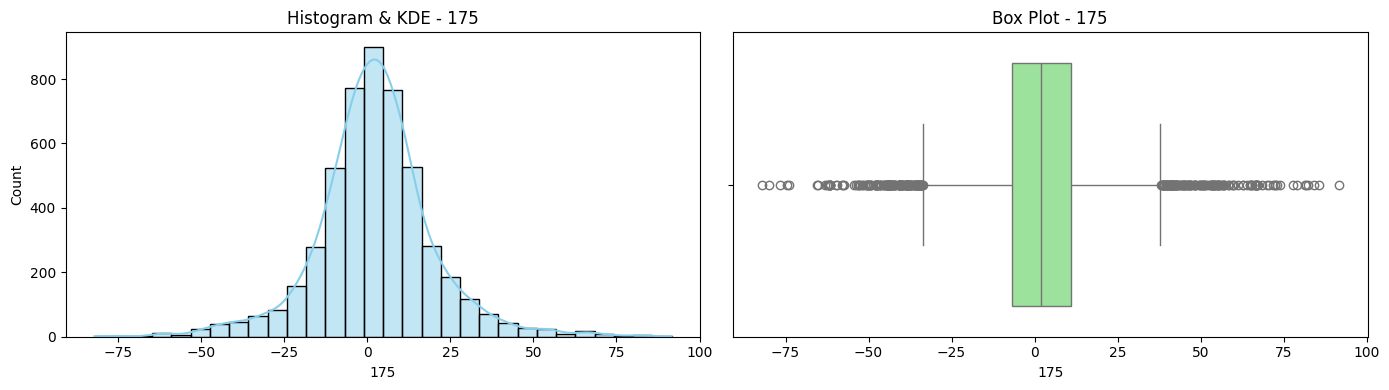

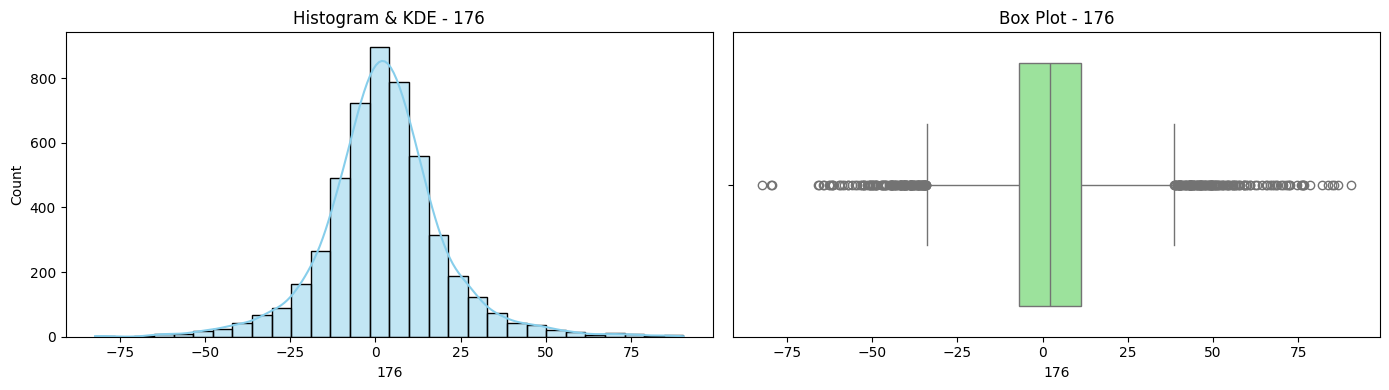

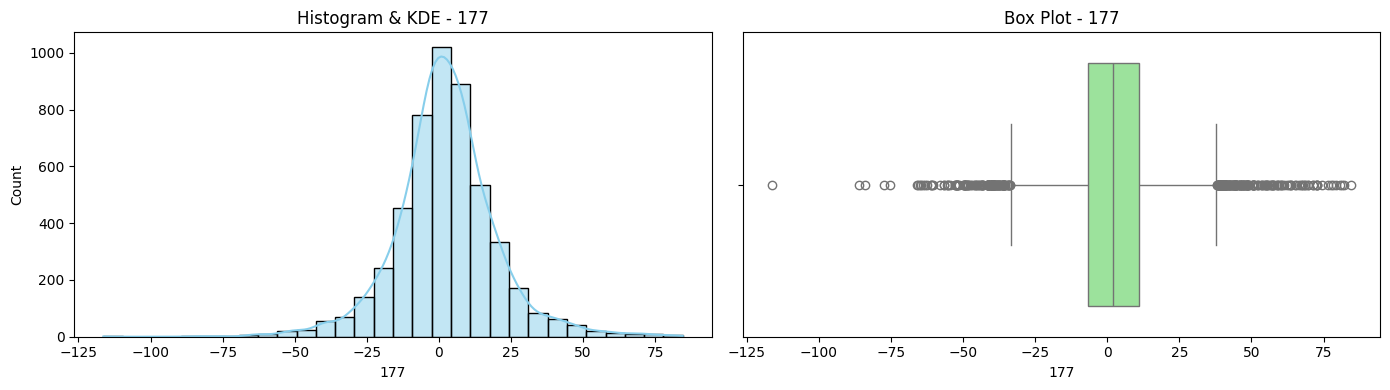

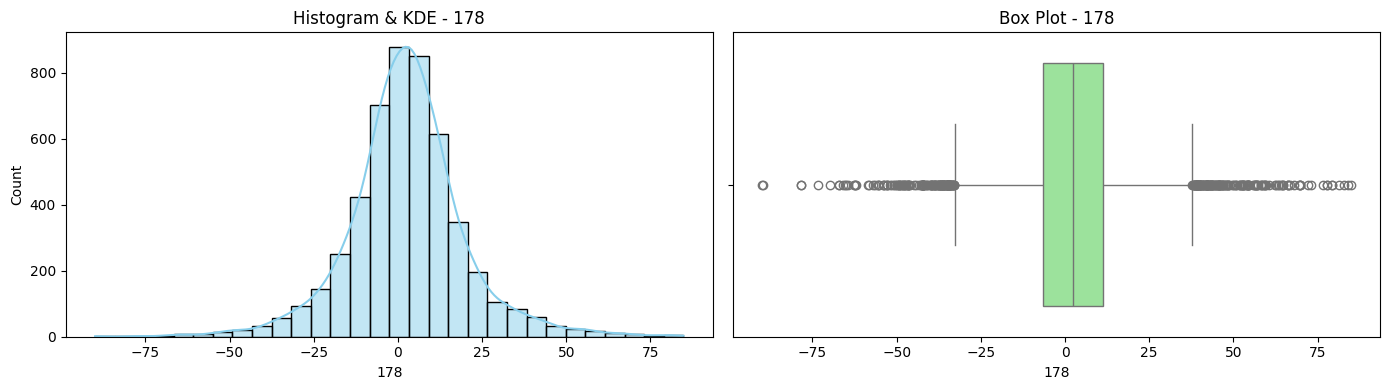


[Exploration] Analyzing feature skewness and outliers...
    Feature  Skewness Distribution  Outliers  Outlier %
0    target     -0.14       Normal       511      10.22
1         1     -0.02       Normal       328       6.56
2         2      0.12       Normal       328       6.56
3         3      0.09       Normal       312       6.24
4         4      0.19       Normal       312       6.24
..      ...       ...          ...       ...        ...
174     174      0.14       Normal       306       6.12
175     175      0.14       Normal       302       6.04
176     176      0.20       Normal       272       5.44
177     177      0.11       Normal       292       5.84
178     178      0.12       Normal       297       5.94

[179 rows x 5 columns]

[Exploration] Correlation heatmap and high correlation pairs...


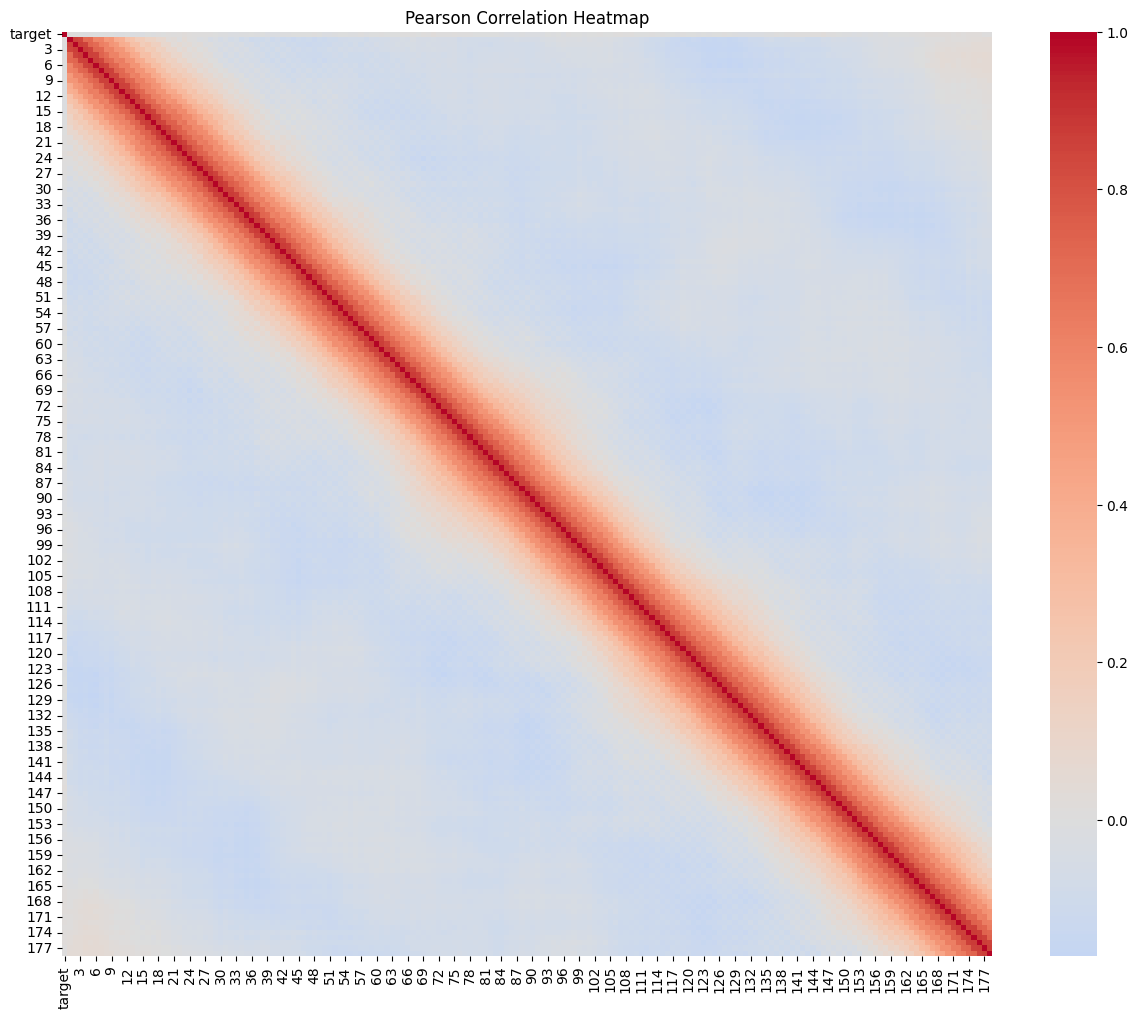


No highly correlated pairs found above threshold.


In [ ]:
run_eda_visualization (initial_dataset)

## 3.3. Process the data


The code cells below perform essential preprocessing on a raw dataset before applying any machine learning models:

- **Missing Values**: Fills missing entries with the median value.
- **Constant Features**: Detects and removes features with no variance.
- **Skewness Check**: Identifies features that are highly skewed.
- **Outlier Detection**: Uses the IQR method to count outliers per feature.
- **Standardization**: Scales numeric features using `StandardScaler`.
- **Feature Report**: Summarizes skewness, distribution type, and outlier percentage for each numeric feature.

This ensures the dataset is clean, scaled, and statistically understood before modeling.

In [ ]:


def preprocess_data(df, target_column=None):
    report = []

    # 1. Separate features and target
    if target_column:
        X = df.drop(columns=[target_column])
        y = df[target_column]
    else:
        X = df.copy()
        y = None

    # 2. Check for missing values
    missing_info = X.isnull().sum()
    missing_cols = missing_info[missing_info > 0].index.tolist()
    if missing_cols:
        report.append(f"Missing values in columns: {missing_cols}")
        X = X.fillna(X.median())  # or use dropna() to remove rows
    else:
        report.append("No missing values detected.")

    # 3. Detect constant features
    constant_cols = [col for col in X.columns if X[col].nunique() == 1]
    if constant_cols:
        report.append(f"Constant features detected and removed: {constant_cols}")
        X.drop(columns=constant_cols, inplace=True)

    # 4. Skewness and outlier info
    skewness = X.apply(lambda x: skew(x.dropna()))
    skewed_features = skewness[abs(skewness) > 1].index.tolist()
    normal_features = skewness[abs(skewness) <= 1].index.tolist()
    report.append(f"Right/left skewed features (|skew| > 1): {skewed_features}")
    report.append(f"Approximately normal features: {normal_features}")

    # 5. Outlier detection (simple IQR method)
    outlier_flags = {}
    for col in X.columns:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((X[col] < (Q1 - 1.5 * IQR)) | (X[col] > (Q3 + 1.5 * IQR))).sum()
        outlier_flags[col] = outliers
    outlier_features = [col for col, count in outlier_flags.items() if count > 0]
    report.append(f"Features containing outliers: {outlier_features}")

    # 6. Standardization
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    if target_column:
        X_scaled[target_column] = y.values  # append target back

    return X_scaled, report



clean_df, summary = preprocess_data(initial_dataset, target_column='target')

# View summary report
for item in summary:
    print(item)

No missing values detected.
Right/left skewed features (|skew| > 1): []
Approximately normal features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178]
Features containing outliers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import warnings
warnings.filterwarnings("ignore")

def analyze_features(df, threshold_skew=0.5):
    report = []

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        feature_data = df[col].dropna()
        sk = skew(feature_data)
        q1 = feature_data.quantile(0.25)
        q3 = feature_data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = ((feature_data < lower_bound) | (feature_data > upper_bound)).sum()

        # Determine skewness type
        if abs(sk) < threshold_skew:
            skew_type = "Normal"
        elif sk > 0:
            skew_type = "Right-skewed"
        else:
            skew_type = "Left-skewed"

        report.append({
            'Feature': col,
            'Skewness': round(sk, 2),
            'Distribution': skew_type,
            'Outliers': outliers,
            'Outlier %': round(outliers / len(feature_data) * 100, 2)
        })

    return pd.DataFrame(report)




summary_df = analyze_features(clean_df)
print(summary_df)

    Feature  Skewness Distribution  Outliers  Outlier %
0         1     -0.02       Normal       328       6.56
1         2      0.12       Normal       328       6.56
2         3      0.09       Normal       312       6.24
3         4      0.19       Normal       312       6.24
4         5      0.03       Normal       312       6.24
..      ...       ...          ...       ...        ...
174     175      0.14       Normal       302       6.04
175     176      0.20       Normal       272       5.44
176     177      0.11       Normal       292       5.84
177     178      0.12       Normal       297       5.94
178  target     -0.14       Normal       511      10.22

[179 rows x 5 columns]


-  All features are approximately normal (|skew| ≤ 1). No missing values.
-  Outliers detected in all features (~6% per feature on average).
-  Data is clean and standardized but may require outlier handling.

 ---

**Plots a Pearson correlation heatmap and lists highly correlated feature pairs above a threshold (default 0.9).**

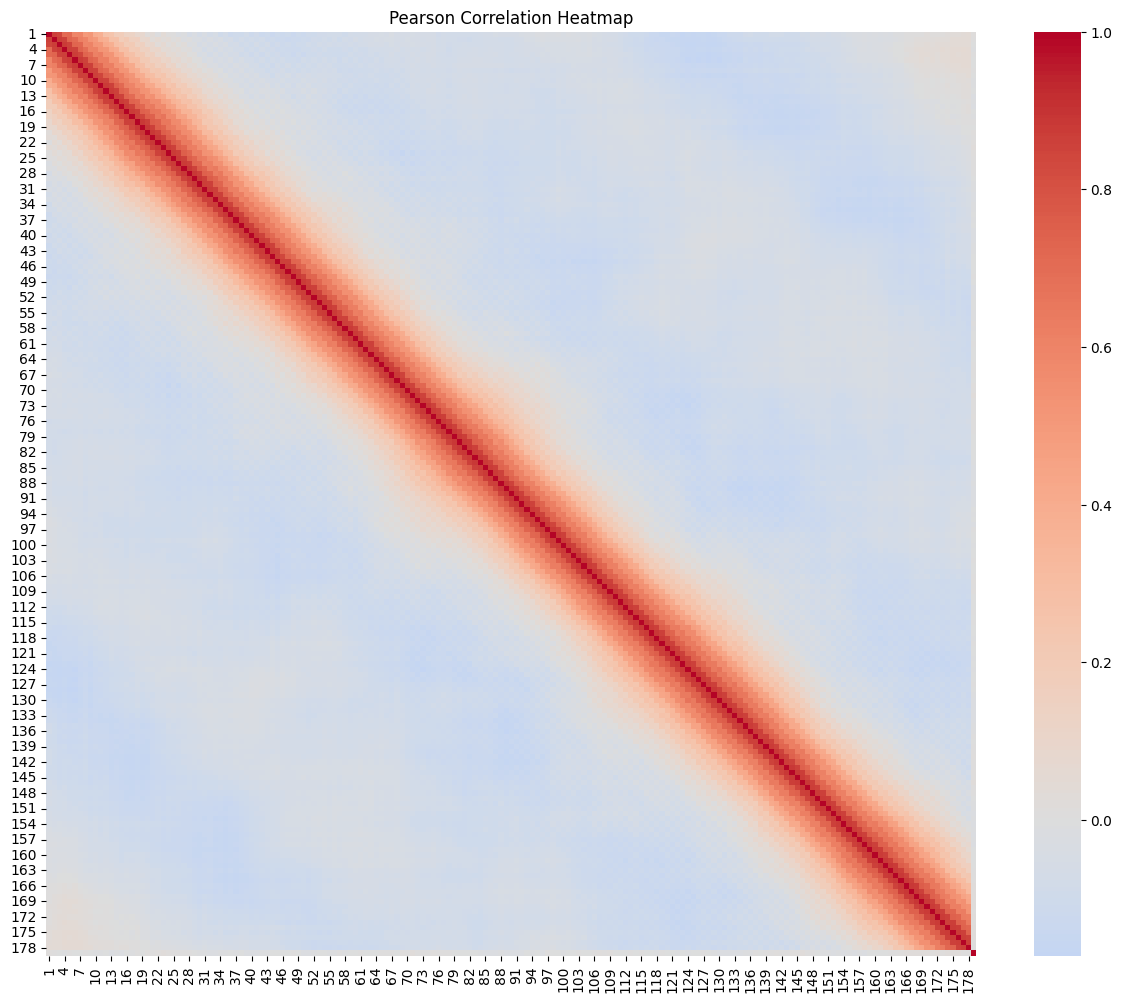


No highly correlated pairs found above threshold.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, method='pearson', figsize=(15, 12), threshold=0.9):
    corr = df.corr(method=method)

    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt=".2f")
    plt.title(f'{method.capitalize()} Correlation Heatmap')
    plt.show()

    # Print highly correlated pairs
    high_corr = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                high_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

    if high_corr:
        print("\nHighly Correlated Pairs (|corr| > {:.2f}):".format(threshold))
        for col1, col2, val in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
            print(f"{col1} <--> {col2} : {val:.2f}")
    else:
        print("\nNo highly correlated pairs found above threshold.")

# Correlation heatmap
plot_correlation_heatmap(clean_df, method='pearson')


From the heatmap above, the strong diagonal line indicates that each feature is perfectly correlated with itself (correlation = 1), while off-diagonal values show how strongly each feature pair is linearly related. The mostly light colors suggest low linear correlation between different EEG channels or features.

# 4.Modeling

## 4.1. XGBoost

###  Modeling Approach

In this section, we build a classification model using **XGBoost**, a powerful gradient boosting algorithm known for its speed and performance.

Given the high dimensionality of the EEG dataset, we first apply **Principal Component Analysis (PCA)** to reduce the number of features while retaining 95% of the original variance. This helps improve model efficiency and mitigate overfitting.

Once the data is transformed, we:
- Train a baseline XGBoost classifier,
- Tune its hyperparameters using **RandomizedSearchCV**, and
- Compare the performance of the initial and optimized models using key classification metrics.

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = initial_dataset.drop('target', axis=1)
y = initial_dataset['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA with a variance explained ratio of 0.95
pca = PCA(n_components=0.95)

# Fit PCA on the training features
pca.fit(X_train)

# Transform both training and testing features
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)
print(X_test_pca.shape)

(3999, 53)
(1000, 53)


In [ ]:
import xgboost as xgb

# Instantiate an XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Train the XGBoost model
xgb_model.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

After training both the initial XGBoost model and the optimized version (using RandomizedSearchCV for hyperparameter tuning), we evaluated their performance on the test set.


In [ ]:
import scipy
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': scipy.stats.uniform(0.01, 0.3),
    'max_depth': scipy.stats.randint(3, 10),
    'n_estimators': scipy.stats.randint(50, 200),
    'subsample': scipy.stats.uniform(0.6, 0.4),
    'colsample_bytree': scipy.stats.uniform(0.6, 0.4),
    'gamma': scipy.stats.uniform(0, 1),
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of iterations
    scoring='accuracy',
    cv=5,  # Number of cross-validation folds
    random_state=42,
    n_jobs=-1,
)

# Fit the randomized search to the data
random_search.fit(X_train_pca, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", random_search.best_params_)

# Store the best estimator
best_xgb_model = random_search.best_estimator_

Best hyperparameters: {'colsample_bytree': np.float64(0.8783251227163527), 'gamma': np.float64(0.8583588048137198), 'learning_rate': np.float64(0.10778767156056542), 'max_depth': 6, 'n_estimators': 196, 'subsample': np.float64(0.884459812975207)}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

# Predictions using the optimized model
y_pred_optimized = best_xgb_model.predict(X_test_pca)

# Performance metrics for the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized, average='weighted', zero_division=0)
recall_optimized = recall_score(y_test, y_pred_optimized, average='weighted', zero_division=0)
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted', zero_division=0)

# Attempt to calculate AUC; handle potential errors gracefully
try:
    y_prob_optimized = best_xgb_model.predict_proba(X_test_pca)
    auc_optimized = roc_auc_score(y_test, y_prob_optimized, multi_class='ovr')
except Exception as e:
    print(f"Error calculating AUC for optimized model: {e}")
    auc_optimized = np.nan  # Or handle differently

# Train and evaluate the initial XGBoost model (if metrics not available)
try:
    # Assuming xgb_model is the initial model
    y_pred_initial = xgb_model.predict(X_test_pca)

    accuracy_initial = accuracy_score(y_test, y_pred_initial)
    precision_initial = precision_score(y_test, y_pred_initial, average='weighted', zero_division=0)
    recall_initial = recall_score(y_test, y_pred_initial, average='weighted', zero_division=0)
    f1_initial = f1_score(y_test, y_pred_initial, average='weighted', zero_division=0)

    try:
        y_prob_initial = xgb_model.predict_proba(X_test_pca)
        auc_initial = roc_auc_score(y_test, y_prob_initial, multi_class='ovr')
    except Exception as e:
        print(f"Error calculating AUC for initial model: {e}")
        auc_initial = np.nan
except NameError:  # Handle if xgb_model is not defined
    print("Initial xgb_model not found. Cannot evaluate initial model's performance.")
    accuracy_initial, precision_initial, recall_initial, f1_initial, auc_initial = [np.nan] * 5

# Create a comparison table
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
    'Optimized Model': [accuracy_optimized, precision_optimized, recall_optimized, f1_optimized, auc_optimized],
    'Initial Model': [accuracy_initial, precision_initial, recall_initial, f1_initial, auc_initial]
}
comparison_df = pd.DataFrame(data)
display(comparison_df)

# Discuss the results
print("\nDiscussion:")
if accuracy_optimized > accuracy_initial:
    print("Hyperparameter optimization improved accuracy by", accuracy_optimized - accuracy_initial)
elif accuracy_optimized < accuracy_initial:
    print("Hyperparameter optimization decreased accuracy by", accuracy_initial - accuracy_optimized)
else:
    print("Hyperparameter optimization did not change accuracy.")
# Add similar comparisons for other metrics

Metric  Optimized Model  Initial Model
0   Accuracy         0.602000       0.604000
1  Precision         0.600789       0.603431
2     Recall         0.602000       0.604000
3   F1-score         0.591776       0.594383
4        AUC         0.855121       0.846338


Discussion:
Hyperparameter optimization decreased accuracy by 0.0020000000000000018


### 📊 Model Evaluation Results

| **Metric**   | **Optimized Model** | **Initial Model** |
|--------------|---------------------|-------------------|
| Accuracy     | 0.6020              | 0.6040            |
| Precision    | 0.6008              | 0.6034            |
| Recall       | 0.6020              | 0.6040            |
| F1-score     | 0.5918              | 0.5944            |
| AUC          | 0.8551              | 0.8463            |

---

### 💬 Discussion

Despite applying hyperparameter tuning using `RandomizedSearchCV`, the **optimized XGBoost model** showed a *slight decrease in accuracy* (from **0.6040** to **0.6020**) and a marginal drop in other classification metrics (precision, recall, F1-score).

However, the **AUC score improved** from **0.8463** to **0.8551**, suggesting that the optimized model performs better in terms of overall class separability — an important aspect in multi-class classification tasks like sleep stage detection.

---


### ⚙️ Model Training with Oversampling, PCA, and XGBoost

To address class imbalance and reduce dimensionality, we applied the following pipeline before training the classifier:

1. **Oversampling** using `SMOTE` to balance the dataset across all 5 sleep stages. Each class now represents **20%** of the training data, ensuring balanced class representation.
2. **Principal Component Analysis (PCA)** to reduce feature dimensions while retaining 95% of the variance.
3. Training an **XGBoost classifier** on the oversampled, reduced data.
4. **Hyperparameter tuning** using `RandomizedSearchCV` to improve performance.



In [ ]:
# Load the dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
import scipy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

# Load the dataset
initial_dataset = pd.read_csv("EEG_dataset.csv", header=None)
initial_dataset.rename(columns={0: 'target'}, inplace=True)
initial_dataset.head()

# Check class distribution before oversampling
print("Class distribution before oversampling:")
print(initial_dataset['target'].value_counts())
print(f"Class distribution percentage: {100 * initial_dataset['target'].value_counts() / len(initial_dataset)}")

# Separate features (X) and target variable (y)
X = initial_dataset.drop('target', axis=1)
y = initial_dataset['target']

# Split data into training and testing sets
# Important: We apply oversampling only on the training set to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply PCA before oversampling
# Initialize PCA with a variance explained ratio of 0.95
pca = PCA(n_components=0.95)

# Fit PCA on the training features
pca.fit(X_train)

# Transform both training and testing features
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"PCA reduced dimensions: {X_train_pca.shape}")
print(f"Test data shape: {X_test_pca.shape}")

# Apply oversampling to the training data
# You can choose one of these oversampling techniques:
# 1. SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_pca, y_train)

# Alternative oversampling methods (uncomment to use):
# 2. Random Oversampler
# oversampler = RandomOverSampler(random_state=42)
# X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_pca, y_train)

# 3. ADASYN (Adaptive Synthetic Sampling)
# adasyn = ADASYN(random_state=42)
# X_train_oversampled, y_train_oversampled = adasyn.fit_resample(X_train_pca, y_train)

# Check class distribution after oversampling
print("\nClass distribution after oversampling:")
print(pd.Series(y_train_oversampled).value_counts())
print(f"Class distribution percentage: {100 * pd.Series(y_train_oversampled).value_counts() / len(y_train_oversampled)}")

# Instantiate an XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Train the XGBoost model on the oversampled data
xgb_model.fit(X_train_oversampled, y_train_oversampled)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': scipy.stats.uniform(0.01, 0.3),
    'max_depth': scipy.stats.randint(3, 10),
    'n_estimators': scipy.stats.randint(50, 200),
    'subsample': scipy.stats.uniform(0.6, 0.4),
    'colsample_bytree': scipy.stats.uniform(0.6, 0.4),
    'gamma': scipy.stats.uniform(0, 1),
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of iterations
    scoring='accuracy',
    cv=5,  # Number of cross-validation folds
    random_state=42,
    n_jobs=-1,
)

# Fit the randomized search to the oversampled data
random_search.fit(X_train_oversampled, y_train_oversampled)

# Print the best hyperparameters
print("\nBest hyperparameters:", random_search.best_params_)

# Store the best estimator
best_xgb_model = random_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_xgb_model.predict(X_test_pca)

# Print evaluation metrics
print("\nModel Evaluation on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Class distribution before oversampling:
target
2    2000
3    1040
4     751
1     697
0     511
Name: count, dtype: int64
Class distribution percentage: target
2    40.008002
3    20.804161
4    15.023005
1    13.942789
0    10.222044
Name: count, dtype: float64
PCA reduced dimensions: (3999, 53)
Test data shape: (1000, 53)

Class distribution after oversampling:
target
3    1600
2    1600
4    1600
1    1600
0    1600
Name: count, dtype: int64
Class distribution percentage: target
3    20.0
2    20.0
4    20.0
1    20.0
0    20.0
Name: count, dtype: float64

Best hyperparameters: {'colsample_bytree': np.float64(0.7297380084021096), 'gamma': np.float64(0.12208795470067335), 'learning_rate': np.float64(0.11688935142309247), 'max_depth': 8, 'n_estimators': 178, 'subsample': np.float64(0.6911740650167767)}

Model Evaluation on Test Set:
Accuracy: 0.5900

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.45      0.49       102
   


---

### 💬 Discussion

Oversampling helped balance the class distribution, which is critical for fair learning across all sleep stages. While the overall accuracy reached **59%**, the model performed especially well on class **3 (F1 = 0.73)** and **2 (F1 = 0.62)** — the two most prevalent classes in the original dataset.

However, minority classes like **1 and 0** showed relatively weaker performance, suggesting that while SMOTE improved balance, additional techniques could further boost minority class performance.

---



## 4.2. Random Forest

### 2.2.1.Preparing for Modeling

In [ ]:
# Prepare data for modeling
X = clean_df.drop(columns=['target'])  # Features
y = clean_df['target']  # Target variable (sleep stages)

# Split data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in validation set:")
print(y_val.value_counts(normalize=True))

Training set shape: (3999, 178)
Validation set shape: (1000, 178)

Class distribution in training set:
target
2    0.400100
3    0.208052
4    0.150288
1    0.139285
0    0.102276
Name: proportion, dtype: float64

Class distribution in validation set:
target
2    0.400
3    0.208
4    0.150
1    0.140
0    0.102
Name: proportion, dtype: float64


### 2.2.1.Modeling

**2.2.2.1.initial modeling**

In [ ]:
print("\n========== TRAINING INITIAL RANDOM FOREST MODEL ==========")

# Initialize baseline Random Forest
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # Handles class imbalance
    n_jobs=-1  # Use all available cores
)

# Train the model
rf_baseline.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = rf_baseline.predict(X_val)

print("\nBaseline Model Performance:")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


========== TRAINING INITIAL RANDOM FOREST MODEL ==========

Baseline Model Performance:
Validation Accuracy: 0.5380

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.04      0.07       102
           1       0.40      0.04      0.08       140
           2       0.50      0.86      0.63       400
           3       0.76      0.71      0.73       208
           4       0.39      0.23      0.29       150

    accuracy                           0.54      1000
   macro avg       0.48      0.38      0.36      1000
weighted avg       0.51      0.54      0.47      1000



<Figure size 800x600 with 0 Axes>

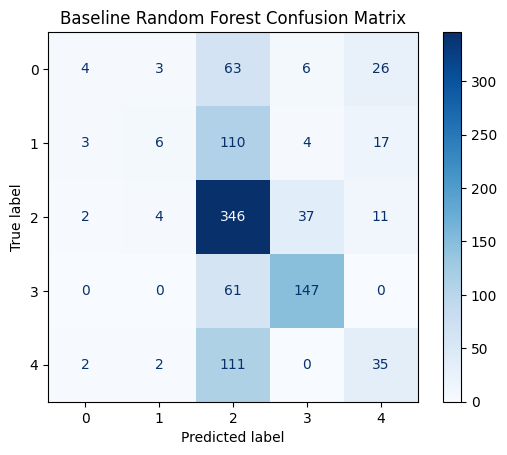

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_baseline.classes_)
disp.plot(cmap='Blues')
plt.title("Baseline Random Forest Confusion Matrix")
plt.show()


**2.2.2.2.Hyperparameter Tunning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

print("\n========== HYPERPARAMETER TUNING (RANDOMIZED SEARCH) ==========")

# parameter distributions
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['sqrt', 'log2', 0.5, 0.7]
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Starting randomized search...")
random_search.fit(X_train, y_train)

# Get best parameters and model
best_params = random_search.best_params_
best_rf = random_search.best_estimator_

print("\nBest Hyperparameters:")
print(best_params)

# Evaluate tuned model
y_val_pred_tuned = best_rf.predict(X_val)
print("\nTuned Model Performance:")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_tuned):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_tuned))


========== HYPERPARAMETER TUNING (RANDOMIZED SEARCH) ==========
Starting randomized search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best Hyperparameters:
{'n_estimators': 250, 'min_samples_split': np.int64(6), 'min_samples_leaf': np.int64(3), 'max_features': 0.5, 'max_depth': None}

Tuned Model Performance:
Validation Accuracy: 0.5470

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.08      0.13       102
           1       0.43      0.09      0.15       140
           2       0.53      0.75      0.62       400
           3       0.71      0.85      0.77       208
           4       0.39      0.33      0.36       150

    accuracy                           0.55      1000
   macro avg       0.48      0.42      0.41      1000
weighted avg       0.51      0.55      0.50      1000



## 4.3. ANN

### **Feature extraction**



- **Input/Output**  
  - Takes raw EEG (`X_raw`, samples×timepoints) and sampling rate (`fs`, default 128 Hz).  
  - Returns an array of engineered features (samples×~20 features).

- **Corruption Handling**  
  - Detects flat or NaN-filled samples and returns zeros fallback.

- **Time-Domain Stats**  
  - Mean, standard deviation, skewness, kurtosis, RMS, zero-crossing rate.

- **Nonlinear Descriptors**  
  - Shannon entropy (histogram-based).  
  - Petrosian fractal dimension.  
  - Hjorth parameters: activity, mobility, complexity.

- **Envelope Features**  
  - Mean and SD of the Hilbert transform envelope.

- **Frequency-Domain Features**  
  - Welch PSD normalized for stability.  
  - Relative band-power in Δ (1–4 Hz), θ (4–8 Hz), α (8–13 Hz), β (13–30 Hz), γ (30–50 Hz).

- **FFT Descriptors**  
  - Mean and standard deviation of half-spectrum amplitudes.


In [ ]:

import numpy as np
from scipy.stats import skew, kurtosis, entropy as scipy_entropy
from scipy.signal import welch, hilbert
from scipy.fft import fft

def extract_eeg_features(X_raw, fs=128):
    """
    Enhanced EEG feature engineering combining time, frequency, and nonlinear descriptors.

    Parameters:
    - X_raw: numpy array of raw EEG signals (samples x timepoints)
    - fs: Sampling rate in Hz (default=128)

    Returns:
    - features: numpy array of shape (samples x engineered_features)
    """
    def rms(x): return np.sqrt(np.mean(x**2))

    def zero_crossing_rate(x):
        return np.mean(x[:-1] * x[1:] < 0)

    def hjorth_parameters(x):
        dx = np.diff(x)
        ddx = np.diff(dx)
        var_x = np.var(x)
        var_dx = np.var(dx)
        var_ddx = np.var(ddx)
        activity = var_x
        mobility = np.sqrt(var_dx / var_x) if var_x != 0 else 0
        complexity = np.sqrt(var_ddx / var_dx) / mobility if var_dx != 0 and mobility != 0 else 0
        return activity, mobility, complexity

    def shannon_entropy(x, bins=32):
        hist, _ = np.histogram(x, bins=bins, density=True)
        hist = hist[hist > 0]
        return scipy_entropy(hist, base=2)

    def fractal_dimension(signal):
        """Petrosian Fractal Dimension (PFD)"""
        N = len(signal)
        diff = np.diff(signal)
        N_delta = np.sum(diff[1:] * diff[:-1] < 0)
        return np.log(N) / (np.log(N) + np.log(N / (N + 0.4 * N_delta))) if N_delta != 0 else 0

    engineered_features = []

    for sample in X_raw:
        feats = []

        # Basic checks
        if np.all(sample == sample[0]) or np.any(np.isnan(sample)):
            feats = [0.0] * 20  # Fallback for corrupted samples
            engineered_features.append(feats)
            continue

        # Time-domain features
        feats.append(np.mean(sample))
        feats.append(np.std(sample))
        feats.append(skew(sample))
        feats.append(kurtosis(sample))
        feats.append(rms(sample))
        feats.append(zero_crossing_rate(sample))
        feats.append(shannon_entropy(sample))
        feats.append(fractal_dimension(sample))

        # Hjorth parameters
        feats.extend(hjorth_parameters(sample))

        # Hilbert envelope
        envelope = np.abs(hilbert(sample))
        feats.append(np.mean(envelope))
        feats.append(np.std(envelope))

        # PSD (Welch)
        freqs, psd = welch(sample, fs=fs, nperseg=min(256, len(sample)))
        psd_norm = psd / (np.sum(psd) + 1e-8)  # Normalized PSD with stability

        # Relative band powers
        def bandpower(freq_low, freq_high):
            return np.sum(psd_norm[(freqs >= freq_low) & (freqs < freq_high)])

        feats += [
            bandpower(1, 4),    # Delta
            bandpower(4, 8),    # Theta
            bandpower(8, 13),   # Alpha
            bandpower(13, 30),  # Beta
            bandpower(30, 50)   # Gamma
        ]

        # FFT-based descriptors
        fft_vals = np.abs(fft(sample))[:len(sample)//2]
        feats.append(np.mean(fft_vals))
        feats.append(np.std(fft_vals))

        engineered_features.append(feats)

    return np.array(engineered_features)



### **First trial without hyperparameter tuning**

**EEG Classification – Core Steps Overview**

- Performed custom EEG feature extraction to enhance raw input data.
- One-hot encoded target labels to prepare for multi-class classification.
- Standardized features to ensure consistent input scaling.
- Built a neural network with two hidden layers for classification.
- Trained the model on processed EEG data and evaluated its accuracy.


In [ ]:



# Separate raw features and target
X_raw = clean_df.drop(columns=['target']).values  # All columns except 'target'
y = clean_df['target'].values                     # Explicitly use the 'target' column


# Apply EEG feature engineering
X = extract_eeg_features(X_raw)

# One-hot encode the target labels
y_encoded = to_categorical(y, num_classes=5)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the ANN model (unchanged)
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))  # 5 output classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4059 - loss: 1.4030 - val_accuracy: 0.5750 - val_loss: 1.0360
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6046 - loss: 1.0118 - val_accuracy: 0.6150 - val_loss: 0.9496
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6268 - loss: 0.9434 - val_accuracy: 0.6275 - val_loss: 0.9120
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6379 - loss: 0.9040 - val_accuracy: 0.6525 - val_loss: 0.8842
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6479 - loss: 0.8753 - val_accuracy: 0.6625 - val_loss: 0.8634
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6543 - loss: 0.8540 - val_accuracy: 0.6825 - val_loss: 0.8464
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6600 - loss: 0.8368 - val_accuracy: 0.6825 - val_loss: 0.8323
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6647 - loss: 0.8228 - val_accuracy: 0.

In [ ]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate and print the classification report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.6842    0.7027    0.6933       111
           1     0.6814    0.5238    0.5923       147
           2     0.6568    0.6838    0.6700       389
           3     0.7188    0.7931    0.7541       203
           4     0.6111    0.5867    0.5986       150

    accuracy                         0.6700      1000
   macro avg     0.6705    0.6580    0.6617      1000
weighted avg     0.6692    0.6700    0.6675      1000



The **macro F1-score of 66.17%** reflects a balanced performance across all classes, which is crucial given the class imbalance. While some classes (e.g., class 1) show weaker recall, the model still generalizes moderately well overall. This is a decent starting point, but improvements can be expected with tuning and better


### **Second Trial using cross-validation and imbalance handling**





- Replaced simple train/test split with **Stratified K-Fold Cross-Validation** to better evaluate model performance across all classes.
- Introduced **class weighting** to handle class imbalance during training.
- Defined a reusable `build_model` function to initialize and compile the ANN.
- Collected accuracy and macro F1-score for each fold to compute reliable average metrics.


In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential


# Fix randomness for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# One-hot encoding
y_cat = to_categorical(y, num_classes=5)

# ----- Class Weighting -----
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# ----- Model Builder -----
def build_model(input_dim, num_classes=5):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ----- Cross-Validation -----
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
scores = []

for train_index, test_index in skf.split(X, y):
    print(f"\n--- Fold {fold} ---")

    X_train, X_test = X[train_index], X[test_index]
    y_train_cat, y_test_cat = y_cat[train_index], y_cat[test_index]
    y_test_true = y[test_index]

    # Build and train model
    model = build_model(input_dim=X.shape[1])
    model.fit(X_train, y_train_cat, epochs=30, batch_size=32,
              validation_split=0.1, verbose=0, class_weight=class_weights_dict)

    # Evaluation
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    report = classification_report(y_test_true, y_pred, output_dict=True)
    acc = report['accuracy']
    f1_macro = report['macro avg']['f1-score']
    scores.append((acc, f1_macro))

    print(classification_report(y_test_true, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test_true, y_pred))

    fold += 1

# ----- Final Results -----
avg_acc = np.mean([s[0] for s in scores])
avg_f1 = np.mean([s[1] for s in scores])
print(f"\nAverage Accuracy: {avg_acc:.4f}")
print(f"Average Macro F1-Score: {avg_f1:.4f}")



--- Fold 1 ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0     0.4425    0.7476    0.5560       103
           1     0.2574    0.5036    0.3406       139
           2     0.7600    0.4275    0.5472       400
           3     0.6859    0.9135    0.7835       208
           4     0.4808    0.1667    0.2475       150

    accuracy                         0.5330      1000
   macro avg     0.5253    0.5518    0.4950      1000
weighted avg     0.6001    0.5330    0.5236      1000

Confusion Matrix:
 [[ 77  17   4   4   1]
 [ 30  70  23  10   6]
 [ 43  94 171  72  20]
 [  5   0  13 190   0]
 [ 19  91  14   1  25]]

--- Fold 2 ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0     0.4695    0.7549    0.5789       102
           1     0.2334    0.5286    0.3239       140
           2     0.6995    0.3725    0.4861       400
           3     0.6914    0.8510    0.7629      



---
Results found are below average in terms of performance **(49.13% Avg Macro F1-Score)**, they must be improved by hyperparameter tuning and imbalance handling.

### **Third Trial with hyperparameters tuning with cross-validation and imbalance handling**


Starting manual random search based on macro F1-score...

Trying combination 1/10: {'batch_size': 64, 'dropout_rate': np.float64(0.49827149343011645), 'learning_rate': np.float64(0.001934347898661638), 'units1': 103, 'units2': 76}
  Fold 1/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Fold 2/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Fold 3/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Mean CV Macro F1: 0.6504 (±0.0044)

Trying combination 2/10: {'batch_size': 16, 'dropout_rate': np.float64(0.17800932022121826), 'learning_rate': np.float64(0.0016599452033620266), 'units1': 106, 'units2': 90}
  Fold 1/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  Fold 2/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Fold 3/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Mean CV Macro F1: 0.

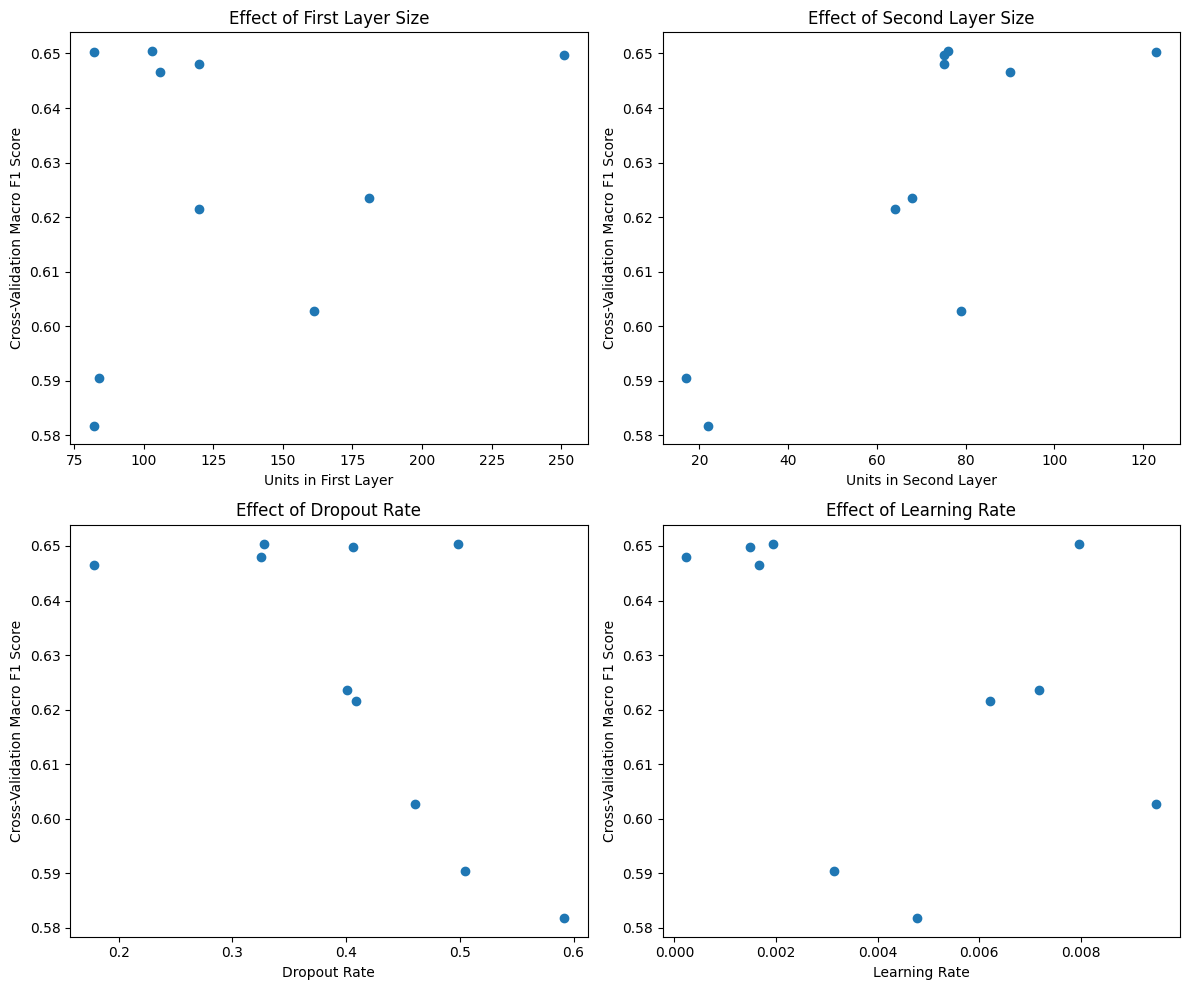

In [ ]:
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import randint, uniform
import numpy as np
import time
from tensorflow.keras.optimizers import Adam

# Start timing
start_time = time.time()

# Prepare data
X_raw = clean_df.drop(columns=['target']).values
y = clean_df['target'].values
X = extract_eeg_features(X_raw)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Create validation set for early stopping
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=0
)

# Improved model function with dropout for regularization
def build_model(units1, units2, dropout_rate, learning_rate):
    model = Sequential([
        Dense(units1, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(units2, activation='relu'),
        Dropout(dropout_rate),
        Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define parameter space
param_distributions = {
    'units1': randint(32, 256),
    'units2': randint(16, 128),
    'dropout_rate': uniform(0.1, 0.5),
    'learning_rate': uniform(0.0001, 0.01),
    'batch_size': [16, 32, 64],
}

# Number of random combinations to try
n_iter = 10

# Implementation of manual random search
print("Starting manual random search based on macro F1-score...")
cv_results = {
    'params': [],
    'mean_f1_score': [],
    'std_f1_score': [],
    'mean_train_f1': [],
    'std_train_f1': [],
}

# Generate random parameter combinations
np.random.seed(42)  # For reproducibility
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=42))

for i, params in enumerate(param_list):
    print(f"\nTrying combination {i+1}/{n_iter}: {params}")

    # Unpack parameters
    units1 = params['units1']
    units2 = params['units2']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']

    # Track scores for cross-validation
    cv_train_f1_scores = []
    cv_val_f1_scores = []

    # Simple k-fold validation (k=3)
    k = 3
    fold_size = len(X_train) // k
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)

    for fold in range(k):
        print(f"  Fold {fold+1}/{k}")
        # Split data for this fold
        val_indices = indices[fold * fold_size:(fold + 1) * fold_size]
        train_indices = np.setdiff1d(indices, val_indices)

        X_train_fold = X_train[train_indices]
        y_train_fold = y_train[train_indices]
        X_val_fold = X_train[val_indices]
        y_val_fold = y_train[val_indices]

        # Build and train model
        model = build_model(units1, units2, dropout_rate, learning_rate)

        history = model.fit(
            X_train_fold, y_train_fold,
            epochs=100,  # High value, early stopping will handle it
            batch_size=batch_size,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stopping],
            verbose=0
        )

        # Get predictions
        y_train_pred = np.argmax(model.predict(X_train_fold), axis=1)
        y_val_pred = np.argmax(model.predict(X_val_fold), axis=1)

        # Calculate F1 scores (macro average)
        train_f1 = f1_score(y_train_fold, y_train_pred, average='macro')
        val_f1 = f1_score(y_val_fold, y_val_pred, average='macro')

        cv_train_f1_scores.append(train_f1)
        cv_val_f1_scores.append(val_f1)

    # Calculate mean and std of scores
    mean_train_f1 = np.mean(cv_train_f1_scores)
    std_train_f1 = np.std(cv_train_f1_scores)
    mean_val_f1 = np.mean(cv_val_f1_scores)
    std_val_f1 = np.std(cv_val_f1_scores)

    # Save results
    cv_results['params'].append(params)
    cv_results['mean_train_f1'].append(mean_train_f1)
    cv_results['std_train_f1'].append(std_train_f1)
    cv_results['mean_f1_score'].append(mean_val_f1)
    cv_results['std_f1_score'].append(std_val_f1)

    print(f"  Mean CV Macro F1: {mean_val_f1:.4f} (±{std_val_f1:.4f})")

# Find best parameters based on F1 score
best_idx = np.argmax(cv_results['mean_f1_score'])
best_params = cv_results['params'][best_idx]
best_score = cv_results['mean_f1_score'][best_idx]

print(f"\nBest parameters: {best_params}")
print(f"Best cross-validation Macro F1 score: {best_score:.4f}")

# Train final model with best parameters
print("\nTraining final model with best parameters...")
final_model = build_model(
    best_params['units1'],
    best_params['units2'],
    best_params['dropout_rate'],
    best_params['learning_rate']
)

final_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=best_params['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=0
)

# Evaluate final model
y_pred = np.argmax(final_model.predict(X_test), axis=1)

print("\nClassification Report on Test Set:")
report = classification_report(y_test, y_pred, digits=4)
print(report)

# Extract macro avg f1-score from report
lines = report.split('\n')
macro_line = [line for line in lines if 'macro avg' in line][0]
macro_f1 = float(macro_line.split()[-2])
print(f"\nTest Set Macro F1 Score: {macro_f1:.4f}")

# Print execution time
elapsed_time = time.time() - start_time
print(f"\nTotal execution time: {elapsed_time:.2f} seconds")

# Plot some results
import matplotlib.pyplot as plt

# Extract parameters for plotting
units1_values = [p['units1'] for p in cv_results['params']]
units2_values = [p['units2'] for p in cv_results['params']]
dropout_values = [p['dropout_rate'] for p in cv_results['params']]
lr_values = [p['learning_rate'] for p in cv_results['params']]
f1_scores = cv_results['mean_f1_score']

# Plot relationship between hyperparameters and F1 score
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(units1_values, f1_scores)
plt.xlabel('Units in First Layer')
plt.ylabel('Cross-Validation Macro F1 Score')
plt.title('Effect of First Layer Size')

plt.subplot(2, 2, 2)
plt.scatter(units2_values, f1_scores)
plt.xlabel('Units in Second Layer')
plt.ylabel('Cross-Validation Macro F1 Score')
plt.title('Effect of Second Layer Size')

plt.subplot(2, 2, 3)
plt.scatter(dropout_values, f1_scores)
plt.xlabel('Dropout Rate')
plt.ylabel('Cross-Validation Macro F1 Score')
plt.title('Effect of Dropout Rate')

plt.subplot(2, 2, 4)
plt.scatter(lr_values, f1_scores)
plt.xlabel('Learning Rate')
plt.ylabel('Cross-Validation Macro F1 Score')
plt.title('Effect of Learning Rate')

plt.tight_layout()
plt.show()

According to our results, the best parameters are:

>{

  `'batch_size'`: 64,

  `'dropout_rate'`: (0.49827149343011645)

  `'learning_rate'`: (0.001934347898661638),

 ` 'units1'`: 103,

  `'units2'`: 76

>}

performance by **Macro Avg F1-Score** (65.46%) is quite decent after hyperparameters tuning. Now, we need to focus on class imbalance.

---



In [ ]:

# Prepare data
X_raw = clean_df.drop(columns=['target']).values
y = clean_df['target'].values
X = extract_eeg_features(X_raw)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Improved model function with dropout for regularization
def build_model(units1, units2, dropout_rate, learning_rate):
    model = Sequential([
        Dense(units1, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(units2, activation='relu'),
        Dropout(dropout_rate),
        Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=0
)

### **Fourth Trial with best parameter and class imbalance handling**


- This section uses different resampling techniques such as **`SMOTE`** and **RandomSampler**, as well as using the **`Classes Weights`** to handle **class imbalance**.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict
import numpy as np

# Define the sampling techniques
sampling_strategies = {
    'None': None,
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'TomekLinks': TomekLinks(),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# Best hyperparameters you found earlier
best_params = {
    'units1': 103,
    'units2': 76,
    'dropout_rate': 0.49827149343011645,
    'learning_rate': 0.001934347898661638,
    'batch_size': 64
}

# Storage for results
results = defaultdict(list)

# Cross-validation setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("\nStarting sampling strategy grid search...")
for name, sampler in sampling_strategies.items():
    print(f"\nTrying sampling method: {name}")
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"  Fold {fold+1}/3")
        X_tr, y_tr = X_train[train_idx], y_train[train_idx]
        X_val, y_val = X_train[val_idx], y_train[val_idx]

        # Apply sampling if needed
        if sampler is not None:
            X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

        # Compute class weights
        classes = np.unique(y_tr)
        class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
        class_weight_dict = dict(zip(classes, class_weights_array))

        # Build model
        model = build_model(
            best_params['units1'],
            best_params['units2'],
            best_params['dropout_rate'],
            best_params['learning_rate']
        )

        model.fit(
            X_tr, y_tr,
            epochs=100,
            batch_size=best_params['batch_size'],
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            class_weight=class_weight_dict,
            verbose=0
        )

        y_val_pred = np.argmax(model.predict(X_val), axis=1)
        f1 = f1_score(y_val, y_val_pred, average='macro')
        fold_scores.append(f1)

    mean_f1 = np.mean(fold_scores)
    std_f1 = np.std(fold_scores)
    results['sampler'].append(name)
    results['mean_f1'].append(mean_f1)
    results['std_f1'].append(std_f1)

    print(f"  Mean Macro F1-score: {mean_f1:.4f} ± {std_f1:.4f}")

# Find best sampler
best_idx = np.argmax(results['mean_f1'])
print(f"\n✅ Best sampling method: {results['sampler'][best_idx]}")
print(f"Macro F1-score: {results['mean_f1'][best_idx]:.4f} ± {results['std_f1'][best_idx]:.4f}")


Starting sampling strategy grid search...

Trying sampling method: None
  Fold 1/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Fold 2/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Fold 3/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Mean Macro F1-score: 0.5372 ± 0.0162

Trying sampling method: RandomOverSampler
  Fold 1/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Fold 2/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Fold 3/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Mean Macro F1-score: 0.5609 ± 0.0196

Trying sampling method: SMOTE
  Fold 1/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Fold 2/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Fold 3/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
  Mean Macro F1-score: 0.5513 ± 0.0133

Trying sampling method: ADASYN
  Fold 1/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Fold 2/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Fold 3/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
  Mean Macro F1-score: 0.5302 ± 0.0144

Trying sampling method: RandomUnderSampler
  Fold 1/3
42/42 ━━━

## 4.4. SVM

### **First Trial without hyperparameters tuning, no cross-validation and no imbalance handling**


- We extracted features using the **`extract_eeg_features`** function we defined earlier.
- We standardized them since SVM is sensetive to scale then trained our SVM model.

In [ ]:

from sklearn.svm import SVC

# Separate raw features and target
X_raw = clean_df.drop(columns=['target']).values
y = clean_df['target'].values  # Integer-encoded labels like 0,1,2,3,4

# Apply EEG feature engineering
X = extract_eeg_features(X_raw)

# Step 1: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Train SVM with RBF kernel
model = SVC(kernel='rbf', gamma=0.0162, random_state=42)
model.fit(X_train, y_train)

# Step 4: Evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Wake", "E1", "E2", "E3", "REM"]))


[[ 58  11  22   3   8]
 [ 19  37  70   4  10]
 [ 11  11 293  49  36]
 [  1   0  43 164   0]
 [  6   3  53   0  88]]
              precision    recall  f1-score   support

        Wake       0.61      0.57      0.59       102
          E1       0.60      0.26      0.37       140
          E2       0.61      0.73      0.67       400
          E3       0.75      0.79      0.77       208
         REM       0.62      0.59      0.60       150

    accuracy                           0.64      1000
   macro avg       0.64      0.59      0.60      1000
weighted avg       0.64      0.64      0.63      1000



**Macro F1-score** is moderate (0.60), hurt by poor E1 performance. Class imbalance and no tuning limit the model. We try balancing or tuning for better results.




---



### **second Trial with tuning resampling techniques and use of cross-validation**


* Built a pipeline: `scaling` + `sampling` + `SVM`.
* Defined a grid of **sampling techniques** to handle class imbalance.
* Used **GridSearchCV with 5-fold CV** to reliably select the best sampler based on **macro F1-score**, avoid overfitting and helps more generalization.


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Separate raw features and target
X_raw = clean_df.drop(columns=['target']).values
y = clean_df['target'].values

# Apply EEG feature engineering
X = extract_eeg_features(X_raw)

# Step 1: Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', SMOTE()),  # placeholder; grid search will change this
    ('svm', SVC(kernel='rbf', gamma=0.0162, random_state=42))
])

# Step 3: Define the parameter grid with different samplers
param_grid = {
    'sampler': [
        SMOTE(random_state=42),
        ADASYN(random_state=42),
        RandomOverSampler(random_state=42),
        RandomUnderSampler(random_state=42)
    ]
}

# Step 4: Define scoring metric
scorer = make_scorer(f1_score, average='macro')

# Step 5: Grid Search
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Step 6: Best model evaluation
print("\n✅ Best sampler technique based on macro F1-score:", type(grid_search.best_params_['sampler']).__name__)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, target_names=["Wake", "E1", "E2", "E3", "REM"]))


Fitting 5 folds for each of 4 candidates, totalling 20 fits

✅ Best sampler technique based on macro F1-score: SMOTE

📊 Confusion Matrix:
 [[ 69  18   5   3   7]
 [ 27  79  16   6  12]
 [ 21  54 169  79  77]
 [  1   0  26 180   1]
 [  8  11  17   0 114]]

📋 Classification Report:
               precision    recall  f1-score   support

        Wake       0.55      0.68      0.61       102
          E1       0.49      0.56      0.52       140
          E2       0.73      0.42      0.53       400
          E3       0.67      0.87      0.76       208
         REM       0.54      0.76      0.63       150

    accuracy                           0.61      1000
   macro avg       0.59      0.66      0.61      1000
weighted avg       0.64      0.61      0.60      1000



SMOTE improved class balance, but accuracy is still moderate (61%). **E2** struggles with recall (0.42), while **E3** performs well. Macro avg F1-score (0.61) shows room for improvement, especially for **E1** and **Wake**. Further tuning or sampling strategies could boost performance.




---



### **Third Trial with tuning resampling techniques and other parameters and use of cross-validation**


Here, we added **hyperparameter tuning** to both the **sampling technique** and **SVM model**:

* Defined a grid for **sampling methods** (SMOTE, ADASYN, RandomOverSampler, RandomUnderSampler).
* Tuned key **SVM parameters**: `kernel`, `C`, `class_weight`, and `gamma` to improve performance.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Separate raw features and target
X_raw = clean_df.drop(columns=['target']).values
y = clean_df['target'].values

# Apply EEG feature engineering
X = extract_eeg_features(X_raw)

# Step 1: Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', SMOTE()),  # placeholder; grid search will change this
    ('svm', SVC(random_state=42))
])

# Step 3: Define the parameter grid
param_grid = {
    'sampler': [
        SMOTE(random_state=42),
        ADASYN(random_state=42),
        RandomOverSampler(random_state=42),
        RandomUnderSampler(random_state=42)
    ],
    'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'svm__C': [0.1, 1, 10],
    'svm__class_weight': [None, 'balanced'],
    'svm__gamma': ['scale', 'auto']  # only relevant for rbf/poly/sigmoid
}

# Step 4: Define scoring metric
scorer = make_scorer(f1_score, average='macro')

# Step 5: Grid Search
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Step 6: Best model evaluation
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print results
print("\n✅ Best Parameter Combination:")
for param, value in best_params.items():
    print(f" - {param}: {value}")

print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(
    y_test, y_pred, target_names=["Wake", "E1", "E2", "E3", "REM"]))


Fitting 5 folds for each of 192 candidates, totalling 960 fits

✅ Best Parameter Combination:
 - sampler: SMOTE(random_state=42)
 - svm__C: 1
 - svm__class_weight: None
 - svm__gamma: auto
 - svm__kernel: rbf

📊 Confusion Matrix:
 [[ 69  18   6   3   6]
 [ 27  76  24   5   8]
 [ 27  45 190  69  69]
 [  1   0  23 183   1]
 [ 10  10  21   0 109]]

📋 Classification Report:
               precision    recall  f1-score   support

        Wake       0.51      0.68      0.58       102
          E1       0.51      0.54      0.53       140
          E2       0.72      0.47      0.57       400
          E3       0.70      0.88      0.78       208
         REM       0.56      0.73      0.64       150

    accuracy                           0.63      1000
   macro avg       0.60      0.66      0.62      1000
weighted avg       0.64      0.63      0.62      1000



* **Best Parameters**: SMOTE, SVM with `C=1`, `rbf` kernel, `gamma='auto'`, `class_weight=None`.
* **Confusion Matrix**: Strong performance on **E3** (high recall 0.88), weaker on **E2** (low recall 0.47).
* **Classification Report**: Accuracy of 63%, **E3** performs best, **E2** struggles with low recall and f1-score.

Overall, the model does well with **E3** but needs improvement for **E2**.




---



### **Fourth Trial with tuning to gamma for rbf kernel**


In [ ]:

# Separate raw features and target
X_raw = clean_df.drop(columns=['target']).values
y = clean_df['target'].values

# Apply EEG feature engineering
X = extract_eeg_features(X_raw)

# Step 1: Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Define the pipeline with SMOTE and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', SMOTE(random_state=42)),
    ('svm', SVC(random_state=42))
])

# Step 3: Define the parameter grid with tuning for gamma
param_grid = {
    'svm__kernel': ['rbf'],
    'svm__C': [1],
    'svm__class_weight': [None],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]  # Tuning gamma for rbf kernel
}

# Step 4: Define scoring metric
scorer = make_scorer(f1_score, average='macro')

# Step 5: Grid Search with Stratified K-Folds cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Step 6: Best model evaluation
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print results
print("\n✅ Best Parameter Combination:")
for param, value in best_params.items():
    print(f" - {param}: {value}")

print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(
    y_test, y_pred, target_names=["Wake", "E1", "E2", "E3", "REM"]))


Fitting 5 folds for each of 6 candidates, totalling 30 fits

✅ Best Parameter Combination:
 - svm__C: 1
 - svm__class_weight: None
 - svm__gamma: 0.1
 - svm__kernel: rbf

📊 Confusion Matrix:
 [[ 67  14  12   2   7]
 [ 23  78  28   3   8]
 [ 26  46 198  68  62]
 [  0   0  24 183   1]
 [  9  10  22   0 109]]

📋 Classification Report:
               precision    recall  f1-score   support

        Wake       0.54      0.66      0.59       102
          E1       0.53      0.56      0.54       140
          E2       0.70      0.49      0.58       400
          E3       0.71      0.88      0.79       208
         REM       0.58      0.73      0.65       150

    accuracy                           0.64      1000
   macro avg       0.61      0.66      0.63      1000
weighted avg       0.64      0.64      0.63      1000



* **Best Parameter Gamma**: `gamma=0.1`
* **Performance**: The model achieved an accuracy of **64%**.
* **Class-wise Performance**:

  * **E3** had the best performance with an F1-score of **0.79** (high recall of **0.88**).
  * **E2** performed the worst with an F1-score of **0.58**.
* **Overall**: The model performs decently but can be further improved, especially for **E2** and **E1**.




---



### **Finally, check for overfitting**

In [ ]:
import matplotlib.pyplot as plt

# Get the training and testing accuracy
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

# Plot the comparison
plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Training and Testing Accuracy')
plt.show()


##4.5. MLP

The code cell below t trains a Temporal Convolutional Network (TCN) to classify EEG time-series data. It includes preprocessing, reshaping, model building, training, and evaluation steps.

In [ ]:
!pip install keras-tcn --quiet

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# === STEP 1: SPLIT FIRST ===
def split_data(df, target_column, test_size=0.2, val_size=0.2, random_state=42):
    y = df[target_column]
    X = df.drop(columns=[target_column])

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# === STEP 2: PREPROCESS AFTER SPLITTING ===
def preprocess_split_set(X_train, X_val, X_test):
    report = []

    fill_values = X_train.median()
    X_train = X_train.fillna(fill_values)
    X_val = X_val.fillna(fill_values)
    X_test = X_test.fillna(fill_values)

    constant_cols = [col for col in X_train.columns if X_train[col].nunique() == 1]
    if constant_cols:
        report.append(f"Removed constant columns: {constant_cols}")
        X_train.drop(columns=constant_cols, inplace=True)
        X_val.drop(columns=constant_cols, inplace=True)
        X_test.drop(columns=constant_cols, inplace=True)
    else:
        report.append("No constant columns found.")

    skewness = X_train.apply(lambda x: skew(x.dropna()))
    skewed_features = skewness[abs(skewness) > 1].index.tolist()
    normal_features = skewness[abs(skewness) <= 1].index.tolist()
    report.append(f"Skewed features: {skewed_features}")
    report.append(f"Approximately normal features: {normal_features}")

    outlier_cols = []
    for col in X_train.columns:
        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((X_train[col] < (Q1 - 1.5 * IQR)) | (X_train[col] > (Q3 + 1.5 * IQR))).sum()
        if outliers > 0:
            outlier_cols.append(col)
    report.append(f"Features with outliers: {outlier_cols}")

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train_scaled, X_val_scaled, X_test_scaled, report

# === TCN MODEL TRAINING ===
def build_tcn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model



# 1. Split
X_train, X_val, X_test, y_train, y_val, y_test = split_data(initial_dataset, target_column="target")

# 2. Preprocess
X_train_scaled, X_val_scaled, X_test_scaled, summary = preprocess_split_set(X_train, X_val, X_test)

# 3. Reshape
X_train_tcn = X_train_scaled.values.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_tcn = X_val_scaled.values.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_tcn = X_test_scaled.values.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# 4. One-hot encode labels
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# 5. Build and train model
model = build_tcn_model(input_shape=X_train_tcn.shape[1:], num_classes=num_classes)
history = model.fit(X_train_tcn, y_train_cat, validation_data=(X_val_tcn, y_val_cat), epochs=20, batch_size=32, verbose=0)

# 6. Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_tcn, y_test_cat, verbose=0)

# Print results
print(f"Test Accuracy: {test_acc:.4f}")
print("Preprocessing summary (first 3 lines):")
for line in summary[:3]:
    print(line)

Test Accuracy: 0.4962
Preprocessing summary (first 3 lines):
No constant columns found.
Skewed features: []
Approximately normal features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178]


Final accuracy on the test set is around 49.6%, indicating that the model captures some patterns  
but there's room for improvement through tuning or a more complex architecture.

## 4.6.CNN + LSTM

### 4.6.1.Data Preprocessing:

In [ ]:
# Load training and testing data
train_data = pd.read_csv('Sleep Train 5000.csv', header=None)
test_data = pd.read_csv('Sleep Test 1000.csv', header=None)

# Separate features (X) and labels (y)
X = train_data.iloc[:, 1:]
y = train_data.iloc[:, 0]

In [ ]:
# Check for missing values
print("Missing Values in Training Data:")
print(X.isnull().sum().sum())

# Remove constant features (if any)
constant_features = [col for col in X.columns if X[col].nunique() == 1]
if constant_features:
    X = X.drop(columns=constant_features)
    print(f"\nRemoved {len(constant_features)} constant features.")

# Detect and handle outliers (using Z-score)
from scipy import stats
z_scores = np.abs(stats.zscore(X))
outliers = (z_scores > 3).any(axis=1)
X = X[~outliers]
y = y[~outliers]
print(f"\nRemoved {sum(outliers)} outliers.")

Missing Values in Training Data:
0

Removed 1278 outliers.


In [ ]:
# Split into training and validation:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTraining Set Shape:", X_train.shape)
print("Validation Set Shape:", X_val.shape)


Training Set Shape: (2976, 178)
Validation Set Shape: (745, 178)


In [ ]:
# Standardize features:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape for CNN input:
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)

In [ ]:
# Convert labels to numerical values
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# One-hot encode for CNN-LSTM
num_classes = len(np.unique(y_train_encoded))
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)

### 4.6.2.Modeling:

preparing data for modeling:

In [ ]:
# Continue from your preprocessing
from sklearn.model_selection import train_test_split

# Separate features and target
X = clean_df.drop(columns=['target']).values
y = clean_df['target'].values

# Reshape X for CNN-LSTM input (samples, timesteps, features)
# Since we have 178 features (time points), we'll treat this as (samples, 178, 1)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels to one-hot
y = to_categorical(y)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (3999, 178, 1)
Validation data shape: (1000, 178, 1)


**Initial model training**

In [ ]:
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        # CNN layers for feature extraction
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # LSTM layers for temporal processing
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),

        Bidirectional(LSTM(32)),
        Dropout(0.3),

        # Dense layers for classification
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Calculate class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)),
                                        y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

# Model parameters
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

# Create model
model = create_cnn_lstm_model(input_shape, num_classes)

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 176, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 176, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 86, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 86, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 43, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,245 (665.02 KB)

 Trainable params: 169,861 (663.52 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 147ms/step - accuracy: 0.3668 - loss: 1.3865 - val_accuracy: 0.1580 - val_loss: 1.9509 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.4963 - loss: 1.1069 - val_accuracy: 0.2170 - val_loss: 1.8888 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.5266 - loss: 1.0337 - val_accuracy: 0.3790 - val_loss: 1.4580 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.5393 - loss: 1.0038 - val_accuracy: 0.4940 - val_loss: 1.2049 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.5651 - loss: 0.9399 - val_accuracy: 0.5290 - val_loss: 1.1163 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.5776 - loss: 0.8981 - val_accuracy: 0.6120 - val_loss: 0.9186 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.6

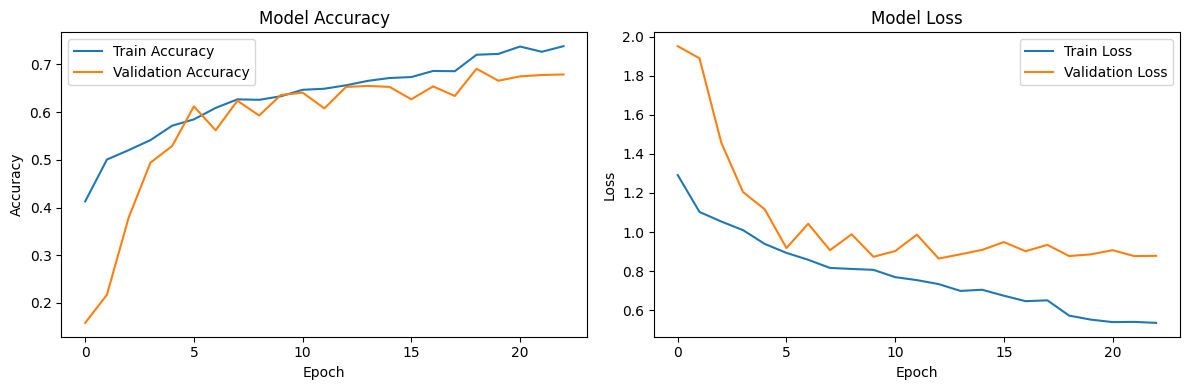

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       102
           1       0.54      0.80      0.64       140
           2       0.84      0.40      0.54       400
           3       0.70      0.89      0.78       208
           4       0.58      0.83      0.69       150

    accuracy                           0.65      1000
   macro avg       0.65      0.72      0.66      1000
weighted avg       0.70      0.65      0.64      1000


Confusion Matrix:


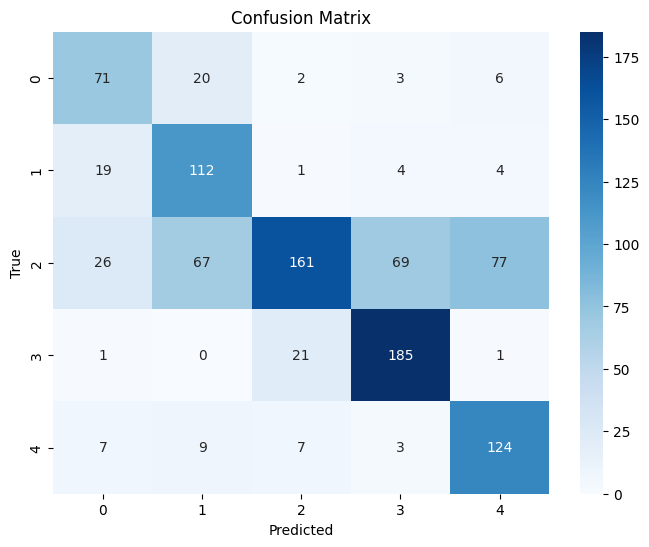

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

print("\nConfusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 4.6.3.Hyperparameter Tuning

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 577ms/step - accuracy: 0.3411 - loss: 2.6187 - val_accuracy: 0.1690 - val_loss: 2.6255 - learning_rate: 5.0000e-04
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 562ms/step - accuracy: 0.4981 - loss: 1.9931 - val_accuracy: 0.1560 - val_loss: 2.7214 - learning_rate: 5.0000e-04
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 596ms/step - accuracy: 0.5220 - loss: 1.6532 - val_accuracy: 0.1570 - val_loss: 2.4412 - learning_rate: 5.0000e-04
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 564ms/step - accuracy: 0.5668 - loss: 1.4404 - val_accuracy: 0.1630 - val_loss: 2.1931 - learning_rate: 5.0000e-04
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 568ms/step - accuracy: 0.5814 - loss: 1.2706 - val_accuracy: 0.1900 - val_loss: 2.0822 - learning_rate: 5.0000e-04
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 596ms/step - accuracy: 0.6053 - loss: 1.1477 - val_accuracy: 0.2660 - val_loss: 1.9364 - learning_rate: 5.0000e-04
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 577ms/ste

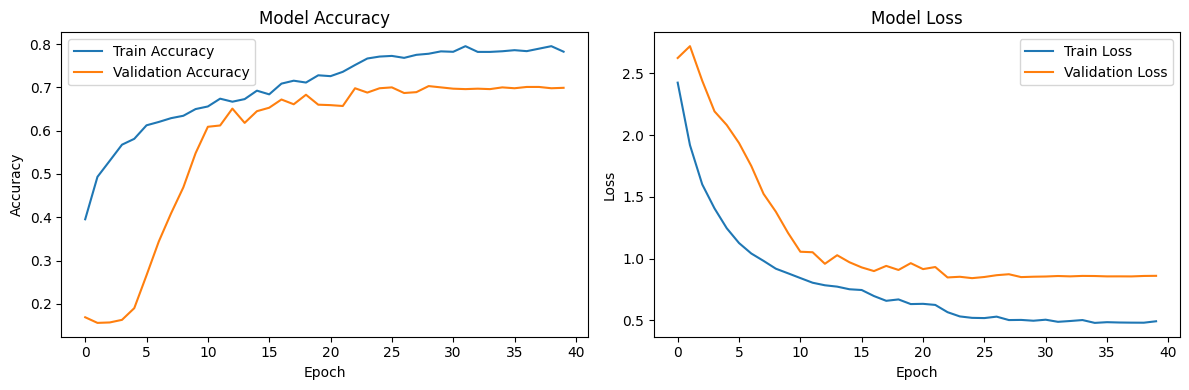

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step

Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.73      0.64       102
           1       0.64      0.77      0.70       140
           2       0.83      0.51      0.63       400
           3       0.75      0.90      0.82       208
           4       0.62      0.83      0.71       150

    accuracy                           0.70      1000
   macro avg       0.68      0.75      0.70      1000
weighted avg       0.73      0.70      0.69      1000


Tuned Model Confusion Matrix:


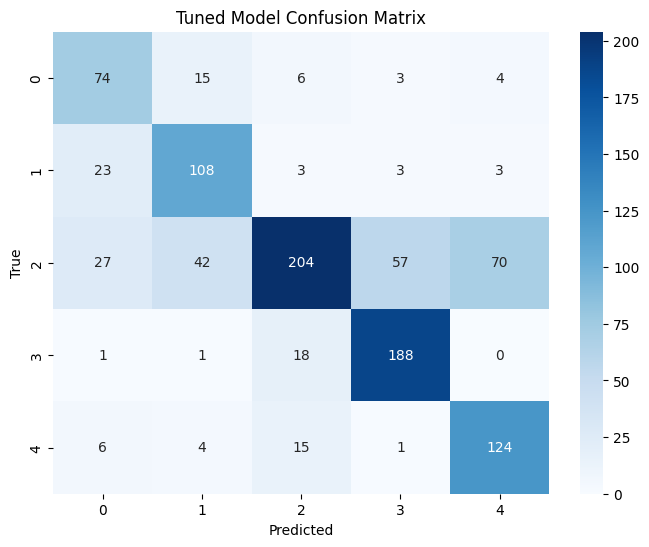

In [ ]:
def create_tuned_model(input_shape, num_classes):
    model = Sequential([
        # Enhanced CNN layers
        Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),

        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),

        # Deeper LSTM layers
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),

        Bidirectional(LSTM(64)),
        Dropout(0.3),

        # Dense layers with regularization
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile tuned model
tuned_model = create_tuned_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.0005)
tuned_model.compile(optimizer=optimizer,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# More aggressive callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

# Train the tuned model
tuned_history = tuned_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot training history
plot_training_history(tuned_history)

# Evaluate tuned model
y_pred_tuned = tuned_model.predict(X_val)
y_pred_classes_tuned = np.argmax(y_pred_tuned, axis=1)

print("\nTuned Model Classification Report:")
print(classification_report(y_true, y_pred_classes_tuned))

print("\nTuned Model Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes_tuned), annot=True, fmt='d', cmap='Blues')
plt.title('Tuned Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 4.7. CNN

in this section, we implement a convolutional neural network (CNN) training pipeline that focuses on maximizing the weighted F1 score as the primary performance metric. The weighted F1 score is especially useful in handling class imbalance by taking both precision and recall into account for each class and weighting them by support.

---

### Key Components:

- Data Preparation:
  - Labels are one-hot encoded using to_categorical.
  - Input features are reshaped to fit the 1D CNN input shape (samples, timesteps, channels).
  - Training data is split into training and validation sets to monitor performance during training.
  - Class weights are computed to balance the influence of each class in the loss function.

- Model Building:
  - A hyperparameter-tunable CNN model is defined using Keras Tuner.
  - Includes two convolutional layers with batch normalization and max pooling.
  - Dense and dropout layers for classification.
  - The model uses categorical_crossentropy loss and adam optimizer.

- Custom F1 Score Callback:
  - A Keras callback computes the weighted F1 score on the validation set at the end of each epoch.
  - Stores the best F1 score during training for tracking.

- Custom Hyperparameter Tuner:
  - Extends keras_tuner.RandomSearch to incorporate the F1 score callback.
  - Uses the weighted F1 score as the objective metric for hyperparameter optimization.

- Training and Evaluation:
  - Early stopping is applied to prevent overfitting.
  - The tuner searches over hyperparameters to maximize validation weighted F1.
  - The best model is selected based on the highest weighted F1 score.
  - Final evaluation is performed on the test set with a detailed classification report and confusion matrix.

---

### Usage Notes:

- The class_weight argument helps mitigate class imbalance by adjusting loss contributions.
- Hyperparameter tuning explores filters, kernel sizes, dense layer sizes, and dropout rates.
- The custom tuner seamlessly integrates the F1 score metric for better model selection.

---

This approach ensures the model is optimized not just for accuracy but for balanced predictive performance across all classes, improving reliability in real-world classification tasks.

# Feature Extraction and Data Preparation for EEG Classification


## Hjorth Parameters Function
Calculates three key signal characteristics:
- Activity: Variance of the signal, representing signal power.
- Mobility: The square root of the variance of the first derivative divided by the variance of the signal, representing the mean frequency.
- Complexity: Ratio of the mobility of the second derivative to the mobility of the first derivative, indicating the signal's complexity or shape.

These parameters are commonly used in EEG analysis to describe signal behavior.

---

## Entropy Functions
- Shannon Entropy: Measures the unpredictability or randomness in the signal amplitude distribution using histogram binning.
- Spectral Entropy: Measures the randomness in the signal’s power spectral density (PSD), computed via Welch’s method, indicating the disorder of the signal in the frequency domain. Optionally normalized.

Entropy metrics are useful for understanding the complexity and information content of EEG signals.

---

## Feature Extraction Function
Extracts multiple features from an EEG segment:
- Band Power Features: Logarithmic power in standard EEG frequency bands (delta, theta, alpha, beta, gamma) via Welch’s PSD estimate.
- Wavelet Features: Mean and standard deviation of discrete wavelet transform coefficients (Daubechies 4) capturing time-frequency characteristics.
- Statistical Features: Mean, standard deviation, median, interquartile range, peak-to-peak amplitude.
- Hjorth Parameters: Activity, mobility, complexity.
- Higher-Order Statistics: Skewness and kurtosis.
- Entropy Features: Spectral entropy and Shannon entropy of the segment.

Combining these features provides a rich representation of the EEG signal for classification tasks.

---

## Data Preparation and Feature Pipeline
- Label Encoding: Converts categorical target labels to numeric.
- Train-Test Split: Stratified split to preserve class distribution.
- Auto Resampling Function: Automatically balances the training set by:
  - Oversampling minority classes using ADASYN (adaptive synthetic sampling).
  - Undersampling majority classes using Tomek Links (removes borderline samples).
  This ensures better model training on imbalanced data.
  
- Safe Feature Extraction: Applies feature extraction robustly with retries, substituting zero vectors on failure to avoid crashes.

- Feature Scaling: Standardizes features to zero mean and unit variance.

- Reshaping Features: Adjusts feature arrays to 3D tensors (samples, features, channels=1) for compatibility with deep learning models like CNNs or LSTMs.

In [ ]:

 # === Imports for Feature Extraction ===
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from scipy import signal, stats
import pywt
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

# === Hjorth Parameters ===
def hjorth_parameters(x):
    first_deriv = np.diff(x)
    second_deriv = np.diff(first_deriv)
    var_zero = np.var(x)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)
    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero) if var_zero > 0 else 0
    complexity = np.sqrt(var_d2 / var_d1) / mobility if var_d1 > 0 and mobility > 0 else 0
    return activity, mobility, complexity

# === Entropy Functions ===
def shannon_entropy(x, bins=30):
    pdf, bin_edges = np.histogram(x, bins=bins, density=True)
    pdf = pdf[pdf > 0]
    return -np.sum(pdf * np.log2(pdf))

def spectral_entropy(x, sf=100, method='welch', nperseg=None, normalize=False):
    x = np.array(x)
    freqs, psd = signal.welch(x, fs=sf, nperseg=nperseg or min(256, len(x)))
    psd_norm = psd / np.sum(psd)
    entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))
    if normalize:
        entropy /= np.log2(len(psd_norm))
    return entropy

# === Feature Extraction Function ===
def extract_spectral_features(eeg_segment, sampling_rate=100):
    features = []
    segment = np.array(eeg_segment).flatten()
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 45)}

    if len(segment) > 1:
        freqs, psd = signal.welch(segment, fs=sampling_rate, nperseg=min(64, len(segment)))
        for band in bands.values():
            mask = (freqs >= band[0]) & (freqs <= band[1])
            features.append(np.log(np.sum(psd[mask]) + 1e-12) if np.any(mask) else 0.0)
    else:
        features.extend([0.0]*len(bands))

    if len(segment) >= 8:
        coeffs = pywt.wavedec(np.pad(segment, (0, 8 - len(segment) % 8), 'constant'), 'db4', level=3)
        for coeff in coeffs:
            features.extend([np.mean(coeff), np.std(coeff)])
    else:
        features.extend([0.0]*8)

    features.extend([
        np.mean(segment), np.std(segment), np.median(segment),
        np.max(segment) - np.min(segment),
        np.percentile(segment, 75) - np.percentile(segment, 25)
    ])

    activity, mobility, complexity = hjorth_parameters(segment)
    features.extend([activity, mobility, complexity])
    features.append(stats.skew(segment))
    features.append(stats.kurtosis(segment))
    features.append(spectral_entropy(segment, sf=sampling_rate))
    features.append(shannon_entropy(segment))

    return np.array(features)

# === Data Preparation and Feature Pipeline ===
le = LabelEncoder()
y_encoded = le.fit_transform(initial_dataset['target'])
X = initial_dataset.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

def auto_resample(X_train, y_train, target_multiplier=1.5, balance_ratio=0.8):
    class_counts = Counter(y_train)
    median_size = np.median(list(class_counts.values()))
    target_strategy = {cls: int(median_size * target_multiplier if count < median_size else max(median_size * balance_ratio, min(class_counts.values()))) for cls, count in class_counts.items()}

    steps = []
    if any(v > class_counts[k] for k, v in target_strategy.items()):
        steps.append(('over', ADASYN(sampling_strategy={k: v for k, v in target_strategy.items() if v > class_counts[k]}, random_state=42)))
    if any(v < class_counts[k] for k, v in target_strategy.items()):
        steps.append(('under', TomekLinks(sampling_strategy='auto')))

    pipeline = Pipeline(steps=steps)
    return pipeline.fit_resample(X_train, y_train)

X_train_res, y_train_res = auto_resample(X_train, y_train)


def safe_feature_extraction(X, max_retries=3):
    features = []
    for i, segment in enumerate(X.values if isinstance(X, pd.DataFrame) else X):
        for _ in range(max_retries):
            try:
                feat = extract_spectral_features(segment)
                break
            except Exception:
                feat = np.zeros(34)
        features.append(feat)
    return np.array(features)

X_train_features = safe_feature_extraction(X_train_res)
X_test_features = safe_feature_extraction(X_test)

scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

X_train_features = X_train_features.reshape((-1, X_train_features.shape[1], 1))
X_test_features = X_test_features.reshape((-1, X_test_features.shape[1], 1))

# CNN Model Tuning with Weighted F1 Score Optimization

in this section, we implement a convolutional neural network (CNN) training pipeline that focuses on maximizing the **weighted F1 score** as the primary performance metric. The weighted F1 score is especially useful in handling class imbalance by taking both precision and recall into account for each class and weighting them by support.

---

### Key Components:

- **Data Preparation:**
  - Labels are one-hot encoded using `to_categorical`.
  - Input features are reshaped to fit the 1D CNN input shape `(samples, timesteps, channels)`.
  - Training data is split into training and validation sets to monitor performance during training.
  - Class weights are computed to balance the influence of each class in the loss function.

- **Model Building:**
  - A hyperparameter-tunable CNN model is defined using Keras Tuner.
  - Includes two convolutional layers with batch normalization and max pooling.
  - Dense and dropout layers for classification.
  - The model uses `categorical_crossentropy` loss and `adam` optimizer.

- **Custom F1 Score Callback:**
  - A Keras callback computes the weighted F1 score on the validation set at the end of each epoch.
  - Stores the best F1 score during training for tracking.

- **Custom Hyperparameter Tuner:**
  - Extends `keras_tuner.RandomSearch` to incorporate the F1 score callback.
  - Uses the weighted F1 score as the objective metric for hyperparameter optimization.

- **Training and Evaluation:**
  - Early stopping is applied to prevent overfitting.
  - The tuner searches over hyperparameters to maximize validation weighted F1.
  - The best model is selected based on the highest weighted F1 score.
  - Final evaluation is performed on the test set with a detailed classification report and confusion matrix.

---

### Usage Notes:

- The `class_weight` argument helps mitigate class imbalance by adjusting loss contributions.
- Hyperparameter tuning explores filters, kernel sizes, dense layer sizes, and dropout rates.
- The custom tuner seamlessly integrates the F1 score metric for better model selection.

---

This approach ensures the model is optimized not just for accuracy but for balanced predictive performance across all classes, improving reliability in real-world classification tasks.


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import keras_tuner as kt
import keras

import numpy as np


# ---  Prepare labels ---
y_train_cnn = to_categorical(y_train_res)
y_test_cnn = to_categorical(y_test)

# ---  Compute class weights ---
classes = np.unique(y_train_res)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_res)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}


# --- Train/Validation Split for manual F1 handling ---
X_train_cnn = X_train_features.reshape(-1, X_train_features.shape[1], 1)
X_test_cnn = X_test_features.reshape(-1, X_test_features.shape[1], 1)
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(
    X_train_cnn, y_train_cnn, test_size=0.1, random_state=42
)

# --- Early stopping ---
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# --- Custom Callback for F1 scoring ---
class F1ScoreCallback(keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.X_val, self.y_val = validation_data
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y_val, axis=1)
        f1 = f1_score(y_true, y_pred_classes, average='weighted')
        logs['val_f1_score'] = f1
        if f1 > self.best_f1:
            self.best_f1 = f1
        self.model.f1_score = self.best_f1

# --- Custom Tuner that uses F1 as the objective ---
class F1Tuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['callbacks'] = kwargs.get('callbacks', []) + [
            F1ScoreCallback(validation_data=(X_val_cnn, y_val_cnn))
        ]
        super().run_trial(trial, *args, **kwargs)
        # Attach F1 score manually to trial
        trial.score = getattr(trial.trained_models[0], 'f1_score', 0)

# --- Use your existing build_model function ---
# (No changes needed here)

# --- Run tuner using F1Tuner ---
tuner = F1Tuner(
    build_model,
    objective=kt.Objective("val_f1_score", direction="max"),
    max_trials=20,
    executions_per_trial=1,
    directory='cnn_tuning_f1',
    project_name='sleep_stage_f1'
)

# --- Start hyperparameter search ---
tuner.search(
    X_train_cnn, y_train_cnn,
    epochs=40,
    validation_data=(X_val_cnn, y_val_cnn),
    callbacks=[early_stopping],
    class_weight=class_weights,
    verbose=1
)

# --- Get best model using F1 ---
best_trials = tuner.oracle.get_best_trials(num_trials=1)
best_trial = best_trials[0] if best_trials else None

best_model = tuner.get_best_models(1)[0]

# --- Evaluation ---
y_pred_probs = best_model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cnn, axis=1)

f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1_weighted:.4f}")

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Blues')

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[str(cls) for cls in le.classes_]))


NameError: name 'y_train_res' is not defined

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       102
           1       0.43      0.47      0.45       140
           2       0.68      0.55      0.61       400
           3       0.72      0.86      0.78       208
           4       0.56      0.61      0.59       150

    accuracy                           0.62      1000
   macro avg       0.59      0.61      0.60      1000
weighted avg       0.62      0.62      0.61      1000

### Interpretation

- Class 3 performs best, achieving the highest F1-score (0.78), indicating the model is more confident and accurate in recognizing this class.
- Class 1 has the lowest F1-score (0.45), showing room for improvement in distinguishing this category.
- Overall, the model achieves a balanced performance across classes with an accuracy of 62%.

These results demonstrate the model's reasonable predictive capability, though further tuning and possibly more data could improve performance, especially for classes with lower scores.

# 5.Testing on Sleep Test 1000 Dataset:

In [ ]:
# 1. Load the test data
test_data = pd.read_csv('Sleep Test 1000.csv', header=None)

# 2. Preprocess the test data :
X_test = test_data.values  # If the test data has no labels

# Standardize features
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Reshape for CNN input
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# 4. Make predictions
predictions = tuned_model.predict(X_test_cnn)
predicted_classes = np.argmax(predictions, axis=1)

# 5. Save predictions to CSV
# Create a DataFrame with the predictions:
results_df = pd.DataFrame({
    'Index': range(len(predicted_classes)),
    'Prediction': predicted_classes
    # If you have original labels: 'Label': y_test
})

# Save to CSV:
results_df.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")
print(f"Total predictions made: {len(predicted_classes)}")
print("First 5 predictions:")
print(results_df.head())

NameError: name 'tuned_model' is not defined

## 6.Conclusion
After evaluating multiple models (SVM, Random Forest, XGBoost, ANN, MLP, CNN-LSTM), the hybrid CNN-LSTM performed best for sleep stage classification (70% accuracy).
Its ability to capture both short-term patterns (CNN) and long-term dependencies (LSTM) made it ideal for time-series sleep data.